In [1]:
# Switch directory in Google drive so as to import CDA env.
from google.colab import drive 
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
!pwd
!pip install -r requirements.txt
!pip show tensorflow
!pip show ray

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
Obtaining gym_continuousDoubleAuction from git+https://github.com/ChuaCheowHuan/gym-continuousDoubleAuction.git@c897137cbcc93ca71cbd51c27e683c3298f6562d#egg=gym_continuousDoubleAuction (from -r requirements.txt (line 24))
  Skipping because already up-to-date.
  Found existing installation: gym-continuousDoubleAuction 0.0.1
    Can't uninstall 'gym-continuousDoubleAuction'. No files were found to uninstall.
  Running setup.py develop for gym-continuousDoubleAuction
Name: tensorflow
Version: 2.1.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.tune.logger import pretty_print

import sys
if "../" not in sys.path:
    sys.path.append("../")

from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv
from gym_continuousDoubleAuction.train.model.model_handler import CustomModel_1
from gym_continuousDoubleAuction.train.policy.policy_handler import make_RandomPolicy, gen_policy, set_agents_policies
from gym_continuousDoubleAuction.train.weight.weight_handler import get_trained_policies_name, get_max_reward_ind, cp_weight
from gym_continuousDoubleAuction.train.storage.store_handler import create_storage, create_train_policy_list, get_last_eps_steps, get_lv_data, get_lv_dict
from gym_continuousDoubleAuction.train.callbk.callbk_handler import create_step_callbk_list, create_callbk_list, store_user_obs, store_user, store_step_hist, store_hist, access_sample_batches, all_steps_store_obs, all_steps_store, all_eps_store
from gym_continuousDoubleAuction.train.logger.log_handler import callbk_counter, file_num, log_threshold, create_dir, log_json, load_json, log_eps, load_eps, log_json_gzip, load_json_gzip
from gym_continuousDoubleAuction.train.plotter.plot_handler import plot_steps, plot_eps, show_obs, plot_last_eps_steps, plot_sum_imb, plot_imb
from gym_continuousDoubleAuction.train.helper.helper import size_imb, midpt_price, sum_all_lv

tf = try_import_tf()

In [3]:
# global

# CDA_env args
num_agents = 10
num_trained_agent = 2 # 
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 1000 # per episode, -1 in arg. (~7.2s/1000steps/iter)
is_render = False

# step storages
obs_step_store = create_storage(num_agents, "agt_", "_obs_step_list")
reward_step_store = create_storage(num_agents, "agt_", "_reward_step_list")
NAV_step_store = create_storage(num_agents, "agt_", "_NAV_step_list")
num_trades_step_store = create_storage(num_agents, "agt_", "_num_trades_step_list")

# episodic storages
policy_reward_store = create_storage(num_agents, "agt_", "_policy_reward_list")
reward_store = create_storage(num_agents, "agt_", "_reward_list")
NAV_store = create_storage(num_agents, "agt_", "_NAV_list")
num_trades_store = create_storage(num_agents, "agt_", "_num_trades_list")

# storage for json input
obs_store = create_storage(num_agents, "agt_", "_obs_list")
act_store = create_storage(num_agents, "agt_", "_act_list")
infos_store = create_storage(num_agents, "agt_", "_infos_list")

# RLlib config 
train_policy_list = create_train_policy_list(num_trained_agent, "policy_")
num_workers = 1
num_envs_per_worker = 2
sample_batch_size = 32
train_batch_size = 128
num_iters = 150

log_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/"

# Chkpt & restore
local_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/"
chkpt_freq = 10
chkpt = 150
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = False

# log & load 
write_last_eps_steps_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/last_eps_steps/"
write_eps_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/eps/"
create_dir(write_last_eps_steps_dir)    
create_dir(write_eps_dir)    
threshold = log_threshold(num_workers, num_envs_per_worker, num_iters, num_agents)
print("threshold", threshold)

# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step, is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# register CDA env with RLlib 
register_env("continuousDoubleAuction-v0", lambda _: continuousDoubleAuctionEnv(num_of_traders, 
                                                                                init_cash, 
                                                                                tick_size, 
                                                                                tape_display_length,
                                                                                max_step-1, 
                                                                                is_render))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-04-06 12:04:21,712	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-06 12:04:21,716	INFO resource_spec.py:212 -- Starting Ray with 7.37 GiB memory available for workers and up to 3.69 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


train_policy_list =  ['policy_0', 'policy_1']
Folder created: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/last_eps_steps/
Folder created: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/eps/
num_eps 300
threshold 1490


2020-04-06 12:04:22,149	INFO services.py:1078 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2020-04-06_12-04-21_712063_3995/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-06_12-04-21_712063_3995/sockets/raylet',
 'redis_address': '172.28.0.2:45729',
 'session_dir': '/tmp/ray/session_2020-04-06_12-04-21_712063_3995',
 'webui_url': '127.0.0.1:8265'}

In [4]:
# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i, obs_space, act_space) for i in range(num_policies)}
set_agents_policies(policies, obs_space, act_space, num_agents, num_trained_agent)
policy_ids = list(policies.keys())

def policy_mapper(agent_id):
    """
    Required in RLlib config.
    """
    for i in range(num_agents):
        if agent_id == i:            
            #print("policy_{}".format(i))
            return "policy_{}".format(i)                

policies: {'policy_0': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_1': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_2': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_3': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_4': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_5': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,),

# Call back.

In [0]:
def on_episode_start(info):
    """
    info["episode"] is a MultiAgentEpisode object.
    """

    episode = info["episode"] 
    #print("on_episode_end episode_id={}, length={}".format(episode.episode_id, episode.length))

    create_step_callbk_list(num_agents, episode, "_obs_step")

    create_step_callbk_list(num_agents, episode, "_reward_step")
    create_step_callbk_list(num_agents, episode, "_NAV_step")
    create_step_callbk_list(num_agents, episode, "_num_trades_step")

    create_callbk_list(num_agents, episode, "_reward")
    create_callbk_list(num_agents, episode, "_NAV")
    create_callbk_list(num_agents, episode, "_num_trades")

In [0]:
def on_episode_step(info):
    episode = info["episode"]

    store_user_obs(num_agents, episode, "_obs_step", "obs")

    store_user(num_agents, episode, "_reward_step", "reward")
    store_user(num_agents, episode, "_NAV_step", "NAV")
    store_user(num_agents, episode, "_num_trades_step", "num_trades")             

In [0]:
def on_episode_end(info):
    """
    arg: {"env": .., "episode": ...}
    """

    episode = info["episode"]

    #store_step_hist(episode, "_obs_step")

    store_step_hist(num_agents, episode, "_reward_step")
    store_step_hist(num_agents, episode, "_NAV_step")
    store_step_hist(num_agents, episode, "_num_trades_step")     

    store_hist(num_agents, episode, "reward")
    store_hist(num_agents, episode, "NAV")
    store_hist(num_agents, episode, "num_trades")

In [0]:
def on_sample_end(info):
    """
    arg: {"samples": .., "worker": ...}
    """

    """
    Notes:
        https://github.com/ray-project/ray/blob/master/rllib/policy/sample_batch.py
    """
    MultiAgentBatch_obj = info["samples"]
    MultiAgentBatch_policy_batches = MultiAgentBatch_obj.policy_batches
    MultiAgentBatch_count = MultiAgentBatch_obj.count

    #access_sample_batches(MultiAgentBatch_policy_batches)
    #print("info['samples'].policy_batches = {}".format(info["samples"].policy_batches))
    #print("info['worker'] = {}".format(info["worker"])) # RolloutWorker object

In [0]:
def on_train_result(info):
    """
    info["trainer"] is the trainer object.

    info["result"] contains a bunch of info such as episodic rewards 
    for each policy in info["result"][hist_stats] dictionary.
    """

    # you can mutate the result dict to add new fields to return
    info["result"]["callback_ok"] = True
    
    train_policies_name = get_trained_policies_name(policies, num_trained_agent)    
    max_reward_ind = get_max_reward_ind(info, train_policies_name)
    max_reward_policy_name = train_policies_name[max_reward_ind]
    cp_weight(info["trainer"], train_policies_name, max_reward_policy_name)    

    #all_steps_store_obs(info, obs_step_store, "agt_", "_obs_step", "_obs_step_list = {}")     

    all_steps_store(info, reward_step_store, "agt_", "_reward_step", "_reward_step_list = {}")     
    all_steps_store(info, NAV_step_store, "agt_", "_NAV_step", "_NAV_step_list = {}")     
    all_steps_store(info, num_trades_step_store, "agt_", "_num_trades_step", "_num_trades_step_list = {}")     

    all_eps_store(info, policy_reward_store, "policy_policy_", "_reward", "_policy_reward_list[0] = {}")    
    all_eps_store(info, reward_store, "agt_", "_reward", "_reward_list[0] = {}") 
    all_eps_store(info, NAV_store, "agt_", "_NAV", "_NAV_list[0] = {}") 
    all_eps_store(info, num_trades_store, "agt_", "_num_trades", "_num_trades_list[0] = {}") 

    #print("on_train_result info['result'] {}".format(info["result"]))     

In [0]:
def on_postprocess_traj(info):
    """
    arg: {"agent_id": ..., "episode": ...,
          "pre_batch": (before processing),
          "post_batch": (after processing),
          "all_pre_batches": (other agent ids),
          }

    # https://github.com/ray-project/ray/blob/ee8c9ff7320ec6a2d7d097cd5532005c6aeb216e/rllib/policy/sample_batch.py
    Dictionaries in a sample_obj, k:
        t
        eps_id
        agent_index
        obs
        actions
        rewards
        prev_actions
        prev_rewards
        dones
        infos
        new_obs
        action_prob
        action_logp
        vf_preds
        behaviour_logits
        unroll_id       
    """
    #policy_obj = info["pre_batch"][0]
    sample_obj = info["pre_batch"][1]    
    agt_id = info["agent_id"]
    eps_id = info["episode"].episode_id

    # log steps for last episode for each agent
    global callbk_counter
    if callbk_counter >= threshold:
        print("on_postprocess_traj log_json callbk_counter = {}".format(callbk_counter))
        #log_json(agt_id, eps_id, sample_obj, write_last_eps_steps_dir)
        log_json_gzip(agt_id, eps_id, sample_obj, write_last_eps_steps_dir)        
    #else:        
    #    print("on_postprocess_traj callbk_counter = {}".format(callbk_counter))

    callbk_counter = callbk_counter + 1

    return

In [0]:
def get_config():
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": train_policy_list,
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = "complete_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                                  # Samples batches will be concatenated together to a batch of this size,
                                                  # which is then passed to SGD.
    config["sample_batch_size"] = sample_batch_size # DEPRECATED_VALUE,
    config["log_level"] = "DEBUG" # WARN/INFO/DEBUG 
    config["callbacks"] = {"on_episode_start": on_episode_start, 
                           "on_episode_step": on_episode_step, 
                           "on_episode_end": on_episode_end, 
                           "on_sample_end": on_sample_end,
                           "on_postprocess_traj": on_postprocess_traj,
                           "on_train_result": on_train_result,}
    config["output"] = log_dir

    return config


In [12]:
# Training

def go_train(config):    
    trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    
    if is_restore == True:
        trainer.restore(restore_path) 
    
    result = None
    for i in range(num_iters):
        result = trainer.train()       
        print("training loop = {} of {}".format(i + 1, num_iters))            
        
        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)
    print(pretty_print(result)) # includes result["custom_metrics"]


# run everything
go_train(get_config())            

2020-04-06 12:04:23,231	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-04-06 12:04:23,366	INFO ppo.py:165 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-04-06 12:04:23,407	DEBUG worker_set.py:179 -- Creating TF session {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}
2020-04-06 12:04:23,479	DEBUG rollout_worker.py:791 -- Creating policy for policy_0
2020-04-06 12:04:23,511	DEBUG catalog.py:406 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


2020-04-06 12:04:26,004	DEBUG dynamic_tf_policy.py:347 -- Initializing loss function with dummy input:

{ 'action_logp': <tf.Tensor 'policy_0/action_logp:0' shape=(?,) dtype=float32>,
  'action_prob': <tf.Tensor 'policy_0/action_prob:0' shape=(?,) dtype=float32>,
  'actions': <tf.Tensor 'policy_0/actions:0' shape=(?, 5) dtype=float32>,
  'advantages': <tf.Tensor 'policy_0/advantages:0' shape=(?,) dtype=float32>,
  'behaviour_logits': <tf.Tensor 'policy_0/behaviour_logits:0' shape=(?, 23) dtype=float32>,
  'dones': <tf.Tensor 'policy_0/dones:0' shape=(?,) dtype=bool>,
  'new_obs': <tf.Tensor 'policy_0/new_obs:0' shape=(?, 4, 10) dtype=float32>,
  'obs': <tf.Tensor 'policy_0/observation:0' shape=(?, 4, 10) dtype=float32>,
  'prev_actions': <tf.Tensor 'policy_0/prev_action:0' shape=(?, 5) dtype=float32>,
  'prev_rewards': <tf.Tensor 'policy_0/prev_reward:0' shape=(?,) dtype=float32>,
  'rewards': <tf.Tensor 'policy_0/rewards:0' shape=(?,) dtype=float32>,
  'seq_lens': <tf.Tensor 'policy_0

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


2020-04-06 12:04:29,030	DEBUG rollout_worker.py:791 -- Creating policy for policy_2
2020-04-06 12:04:29,035	DEBUG catalog.py:406 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f9cf6bcab38>: Box(4, 10) -> (4, 10)
2020-04-06 12:04:29,041	DEBUG rollout_worker.py:791 -- Creating policy for policy_3
2020-04-06 12:04:29,047	DEBUG catalog.py:406 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f9cf70879e8>: Box(4, 10) -> (4, 10)
2020-04-06 12:04:29,051	DEBUG rollout_worker.py:791 -- Creating policy for policy_4
2020-04-06 12:04:29,058	DEBUG catalog.py:406 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f9d087e7e48>: Box(4, 10) -> (4, 10)
2020-04-06 12:04:29,063	DEBUG rollout_worker.py:791 -- Creating policy for policy_5
2020-04-06 12:04:29,067	DEBUG catalog.py:406 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f9cf6bca710>: Box(4, 10) -> (4, 10)
2020

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
(pid=4077) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32

2020-04-06 12:04:40,598	INFO trainable.py:178 -- _setup took 17.261 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-04-06 12:04:40,599	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-04-06 12:04:41,115	DEBUG trainer.py:478 -- updated global vars: {'timestep': 0}


(pid=4077) 2020-04-06 12:04:44,285	INFO rollout_worker.py:486 -- Generating sample batch of size 64
(pid=4077) 2020-04-06 12:04:44,285	DEBUG sampler.py:268 -- no episode horizon specified, assuming inf
(pid=4077) 2020-04-06 12:04:44,290	INFO sampler.py:306 -- Raw obs from env: { 0: { 0: [ np.ndarray((10,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)             np.ndarray((10,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)             np.ndarray((10,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)             np.ndarray((10,), dtype=float64, min=0.0, max=0.0, mean=0.0)],
(pid=4077)        1: [ np.ndarray((10,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)             np.ndarray((10,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)             np.ndarray((10,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)             np.ndarray((10,), dtype=float64, min=0.0, max=0.0, mean=0.0)],
(pid=4077)        2: [ np.ndarray((10,), dtype=floa

2020-04-06 12:04:52,988	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:04:53,002	INFO tf_policy.py:395 -- Optimizing variable <tf.Variable 'policy_0/fc_1/kernel:0' shape=(40, 256) dtype=float32>
2020-04-06 12:04:53,004	INFO tf_policy.py:395 -- Optimizing variable <tf.Variable 'policy_0/fc_1/bias:0' shape=(256,) dtype=float32>
2020-04-06 12:04:53,008	INFO tf_policy.py:395 -- Optimizing variable <tf.Variable 'policy_0/fc_value_1/kernel:0' shape=(40, 256) dtype=float32>
2020-04-06 12:04:53,009	INFO tf_policy.py:395 -- Optimizing variable <tf.Variable 'policy_0/fc_value_1/bias:0' shape=(256,) dtype=float32>
2020-04-06 12:04:53,011	INFO tf_policy.py:395 -- Optimizing variable <tf.Variable 'policy_0/fc_2/kernel:0' shape=(256, 256) dtype=float32>
2020-04-06 12:04:53,013	INFO tf_policy.py:395 -- Optimizing variable <t

(pid=4077) 2020-04-06 12:04:52,927	INFO json_writer.py:93 -- Writing to new output file <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'>
(pid=4077) 2020-04-06 12:04:52,944	DEBUG json_writer.py:73 -- Wrote 4770440 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.18268036842346191s
(pid=4077) 2020-04-06 12:04:52,955	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-13.163, max=-6.803, mean=-7.827),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, ma

2020-04-06 12:04:53,351	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:04:54,044	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 0.20000000298023224, 'cur_lr': 4.999999873689376e-05, 'total_loss': 131862680000000.0, 'policy_loss': 0.01751298, 'vf_loss': 131862680000000.0, 'vf_explained_var': 0.0, 'kl': 0.00018416408, 'entropy': 7.809064, 'entropy_coeff': 0.0}
2020-04-06 12:04:54,104	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 0.20000000298023224, 'cur_lr': 4.999999873689376e-05, 'total_loss': 131862670000000.0, 'policy_loss': 0.0067635393, 'vf_loss': 131862670000000.0, 'vf_explained_var': 0.0, 'kl': 0.0015149135, 'entropy': 7.8138356, 'entropy_coeff': 0.0}
2020-04-06 12:04:54,154	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 0.20000000298023224, 'cur_lr': 4.999999873689376e-05, 'total_loss': 131862670000000.0, 'policy_loss': -0.0031366837, 'vf_loss': 131862670000000.0, 'vf_explained_var': 0.0, 'kl': 0.004307456, 'entropy': 7.8

training loop = 1 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_1/checkpoint-1


2020-04-06 12:04:58,850	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:04:58,856	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:04:58,910	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 886748600000000.0, 'policy_loss': -0.012405664, 'vf_loss': 886748600000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.012522412, 'entropy': 7.797572, 'entropy_coeff': 0.0}
2020-04-06 12:04:58,965	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 886748500000000.0, 'policy_loss': -0.019660814, 'vf_loss': 886748500000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.0116929645, 'entropy': 7.811008, 'entropy_coeff': 0.0}
2020-04-06 12:04:59,015	DEBUG

(pid=4077) 2020-04-06 12:04:58,821	DEBUG json_writer.py:73 -- Wrote 4769149 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.3040037155151367s


2020-04-06 12:04:59,065	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 886748500000000.0, 'policy_loss': -0.03336238, 'vf_loss': 886748500000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.011712628, 'entropy': 7.82895, 'entropy_coeff': 0.0}
2020-04-06 12:04:59,112	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 886748500000000.0, 'policy_loss': -0.040716827, 'vf_loss': 886748500000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.012469969, 'entropy': 7.8322015, 'entropy_coeff': 0.0}
2020-04-06 12:04:59,167	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 886748500000000.0, 'policy_loss': -0.04774123, 'vf_loss': 886748500000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.012926087, 'entropy': 7.8346314, 'entropy_coeff': 0.0}
2020-04-06 12:04:59,223	DEBUG multi_gpu

training loop = 2 of 150


2020-04-06 12:05:10,709	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:05:10,716	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:05:10,770	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 89112310000000.0, 'policy_loss': -0.0018364063, 'vf_loss': 89112310000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 8.7734246e-05, 'entropy': 7.8039947, 'entropy_coeff': 0.0}
2020-04-06 12:05:10,820	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 89112310000000.0, 'policy_loss': -0.009885809, 'vf_loss': 89112310000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.0006080788, 'entropy': 7.7928834, 'entropy_coeff': 0.0}
2020-04-06 12:05:10,875	DEBUG 

(pid=4077) 2020-04-06 12:05:10,676	DEBUG json_writer.py:73 -- Wrote 4706415 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.17101168632507324s


2020-04-06 12:05:10,937	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 89112310000000.0, 'policy_loss': -0.028660908, 'vf_loss': 89112310000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0048770565, 'entropy': 7.7664027, 'entropy_coeff': 0.0}
2020-04-06 12:05:10,990	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 89112310000000.0, 'policy_loss': -0.035955273, 'vf_loss': 89112310000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.008036571, 'entropy': 7.756718, 'entropy_coeff': 0.0}
2020-04-06 12:05:11,038	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 89112310000000.0, 'policy_loss': -0.042858712, 'vf_loss': 89112310000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.009352758, 'entropy': 7.75098, 'entropy_coeff': 0.0}
2020-04-06 12:05:11,085	DEBUG multi_gpu_optim

training loop = 3 of 150


2020-04-06 12:05:14,454	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:05:14,459	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:05:14,511	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 309061850000000.0, 'policy_loss': 0.0062762797, 'vf_loss': 309061850000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.012466302, 'entropy': 7.760859, 'entropy_coeff': 0.0}
2020-04-06 12:05:14,560	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 309061900000000.0, 'policy_loss': -0.0018795899, 'vf_loss': 309061900000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.011555835, 'entropy': 7.771089, 'entropy_coeff': 0.0}
2020-04-06 12:05:14,616	DEBUG

(pid=4077) 2020-04-06 12:05:14,426	DEBUG json_writer.py:73 -- Wrote 4719621 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.17970752716064453s


2020-04-06 12:05:14,716	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 309061850000000.0, 'policy_loss': -0.029661817, 'vf_loss': 309061850000000.0, 'vf_explained_var': 0.0, 'kl': 0.010435363, 'entropy': 7.7826266, 'entropy_coeff': 0.0}
2020-04-06 12:05:14,763	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 309061850000000.0, 'policy_loss': -0.038349748, 'vf_loss': 309061850000000.0, 'vf_explained_var': 0.0, 'kl': 0.010749689, 'entropy': 7.784606, 'entropy_coeff': 0.0}
2020-04-06 12:05:14,812	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 0.30000001192092896, 'cur_lr': 4.999999873689376e-05, 'total_loss': 309061850000000.0, 'policy_loss': -0.04684254, 'vf_loss': 309061850000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.011472379, 'entropy': 7.781118, 'entropy_coeff': 0.0}
2020-04-06 12:05:14,861	DEBUG multi_gpu_optimizer.py:20

training loop = 4 of 150


2020-04-06 12:05:26,716	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:05:26,727	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:05:26,790	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 0.44999998807907104, 'cur_lr': 4.999999873689376e-05, 'total_loss': 25447900000000.0, 'policy_loss': -0.0048659295, 'vf_loss': 25447900000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 9.293204e-05, 'entropy': 7.810466, 'entropy_coeff': 0.0}
2020-04-06 12:05:26,837	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 0.44999998807907104, 'cur_lr': 4.999999873689376e-05, 'total_loss': 25447901000000.0, 'policy_loss': -0.014290057, 'vf_loss': 25447901000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.0007482967, 'entropy': 7.8016443, 'entropy_coeff': 0.0}
2020-04-06 12:05:26,884	DEBUG mu

(pid=4077) 2020-04-06 12:05:26,683	DEBUG json_writer.py:73 -- Wrote 4700327 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.16364002227783203s


2020-04-06 12:05:26,936	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 0.44999998807907104, 'cur_lr': 4.999999873689376e-05, 'total_loss': 25447900000000.0, 'policy_loss': -0.039936155, 'vf_loss': 25447900000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.0044625453, 'entropy': 7.789346, 'entropy_coeff': 0.0}
2020-04-06 12:05:26,988	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 0.44999998807907104, 'cur_lr': 4.999999873689376e-05, 'total_loss': 25447900000000.0, 'policy_loss': -0.05121247, 'vf_loss': 25447900000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.007124364, 'entropy': 7.7783365, 'entropy_coeff': 0.0}
2020-04-06 12:05:27,040	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 0.44999998807907104, 'cur_lr': 4.999999873689376e-05, 'total_loss': 25447901000000.0, 'policy_loss': -0.058633097, 'vf_loss': 25447901000000.0, 'vf_explained_var': -1.362392e-07, 'kl': 0.008433731, 'entropy': 7.7845697, 'entropy_coeff': 0.0}
2020-04-06 12:05:27,087	DEBUG multi_

training loop = 5 of 150


2020-04-06 12:05:30,606	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:05:30,616	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:05:30,666	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 0.44999998807907104, 'cur_lr': 4.999999873689376e-05, 'total_loss': 26398945000000.0, 'policy_loss': 0.014560843, 'vf_loss': 26398945000000.0, 'vf_explained_var': 1.1920929e-07, 'kl': 0.014615043, 'entropy': 7.779988, 'entropy_coeff': 0.0}
2020-04-06 12:05:30,717	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 0.44999998807907104, 'cur_lr': 4.999999873689376e-05, 'total_loss': 26398947000000.0, 'policy_loss': 0.0034023672, 'vf_loss': 26398947000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.0151950745, 'entropy': 7.763694, 'entropy_coeff': 0.0}
2020-04-06 12:05:30,765	DEBUG multi

(pid=4077) 2020-04-06 12:05:30,578	DEBUG json_writer.py:73 -- Wrote 4694928 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.16565275192260742s


2020-04-06 12:05:30,831	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 0.44999998807907104, 'cur_lr': 4.999999873689376e-05, 'total_loss': 26398947000000.0, 'policy_loss': -0.020631079, 'vf_loss': 26398947000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.016177416, 'entropy': 7.748275, 'entropy_coeff': 0.0}
2020-04-06 12:05:30,879	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 0.44999998807907104, 'cur_lr': 4.999999873689376e-05, 'total_loss': 26398945000000.0, 'policy_loss': -0.030547021, 'vf_loss': 26398945000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.015976548, 'entropy': 7.74728, 'entropy_coeff': 0.0}
2020-04-06 12:05:30,925	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 0.44999998807907104, 'cur_lr': 4.999999873689376e-05, 'total_loss': 26398947000000.0, 'policy_loss': -0.039612357, 'vf_loss': 26398947000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.015638743, 'entropy': 7.753208, 'entropy_coeff': 0.0}
2020-04-06 12:05:30,974	DEBUG multi_gpu_optim

training loop = 6 of 150


2020-04-06 12:05:42,971	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:05:42,984	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:05:43,033	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 582758100000000.0, 'policy_loss': -0.0049980134, 'vf_loss': 582758100000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.00010724985, 'entropy': 7.800904, 'entropy_coeff': 0.0}
2020-04-06 12:05:43,083	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 582757940000000.0, 'policy_loss': -0.016165966, 'vf_loss': 582757940000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.0006428626, 'entropy': 7.7885194, 'entropy_coeff': 0.0}
2020-04-06 12:05:43,134	DEBUG mu

(pid=4077) 2020-04-06 12:05:42,938	DEBUG json_writer.py:73 -- Wrote 4689666 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.15733075141906738s


2020-04-06 12:05:43,184	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 582758000000000.0, 'policy_loss': -0.039923, 'vf_loss': 582758000000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.002622662, 'entropy': 7.7782598, 'entropy_coeff': 0.0}
2020-04-06 12:05:43,233	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 582757940000000.0, 'policy_loss': -0.053416993, 'vf_loss': 582757940000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0038199762, 'entropy': 7.7745223, 'entropy_coeff': 0.0}
2020-04-06 12:05:43,280	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 582757940000000.0, 'policy_loss': -0.06412814, 'vf_loss': 582757940000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.0048442064, 'entropy': 7.7809105, 'entropy_coeff': 0.0}
2020-04-06 12:05:43,333	DEBUG multi_gpu_op

training loop = 7 of 150


2020-04-06 12:05:46,958	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:05:46,968	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:05:47,032	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 683119800000000.0, 'policy_loss': 0.0038561907, 'vf_loss': 683119800000000.0, 'vf_explained_var': 0.0, 'kl': 0.01394446, 'entropy': 7.7913885, 'entropy_coeff': 0.0}
2020-04-06 12:05:47,084	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 683119800000000.0, 'policy_loss': -0.0061091003, 'vf_loss': 683119800000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.0129604945, 'entropy': 7.7980046, 'entropy_coeff': 0.0}
2020-04-06 12:05:47,134	DEBUG multi_gpu_opt

(pid=4077) 2020-04-06 12:05:46,931	DEBUG json_writer.py:73 -- Wrote 4711723 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.16058015823364258s


2020-04-06 12:05:47,185	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 683119800000000.0, 'policy_loss': -0.027001323, 'vf_loss': 683119800000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.012781405, 'entropy': 7.792865, 'entropy_coeff': 0.0}
2020-04-06 12:05:47,232	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 683119800000000.0, 'policy_loss': -0.03757364, 'vf_loss': 683119800000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.012937821, 'entropy': 7.7939157, 'entropy_coeff': 0.0}
2020-04-06 12:05:47,282	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 683119800000000.0, 'policy_loss': -0.04555962, 'vf_loss': 683119800000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.01283407, 'entropy': 7.8056836, 'entropy_coeff': 0.0}
2020-04-06 12:05:47,330	DEBUG multi_gpu_optimiz

training loop = 8 of 150
(pid=4077) 2020-04-06 12:05:52,950	INFO sampler.py:306 -- Raw obs from env: { 0: { 0: [ np.ndarray((10,), dtype=float64, min=213.0, max=4598.0, mean=2182.8),
(pid=4077)             np.ndarray((10,), dtype=float64, min=41.0, max=50.0, mean=45.5),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-3890.0, max=-856.0, mean=-2316.0),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-60.0, max=-51.0, mean=-55.5)],
(pid=4077)        1: [ np.ndarray((10,), dtype=float64, min=213.0, max=4598.0, mean=2182.8),
(pid=4077)             np.ndarray((10,), dtype=float64, min=41.0, max=50.0, mean=45.5),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-3890.0, max=-856.0, mean=-2316.0),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-60.0, max=-51.0, mean=-55.5)],
(pid=4077)        2: [ np.ndarray((10,), dtype=float64, min=213.0, max=4598.0, mean=2182.8),
(pid=4077)             np.ndarray((10,), dtype=float64, min=41.0, max=50.0, mea

2020-04-06 12:05:59,679	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:05:59,685	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-3.73, max=11.0, mean=1.633),
              np.ndarray((1000,), dtype=float32, min=-7480956.0, max=1000.0, mean=-233507.312),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5808.0, max=6049.0, mean=23.644),
              np.ndarray((1000,), dtype=float32, min=-13.678, max=-6.046, mean=-7.873),
              np.ndarray((1000, 5), dtype=float32, min=-3.73, max=11.0, mean=1.635),
              np.ndarray((1000,), dtype=float32, min=-2.316, max=1.456, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-0.792, max=0.728, mean=0.006),
              np.ndarray((1000, 4, 10), dtype=flo

(pid=4077) 2020-04-06 12:05:59,634	DEBUG json_writer.py:73 -- Wrote 4694603 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.16779708862304688s
(pid=4077) 2020-04-06 12:05:59,644	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-13.678, max=-6.046, mean=-7.873),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.002, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-3.73, max=11.0, mean=1.635),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-59994084.0, max=29.58

2020-04-06 12:05:59,870	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 778405000000000.0, 'policy_loss': -0.0335872, 'vf_loss': 778405000000000.0, 'vf_explained_var': 0.0, 'kl': 0.0033087034, 'entropy': 7.903915, 'entropy_coeff': 0.0}
2020-04-06 12:05:59,919	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 778405000000000.0, 'policy_loss': -0.044742893, 'vf_loss': 778405000000000.0, 'vf_explained_var': 0.0, 'kl': 0.0045598526, 'entropy': 7.9066896, 'entropy_coeff': 0.0}
2020-04-06 12:05:59,967	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 778404900000000.0, 'policy_loss': -0.05420027, 'vf_loss': 778404900000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.005044617, 'entropy': 7.8906217, 'entropy_coeff': 0.0}
2020-04-06 12:06:00,013	DEBUG multi_gpu_optimizer.py:205 -- 

training loop = 9 of 150
(pid=4077) 2020-04-06 12:06:03,696	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:06:03,899	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:06:03,906	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:06:03,955	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 25194446000000.0, 'policy_loss': 0.0040159607, 'vf_loss': 25194446000000.0, 'vf_explained_var': -1.8732888e-07, 'kl': 0.012979008, 'entropy': 7.852617, 'entropy_coeff': 0.0}
2020-04-06 12:06:04,002	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 25194446000000.0, 'policy_loss': -0.0076114186, 'vf_loss': 25194446000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.01256118, 'entropy': 7.880477, 'entropy_coeff': 0.0}
2020-04-06 12:06:04,049	DEBUG multi_gp

(pid=4077) 2020-04-06 12:06:03,867	DEBUG json_writer.py:73 -- Wrote 4713583 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.17010736465454102s


2020-04-06 12:06:04,146	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 25194444000000.0, 'policy_loss': -0.045816112, 'vf_loss': 25194444000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.014288855, 'entropy': 7.890091, 'entropy_coeff': 0.0}
2020-04-06 12:06:04,190	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 25194442000000.0, 'policy_loss': -0.055218242, 'vf_loss': 25194442000000.0, 'vf_explained_var': -1.7029899e-07, 'kl': 0.014993936, 'entropy': 7.874868, 'entropy_coeff': 0.0}
2020-04-06 12:06:04,238	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 25194442000000.0, 'policy_loss': -0.063745044, 'vf_loss': 25194442000000.0, 'vf_explained_var': -1.7029899e-07, 'kl': 0.015572792, 'entropy': 7.8839273, 'entropy_coeff': 0.0}
2020-04-06 12:06:04,293	DEBUG multi_gpu_op

training loop = 10 of 150


2020-04-06 12:06:16,572	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:06:16,583	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:06:16,644	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 350639250000000.0, 'policy_loss': -0.014206776, 'vf_loss': 350639250000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.00018090618, 'entropy': 7.8035474, 'entropy_coeff': 0.0}
2020-04-06 12:06:16,697	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 350639250000000.0, 'policy_loss': -0.026533118, 'vf_loss': 350639250000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.0010007616, 'entropy': 7.8014235, 'entropy_coeff': 0.0}
2020-04-06 12:06:16,744	DEBUG

(pid=4077) 2020-04-06 12:06:16,542	DEBUG json_writer.py:73 -- Wrote 4687424 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.17167043685913086s


2020-04-06 12:06:16,796	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 350639250000000.0, 'policy_loss': -0.052314926, 'vf_loss': 350639250000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0035088134, 'entropy': 7.789973, 'entropy_coeff': 0.0}
2020-04-06 12:06:16,843	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 350639250000000.0, 'policy_loss': -0.0651124, 'vf_loss': 350639250000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0052050278, 'entropy': 7.784305, 'entropy_coeff': 0.0}
2020-04-06 12:06:16,891	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 350639220000000.0, 'policy_loss': -0.076333396, 'vf_loss': 350639220000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.0069007576, 'entropy': 7.7780585, 'entropy_coeff': 0.0}
2020-04-06 12:06:16,938	DEBUG multi_gpu_opti

training loop = 11 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_11/checkpoint-11


2020-04-06 12:06:21,126	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:06:21,134	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:06:21,181	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91013230000000.0, 'policy_loss': 0.02117677, 'vf_loss': 91013230000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.012648312, 'entropy': 7.807805, 'entropy_coeff': 0.0}
2020-04-06 12:06:21,234	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91013234000000.0, 'policy_loss': 0.010674387, 'vf_loss': 91013234000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.012681668, 'entropy': 7.812766, 'entropy_coeff': 0.0}
2020-04-06 12:06:21,282	DEBUG multi_gpu_o

(pid=4077) 2020-04-06 12:06:21,096	DEBUG json_writer.py:73 -- Wrote 4708353 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.1701185703277588s


2020-04-06 12:06:21,390	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91013230000000.0, 'policy_loss': -0.024985608, 'vf_loss': 91013230000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.01584258, 'entropy': 7.833538, 'entropy_coeff': 0.0}
2020-04-06 12:06:21,445	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91013234000000.0, 'policy_loss': -0.034391247, 'vf_loss': 91013234000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.015685903, 'entropy': 7.832511, 'entropy_coeff': 0.0}
2020-04-06 12:06:21,499	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 0.675000011920929, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91013234000000.0, 'policy_loss': -0.042593468, 'vf_loss': 91013234000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.015292555, 'entropy': 7.8218484, 'entropy_coeff': 0.0}
2020-04-06 12:06:21,555	DEBUG multi_gpu_optimiz

training loop = 12 of 150


2020-04-06 12:06:34,171	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:06:34,181	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:06:34,232	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 203755100000000.0, 'policy_loss': -0.011960954, 'vf_loss': 203755100000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.00021023107, 'entropy': 7.8444963, 'entropy_coeff': 0.0}
2020-04-06 12:06:34,285	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 203755100000000.0, 'policy_loss': -0.022370538, 'vf_loss': 203755100000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.001096952, 'entropy': 7.849013, 'entropy_coeff': 0.0}
2020-04-06 12:06:34,337	DEBUG m

(pid=4077) 2020-04-06 12:06:34,137	DEBUG json_writer.py:73 -- Wrote 4695683 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.1635432243347168s


2020-04-06 12:06:34,392	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 203755080000000.0, 'policy_loss': -0.046690762, 'vf_loss': 203755080000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.004447886, 'entropy': 7.8652697, 'entropy_coeff': 0.0}
2020-04-06 12:06:34,444	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 203755080000000.0, 'policy_loss': -0.057235304, 'vf_loss': 203755080000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0058768694, 'entropy': 7.8558965, 'entropy_coeff': 0.0}
2020-04-06 12:06:34,492	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 203755100000000.0, 'policy_loss': -0.06673312, 'vf_loss': 203755100000000.0, 'vf_explained_var': 0.0, 'kl': 0.006678957, 'entropy': 7.856098, 'entropy_coeff': 0.0}
2020-04-06 12:06:34,539	DEBUG multi_gpu_optimizer

training loop = 13 of 150


2020-04-06 12:06:38,823	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:06:38,828	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:06:38,885	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 49492397000000.0, 'policy_loss': -0.018407522, 'vf_loss': 49492397000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.0124564245, 'entropy': 7.8502197, 'entropy_coeff': 0.0}
2020-04-06 12:06:38,933	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 49492397000000.0, 'policy_loss': -0.031710003, 'vf_loss': 49492397000000.0, 'vf_explained_var': -1.362392e-07, 'kl': 0.0121062035, 'entropy': 7.857902, 'entropy_coeff': 0.0}
2020-04-06 12:06:38,980	DEBUG mu

(pid=4077) 2020-04-06 12:06:38,792	DEBUG json_writer.py:73 -- Wrote 4687335 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.19052457809448242s


2020-04-06 12:06:39,101	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 49492393000000.0, 'policy_loss': -0.06705279, 'vf_loss': 49492393000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.014517325, 'entropy': 7.846627, 'entropy_coeff': 0.0}
2020-04-06 12:06:39,152	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 49492397000000.0, 'policy_loss': -0.07361895, 'vf_loss': 49492397000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.014319188, 'entropy': 7.8479576, 'entropy_coeff': 0.0}
2020-04-06 12:06:39,199	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 49492397000000.0, 'policy_loss': -0.08216911, 'vf_loss': 49492397000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.014318535, 'entropy': 7.8473663, 'entropy_coeff': 0.0}
2020-04-06 12:06:39,246	DEBUG multi_gpu_optim

training loop = 14 of 150


2020-04-06 12:06:52,111	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:06:52,121	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:06:52,171	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 154094400000000.0, 'policy_loss': -0.013149157, 'vf_loss': 154094400000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0001878486, 'entropy': 7.8155627, 'entropy_coeff': 0.0}
2020-04-06 12:06:52,216	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 154094400000000.0, 'policy_loss': -0.024422538, 'vf_loss': 154094400000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0009938447, 'entropy': 7.8157277, 'entropy_coeff': 0.0}
2020-04-06 12:06:52,280	DEBUG mu

(pid=4077) 2020-04-06 12:06:52,073	DEBUG json_writer.py:73 -- Wrote 4679380 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-04-52_worker-1_0.json' mode='w' encoding='UTF-8'> in 0.2960336208343506s


2020-04-06 12:06:52,335	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 154094400000000.0, 'policy_loss': -0.04997062, 'vf_loss': 154094400000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.004129739, 'entropy': 7.814521, 'entropy_coeff': 0.0}
2020-04-06 12:06:52,385	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 154094400000000.0, 'policy_loss': -0.06028563, 'vf_loss': 154094400000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.005313621, 'entropy': 7.816747, 'entropy_coeff': 0.0}
2020-04-06 12:06:52,433	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 154094400000000.0, 'policy_loss': -0.07075933, 'vf_loss': 154094400000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.00657018, 'entropy': 7.814927, 'entropy_coeff': 0.0}
2020-04-06 12:06:52,482	DEBUG multi_gpu_optimiz

training loop = 15 of 150


2020-04-06 12:06:56,832	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:06:56,840	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:06:56,889	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 216310760000000.0, 'policy_loss': 0.012368202, 'vf_loss': 216310760000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.013126723, 'entropy': 7.8452744, 'entropy_coeff': 0.0}
2020-04-06 12:06:56,940	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 216310740000000.0, 'policy_loss': -0.0030223744, 'vf_loss': 216310740000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.01253374, 'entropy': 7.823142, 'entropy_coeff': 0.0}
2020-04-06 12:06:56,995	DEBUG 

(pid=4077) 2020-04-06 12:06:56,775	INFO json_writer.py:93 -- Writing to new output file <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'>
(pid=4077) 2020-04-06 12:06:56,800	DEBUG json_writer.py:73 -- Wrote 4698998 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.18152356147766113s


2020-04-06 12:06:57,052	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 216310760000000.0, 'policy_loss': -0.02543952, 'vf_loss': 216310760000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.01193312, 'entropy': 7.807152, 'entropy_coeff': 0.0}
2020-04-06 12:06:57,104	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 216310740000000.0, 'policy_loss': -0.036777407, 'vf_loss': 216310740000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.012693947, 'entropy': 7.8186364, 'entropy_coeff': 0.0}
2020-04-06 12:06:57,165	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 216310740000000.0, 'policy_loss': -0.047050517, 'vf_loss': 216310740000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.013192491, 'entropy': 7.826241, 'entropy_coeff': 0.0}
2020-04-06 12:06:57,216	DEBUG multi_

training loop = 16 of 150
(pid=4077) 2020-04-06 12:07:03,707	INFO sampler.py:564 -- Outputs of compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': ( { 'data': { 'batches': [ np.ndarray((2,), dtype=int64, min=0.0, max=2.0, mean=1.0),
(pid=4077)                                          np.ndarray((2,), dtype=int64, min=0.0, max=3.0, mean=1.5),
(pid=4077)                                          np.ndarray((2, 1), dtype=float32, min=-0.3, max=0.418, mean=0.059),
(pid=4077)                                          np.ndarray((2, 1), dtype=float32, min=-0.294, max=2.028, mean=0.867),
(pid=4077)                                          np.ndarray((2,), dtype=int64, min=2.0, max=10.0, mean=6.0)]},
(pid=4077)                   'type': 'TupleActions'},
(pid=4077)                 [],
(pid=4077)                 { 'action_logp': np.ndarray((2,), dtype=float32, min=-8.809, max=-6.783, mean=-7.796),
(pid=4077)                   'action_prob': np.ndarray((2,), dtype=float32, min=0.0, max=0.001, m

2020-04-06 12:07:10,404	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:07:10,408	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-3.7, max=11.0, mean=1.611),
              np.ndarray((1000,), dtype=float32, min=-864459.0, max=14760.0, mean=-44174.711),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5582.0, max=5836.0, mean=-20.69),
              np.ndarray((1000,), dtype=float32, min=-15.238, max=-5.346, mean=-7.816),
              np.ndarray((1000, 5), dtype=float32, min=-3.7, max=11.0, mean=1.613),
              np.ndarray((1000,), dtype=float32, min=-1.915, max=2.227, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-0.859, max=1.001, mean=0.004),
              np.ndarray((1000, 4, 10), dtype=float3

(pid=4077) 2020-04-06 12:07:10,362	DEBUG json_writer.py:73 -- Wrote 4709224 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.16443371772766113s
(pid=4077) 2020-04-06 12:07:10,373	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-15.238, max=-5.346, mean=-7.816),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.005, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-3.7, max=11.0, mean=1.613),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-7677620.5, max=26.992,

2020-04-06 12:07:10,598	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 20651641000000.0, 'policy_loss': -0.014036997, 'vf_loss': 20651641000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.0038498852, 'entropy': 7.7883315, 'entropy_coeff': 0.0}
2020-04-06 12:07:10,643	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 20651641000000.0, 'policy_loss': -0.025723172, 'vf_loss': 20651641000000.0, 'vf_explained_var': 1.0217939e-07, 'kl': 0.005920223, 'entropy': 7.7813163, 'entropy_coeff': 0.0}
2020-04-06 12:07:10,702	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 20651641000000.0, 'policy_loss': -0.03478808, 'vf_loss': 20651641000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.0071535087, 'entropy': 7.768947, 'entropy_coeff': 0.0}
2020-04-06 12:07:10,753	DEBUG multi_gpu_op

training loop = 17 of 150
(pid=4077) 2020-04-06 12:07:15,157	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:07:15,360	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:07:15,366	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:07:15,418	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 253191730000000.0, 'policy_loss': 0.008707976, 'vf_loss': 253191730000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.012760961, 'entropy': 7.7316046, 'entropy_coeff': 0.0}
2020-04-06 12:07:15,463	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 253191710000000.0, 'policy_loss': -0.0034826945, 'vf_loss': 253191710000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.012128475, 'entropy': 7.748256, 'entropy_coeff': 0.0}
2020-04-06 12:07:15,511	DEBUG m

(pid=4077) 2020-04-06 12:07:15,327	DEBUG json_writer.py:73 -- Wrote 4691870 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.16907739639282227s


2020-04-06 12:07:15,613	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 253191710000000.0, 'policy_loss': -0.03767087, 'vf_loss': 253191710000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.0132936, 'entropy': 7.7548227, 'entropy_coeff': 0.0}
2020-04-06 12:07:15,660	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 253191710000000.0, 'policy_loss': -0.04740109, 'vf_loss': 253191710000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.013674272, 'entropy': 7.75969, 'entropy_coeff': 0.0}
2020-04-06 12:07:15,715	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 253191730000000.0, 'policy_loss': -0.05675613, 'vf_loss': 253191730000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.013745884, 'entropy': 7.765744, 'entropy_coeff': 0.0}
2020-04-06 12:07:15,764	DEBUG multi_gpu_optimize

training loop = 18 of 150


2020-04-06 12:07:28,756	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:07:28,768	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:07:28,827	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1268305900000000.0, 'policy_loss': -0.0046241605, 'vf_loss': 1268305900000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.0003306537, 'entropy': 7.850937, 'entropy_coeff': 0.0}
2020-04-06 12:07:28,880	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1268305900000000.0, 'policy_loss': -0.016970184, 'vf_loss': 1268305900000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.0020497902, 'entropy': 7.8627915, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:07:28,715	DEBUG json_writer.py:73 -- Wrote 4699121 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.31461429595947266s


2020-04-06 12:07:28,935	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1268305700000000.0, 'policy_loss': -0.030349044, 'vf_loss': 1268305700000000.0, 'vf_explained_var': -4.2574747e-08, 'kl': 0.003985512, 'entropy': 7.8591733, 'entropy_coeff': 0.0}
2020-04-06 12:07:28,987	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1268305900000000.0, 'policy_loss': -0.04204631, 'vf_loss': 1268305900000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0055575, 'entropy': 7.84711, 'entropy_coeff': 0.0}
2020-04-06 12:07:29,038	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1268305900000000.0, 'policy_loss': -0.051186733, 'vf_loss': 1268305900000000.0, 'vf_explained_var': 0.0, 'kl': 0.0065525505, 'entropy': 7.8294516, 'entropy_coeff': 0.0}
2020-04-06 12:07:29,087	DEBUG multi_gpu_

training loop = 19 of 150


2020-04-06 12:07:33,830	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:07:33,836	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:07:33,889	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 977924660000000.0, 'policy_loss': 0.025733087, 'vf_loss': 977924660000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.012404233, 'entropy': 7.758666, 'entropy_coeff': 0.0}
2020-04-06 12:07:33,941	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 977924500000000.0, 'policy_loss': 0.01304014, 'vf_loss': 977924500000000.0, 'vf_explained_var': 0.0, 'kl': 0.011661625, 'entropy': 7.779551, 'entropy_coeff': 0.0}
2020-04-06 12:07:33,988	DEBUG multi_gpu_optimiz

(pid=4077) 2020-04-06 12:07:33,792	DEBUG json_writer.py:73 -- Wrote 4686633 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.16408872604370117s


2020-04-06 12:07:34,038	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 977924500000000.0, 'policy_loss': -0.009538426, 'vf_loss': 977924500000000.0, 'vf_explained_var': 0.0, 'kl': 0.013000449, 'entropy': 7.793706, 'entropy_coeff': 0.0}
2020-04-06 12:07:34,085	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 977924500000000.0, 'policy_loss': -0.019126533, 'vf_loss': 977924500000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.012970158, 'entropy': 7.7899065, 'entropy_coeff': 0.0}
2020-04-06 12:07:34,131	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 977924460000000.0, 'policy_loss': -0.02775902, 'vf_loss': 977924460000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.013014727, 'entropy': 7.794914, 'entropy_coeff': 0.0}
2020-04-06 12:07:34,178	DEBUG multi_gpu_optimiz

training loop = 20 of 150


2020-04-06 12:07:47,233	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:07:47,240	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:07:47,286	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 466650000000000.0, 'policy_loss': 0.009365254, 'vf_loss': 466650000000000.0, 'vf_explained_var': 0.0, 'kl': 0.00023247664, 'entropy': 7.726943, 'entropy_coeff': 0.0}
2020-04-06 12:07:47,331	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 466649980000000.0, 'policy_loss': -0.004814416, 'vf_loss': 466649980000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.0021474839, 'entropy': 7.707179, 'entropy_coeff': 0.0}
2020-04-06 12:07:47,377	DEBUG multi_gpu_o

(pid=4077) 2020-04-06 12:07:47,196	DEBUG json_writer.py:73 -- Wrote 4694796 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.15817856788635254s


2020-04-06 12:07:47,431	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 466649980000000.0, 'policy_loss': -0.030979168, 'vf_loss': 466649980000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.007296381, 'entropy': 7.677792, 'entropy_coeff': 0.0}
2020-04-06 12:07:47,477	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 466649980000000.0, 'policy_loss': -0.040617686, 'vf_loss': 466649980000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.0076006097, 'entropy': 7.6910715, 'entropy_coeff': 0.0}
2020-04-06 12:07:47,526	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 466649980000000.0, 'policy_loss': -0.050636847, 'vf_loss': 466649980000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.008669889, 'entropy': 7.687205, 'entropy_coeff': 0.0}
2020-04-06 12:07:47,576	DEBUG multi_gp

training loop = 21 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_21/checkpoint-21


2020-04-06 12:07:52,606	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:07:52,619	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:07:52,670	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 24957587000000.0, 'policy_loss': -0.014521271, 'vf_loss': 24957587000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.011714826, 'entropy': 7.8153486, 'entropy_coeff': 0.0}
2020-04-06 12:07:52,719	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 24957590000000.0, 'policy_loss': -0.026405485, 'vf_loss': 24957590000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.011835853, 'entropy': 7.802907, 'entropy_coeff': 0.0}
2020-04-06 12:07:52,770	DEBUG mult

(pid=4077) 2020-04-06 12:07:52,570	DEBUG json_writer.py:73 -- Wrote 4698432 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.16629242897033691s


2020-04-06 12:07:52,831	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 24957587000000.0, 'policy_loss': -0.051353462, 'vf_loss': 24957587000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.012316058, 'entropy': 7.795817, 'entropy_coeff': 0.0}
2020-04-06 12:07:52,883	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 24957587000000.0, 'policy_loss': -0.062124763, 'vf_loss': 24957587000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.012970908, 'entropy': 7.7918344, 'entropy_coeff': 0.0}
2020-04-06 12:07:52,936	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 24957587000000.0, 'policy_loss': -0.07172485, 'vf_loss': 24957587000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.013102027, 'entropy': 7.795478, 'entropy_coeff': 0.0}
2020-04-06 12:07:52,987	DEBUG multi_gpu_op

training loop = 22 of 150


2020-04-06 12:08:06,508	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:08:06,516	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:08:06,567	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 76791690000000.0, 'policy_loss': 0.007982545, 'vf_loss': 76791690000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.00035537506, 'entropy': 7.7219076, 'entropy_coeff': 0.0}
2020-04-06 12:08:06,618	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 76791690000000.0, 'policy_loss': -0.007297071, 'vf_loss': 76791690000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.0021100945, 'entropy': 7.741622, 'entropy_coeff': 0.0}
2020-04-06 12:08:06,673	DEBUG multi_g

(pid=4077) 2020-04-06 12:08:06,472	DEBUG json_writer.py:73 -- Wrote 4665427 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.16522979736328125s


2020-04-06 12:08:06,776	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 76791680000000.0, 'policy_loss': -0.0457443, 'vf_loss': 76791680000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.009156532, 'entropy': 7.7309203, 'entropy_coeff': 0.0}
2020-04-06 12:08:06,833	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 76791690000000.0, 'policy_loss': -0.0549284, 'vf_loss': 76791690000000.0, 'vf_explained_var': 0.0, 'kl': 0.010050007, 'entropy': 7.7167273, 'entropy_coeff': 0.0}
2020-04-06 12:08:06,889	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 76791680000000.0, 'policy_loss': -0.06362935, 'vf_loss': 76791680000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.011010436, 'entropy': 7.7351675, 'entropy_coeff': 0.0}
2020-04-06 12:08:06,944	DEBUG multi_gpu_optimizer.py:205 -

training loop = 23 of 150


2020-04-06 12:08:12,356	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:08:12,361	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-3.651, max=11.0, mean=1.641),
              np.ndarray((1000,), dtype=float32, min=-6674304.0, max=90.0, mean=-232402.5),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6853.0, max=5723.0, mean=60.833),
              np.ndarray((1000,), dtype=float32, min=-12.729, max=-5.213, mean=-7.697),
              np.ndarray((1000, 5), dtype=float32, min=-3.651, max=11.0, mean=1.643),
              np.ndarray((1000,), dtype=float32, min=-1.71, max=1.227, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.188, max=1.339, mean=0.008),
              np.ndarray((1000, 4, 10), dtype=float3

(pid=4077) 2020-04-06 12:08:12,315	DEBUG json_writer.py:73 -- Wrote 4708290 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.3042128086090088s


2020-04-06 12:08:12,598	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 913152060000000.0, 'policy_loss': -0.028135074, 'vf_loss': 913152060000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.016123928, 'entropy': 7.7272086, 'entropy_coeff': 0.0}
2020-04-06 12:08:12,651	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 913152060000000.0, 'policy_loss': -0.037036665, 'vf_loss': 913152060000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.015394238, 'entropy': 7.7492037, 'entropy_coeff': 0.0}
2020-04-06 12:08:12,708	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.0125000476837158, 'cur_lr': 4.999999873689376e-05, 'total_loss': 913152260000000.0, 'policy_loss': -0.047249626, 'vf_loss': 913152260000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.016112106, 'entropy': 7.767427, 'entropy_coeff': 0.0}
2020-04-06 12:08:12,758	DEBUG multi_

training loop = 24 of 150
(pid=4077) 2020-04-06 12:08:18,040	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': 

2020-04-06 12:08:26,618	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:08:26,627	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:08:26,689	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 336950320000000.0, 'policy_loss': 0.011708214, 'vf_loss': 336950320000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.00020967916, 'entropy': 7.710074, 'entropy_coeff': 0.0}
2020-04-06 12:08:26,740	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 336950300000000.0, 'policy_loss': -0.0029790902, 'vf_loss': 336950300000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.001602945, 'entropy': 7.7004275, 'entropy_coeff': 0.0}
2020-04-06 12:08:26,789	DEBUG

(pid=4077) 2020-04-06 12:08:26,573	DEBUG json_writer.py:73 -- Wrote 4692582 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.16778087615966797s
(pid=4077) 2020-04-06 12:08:26,583	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-15.554, max=-5.07, mean=-7.743),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.006, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-4.142, max=11.0, mean=1.689),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-36985080.0, max=64.58

2020-04-06 12:08:26,844	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 336950320000000.0, 'policy_loss': -0.033130012, 'vf_loss': 336950320000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.006653317, 'entropy': 7.7012405, 'entropy_coeff': 0.0}
2020-04-06 12:08:26,893	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 336950320000000.0, 'policy_loss': -0.043390255, 'vf_loss': 336950320000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.00789307, 'entropy': 7.701705, 'entropy_coeff': 0.0}
2020-04-06 12:08:26,942	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 336950320000000.0, 'policy_loss': -0.050590985, 'vf_loss': 336950320000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.007925637, 'entropy': 7.6941233, 'entropy_coeff': 0.0}
2020-04-06 12:08:26,993	DEBUG multi_gpu_op

training loop = 25 of 150
(pid=4077) 2020-04-06 12:08:32,102	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:08:32,300	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:08:32,306	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:08:32,363	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 748606960000000.0, 'policy_loss': -0.008368233, 'vf_loss': 748606960000000.0, 'vf_explained_var': 0.0, 'kl': 0.011515478, 'entropy': 7.7529497, 'entropy_coeff': 0.0}
2020-04-06 12:08:32,414	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 748607000000000.0, 'policy_loss': -0.019728033, 'vf_loss': 748607000000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.011042045, 'entropy': 7.761662, 'entropy_coeff': 0.0}
2020-04-06 12:08:32,465	DEBUG multi_gpu_op

(pid=4077) 2020-04-06 12:08:32,264	DEBUG json_writer.py:73 -- Wrote 4704471 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.16179823875427246s


2020-04-06 12:08:32,517	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 748607000000000.0, 'policy_loss': -0.04548211, 'vf_loss': 748607000000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.011997918, 'entropy': 7.768542, 'entropy_coeff': 0.0}
2020-04-06 12:08:32,565	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 748606900000000.0, 'policy_loss': -0.056914713, 'vf_loss': 748606900000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.012570054, 'entropy': 7.755279, 'entropy_coeff': 0.0}
2020-04-06 12:08:32,612	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 748606960000000.0, 'policy_loss': -0.066804, 'vf_loss': 748606960000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.013493559, 'entropy': 7.7551413, 'entropy_coeff': 0.0}
2020-04-06 12:08:32,657	DEBUG multi_gpu_opt

training loop = 26 of 150


2020-04-06 12:08:46,388	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:08:46,394	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:08:46,445	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 107276380000000.0, 'policy_loss': -0.015448062, 'vf_loss': 107276380000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.00028464655, 'entropy': 7.7818236, 'entropy_coeff': 0.0}
2020-04-06 12:08:46,487	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 107276380000000.0, 'policy_loss': -0.027673556, 'vf_loss': 107276380000000.0, 'vf_explained_var': -4.2574747e-08, 'kl': 0.0014434848, 'entropy': 7.785174, 'entropy_coeff': 0.0}
2020-04-06 12:08:46,541	DE

(pid=4077) 2020-04-06 12:08:46,348	DEBUG json_writer.py:73 -- Wrote 4701840 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.2998013496398926s


2020-04-06 12:08:46,589	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 107276380000000.0, 'policy_loss': -0.055914704, 'vf_loss': 107276380000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0041078455, 'entropy': 7.7605553, 'entropy_coeff': 0.0}
2020-04-06 12:08:46,636	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 107276360000000.0, 'policy_loss': -0.06585697, 'vf_loss': 107276360000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0052480395, 'entropy': 7.7629004, 'entropy_coeff': 0.0}
2020-04-06 12:08:46,681	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 107276380000000.0, 'policy_loss': -0.074132614, 'vf_loss': 107276380000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0060926084, 'entropy': 7.7721663, 'entropy_coeff': 0.0}
2020-04-06 12:08:46,728	DEBUG mul

training loop = 27 of 150


2020-04-06 12:08:52,079	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:08:52,085	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:08:52,134	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 64137896000000.0, 'policy_loss': -0.010167171, 'vf_loss': 64137896000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.010191583, 'entropy': 7.8339725, 'entropy_coeff': 0.0}
2020-04-06 12:08:52,182	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 64137900000000.0, 'policy_loss': -0.02124372, 'vf_loss': 64137900000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.011096248, 'entropy': 7.798758, 'entropy_coeff': 0.0}
2020-04-06 12:08:52,230	DEBUG multi_gp

(pid=4077) 2020-04-06 12:08:52,044	DEBUG json_writer.py:73 -- Wrote 4685066 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.15933752059936523s


2020-04-06 12:08:52,281	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 64137896000000.0, 'policy_loss': -0.04522508, 'vf_loss': 64137896000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.012176169, 'entropy': 7.8135524, 'entropy_coeff': 0.0}
2020-04-06 12:08:52,337	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 64137896000000.0, 'policy_loss': -0.05511595, 'vf_loss': 64137896000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.012538782, 'entropy': 7.811216, 'entropy_coeff': 0.0}
2020-04-06 12:08:52,387	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 64137900000000.0, 'policy_loss': -0.06157527, 'vf_loss': 64137900000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.013109798, 'entropy': 7.7965684, 'entropy_coeff': 0.0}
2020-04-06 12:08:52,441	DEBUG multi_gpu_optimizer.

training loop = 28 of 150


2020-04-06 12:09:06,378	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:09:06,385	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:09:06,435	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 41732330000000.0, 'policy_loss': 0.004427481, 'vf_loss': 41732330000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.0003345881, 'entropy': 7.7328343, 'entropy_coeff': 0.0}
2020-04-06 12:09:06,487	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 41732330000000.0, 'policy_loss': -0.011148942, 'vf_loss': 41732330000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.0021536928, 'entropy': 7.7201495, 'entropy_coeff': 0.0}
2020-04-06 12:09:06,537	DEBUG multi_g

(pid=4077) 2020-04-06 12:09:06,344	DEBUG json_writer.py:73 -- Wrote 4691534 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.15637493133544922s


2020-04-06 12:09:06,588	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 41732327000000.0, 'policy_loss': -0.040608287, 'vf_loss': 41732327000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.007563067, 'entropy': 7.677601, 'entropy_coeff': 0.0}
2020-04-06 12:09:06,638	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 41732330000000.0, 'policy_loss': -0.05340339, 'vf_loss': 41732330000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.007326044, 'entropy': 7.7040915, 'entropy_coeff': 0.0}
2020-04-06 12:09:06,692	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 41732330000000.0, 'policy_loss': -0.061202895, 'vf_loss': 41732330000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.007565123, 'entropy': 7.709556, 'entropy_coeff': 0.0}
2020-04-06 12:09:06,743	DEBUG multi_gpu_optimizer

training loop = 29 of 150


2020-04-06 12:09:12,309	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:09:12,318	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:09:12,369	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 45393430000000.0, 'policy_loss': -4.555072e-05, 'vf_loss': 45393430000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.009930928, 'entropy': 7.7113724, 'entropy_coeff': 0.0}
2020-04-06 12:09:12,482	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 45393420000000.0, 'policy_loss': -0.019417305, 'vf_loss': 45393420000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.010715785, 'entropy': 7.731406, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:09:12,276	DEBUG json_writer.py:73 -- Wrote 4683346 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-06-56_worker-1_1.json' mode='w' encoding='UTF-8'> in 0.1606767177581787s


2020-04-06 12:09:12,543	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 45393420000000.0, 'policy_loss': -0.031485405, 'vf_loss': 45393420000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.012722475, 'entropy': 7.730172, 'entropy_coeff': 0.0}
2020-04-06 12:09:12,592	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 45393420000000.0, 'policy_loss': -0.04222011, 'vf_loss': 45393420000000.0, 'vf_explained_var': 0.0, 'kl': 0.014048919, 'entropy': 7.7109766, 'entropy_coeff': 0.0}
2020-04-06 12:09:12,641	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 45393420000000.0, 'policy_loss': -0.050146345, 'vf_loss': 45393420000000.0, 'vf_explained_var': 0.0, 'kl': 0.013669208, 'entropy': 7.697856, 'entropy_coeff': 0.0}
2020-04-06 12:09:12,695	DEBUG multi_gpu_optimizer.py:205 -- 5 {

training loop = 30 of 150


2020-04-06 12:09:26,715	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:09:26,728	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-3.167, max=11.0, mean=1.672),
              np.ndarray((1000,), dtype=float32, min=-1245272.0, max=1507.5, mean=-47230.68),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5535.0, max=6495.0, mean=-4.553),
              np.ndarray((1000,), dtype=float32, min=-13.583, max=-5.131, mean=-7.726),
              np.ndarray((1000, 5), dtype=float32, min=-3.167, max=11.0, mean=1.675),
              np.ndarray((1000,), dtype=float32, min=-2.564, max=1.377, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.297, max=1.168, mean=0.004),
              np.ndarray((1000, 4, 10), dtype=fl

(pid=4077) 2020-04-06 12:09:26,660	INFO json_writer.py:93 -- Writing to new output file <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'>
(pid=4077) 2020-04-06 12:09:26,677	DEBUG json_writer.py:73 -- Wrote 4694808 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.16121959686279297s


2020-04-06 12:09:26,912	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 30429940000000.0, 'policy_loss': -0.03889548, 'vf_loss': 30429940000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.004716945, 'entropy': 7.6662626, 'entropy_coeff': 0.0}
2020-04-06 12:09:26,965	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 30429940000000.0, 'policy_loss': -0.052407917, 'vf_loss': 30429940000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.006435322, 'entropy': 7.6856866, 'entropy_coeff': 0.0}
2020-04-06 12:09:27,017	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 30429940000000.0, 'policy_loss': -0.064095475, 'vf_loss': 30429940000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.008146112, 'entropy': 7.6703024, 'entropy_coeff': 0.0}
2020-04-06 12:09:27,064	DEBUG multi_gp

training loop = 31 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_31/checkpoint-31


2020-04-06 12:09:33,086	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:09:33,093	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:09:33,140	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 110840820000000.0, 'policy_loss': -0.001749292, 'vf_loss': 110840820000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.012412417, 'entropy': 7.7321386, 'entropy_coeff': 0.0}
2020-04-06 12:09:33,193	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 110840810000000.0, 'policy_loss': -0.01787697, 'vf_loss': 110840810000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.012315138, 'entropy': 7.7205253, 'entropy_coeff': 0.0}
2020-04-06 12:09:33,251	DEBUG

(pid=4077) 2020-04-06 12:09:33,038	DEBUG json_writer.py:73 -- Wrote 4700207 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.2864065170288086s
(pid=4077) 2020-04-06 12:09:33,047	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-14.214, max=-4.714, mean=-7.722),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.009, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-4.136, max=11.0, mean=1.587),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-16190037.0, max=47.47

2020-04-06 12:09:33,317	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 110840810000000.0, 'policy_loss': -0.043864008, 'vf_loss': 110840810000000.0, 'vf_explained_var': -5.9604645e-08, 'kl': 0.014061095, 'entropy': 7.69509, 'entropy_coeff': 0.0}
2020-04-06 12:09:33,376	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 110840810000000.0, 'policy_loss': -0.053179532, 'vf_loss': 110840810000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0143526355, 'entropy': 7.7006726, 'entropy_coeff': 0.0}
2020-04-06 12:09:33,431	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 110840810000000.0, 'policy_loss': -0.061947707, 'vf_loss': 110840810000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.014573922, 'entropy': 7.698226, 'entropy_coeff': 0.0}
2020-04-06 12:09:33,483	DEBUG multi

training loop = 32 of 150
(pid=4077) 2020-04-06 12:09:39,226	INFO rollout_worker.py:486 -- Generating sample batch of size 64
(pid=4077) 2020-04-06 12:09:39,230	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10)

2020-04-06 12:09:47,779	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:09:47,785	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:09:47,831	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 724306200000000.0, 'policy_loss': -0.0144761335, 'vf_loss': 724306200000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.00038294544, 'entropy': 7.762622, 'entropy_coeff': 0.0}
2020-04-06 12:09:47,879	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 724306200000000.0, 'policy_loss': -0.032922942, 'vf_loss': 724306200000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.0031014897, 'entropy': 7.729844, 'entropy_coeff': 0.0}
2020-04-06 12:09:47,927	DEBUG m

(pid=4077) 2020-04-06 12:09:47,739	DEBUG json_writer.py:73 -- Wrote 4687125 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.16695189476013184s


2020-04-06 12:09:48,028	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 724306200000000.0, 'policy_loss': -0.07689768, 'vf_loss': 724306200000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.009257017, 'entropy': 7.7445855, 'entropy_coeff': 0.0}
2020-04-06 12:09:48,079	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 724306200000000.0, 'policy_loss': -0.08889781, 'vf_loss': 724306200000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.010291332, 'entropy': 7.7358975, 'entropy_coeff': 0.0}
2020-04-06 12:09:48,129	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 724306200000000.0, 'policy_loss': -0.09671522, 'vf_loss': 724306200000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.010864304, 'entropy': 7.7372093, 'entropy_coeff': 0.0}
2020-04-06 12:09:48,180	DEBUG mult

training loop = 33 of 150


2020-04-06 12:09:54,031	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:09:54,037	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:09:54,083	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 84644820000000.0, 'policy_loss': -0.0025864218, 'vf_loss': 84644820000000.0, 'vf_explained_var': 1.362392e-07, 'kl': 0.012842791, 'entropy': 7.7382846, 'entropy_coeff': 0.0}
2020-04-06 12:09:54,131	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 84644820000000.0, 'policy_loss': -0.015967103, 'vf_loss': 84644820000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.012913068, 'entropy': 7.741259, 'entropy_coeff': 0.0}
2020-04-06 12:09:54,179	DEBUG multi

(pid=4077) 2020-04-06 12:09:53,994	DEBUG json_writer.py:73 -- Wrote 4703179 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.17226290702819824s


2020-04-06 12:09:54,281	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 84644820000000.0, 'policy_loss': -0.054277506, 'vf_loss': 84644820000000.0, 'vf_explained_var': 0.0, 'kl': 0.014398898, 'entropy': 7.7358217, 'entropy_coeff': 0.0}
2020-04-06 12:09:54,334	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 84644820000000.0, 'policy_loss': -0.06297756, 'vf_loss': 84644820000000.0, 'vf_explained_var': 0.0, 'kl': 0.0151769435, 'entropy': 7.7327957, 'entropy_coeff': 0.0}
2020-04-06 12:09:54,384	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 84644820000000.0, 'policy_loss': -0.07346739, 'vf_loss': 84644820000000.0, 'vf_explained_var': 0.0, 'kl': 0.015856283, 'entropy': 7.738073, 'entropy_coeff': 0.0}
2020-04-06 12:09:54,436	DEBUG multi_gpu_optimizer.py:205 -- 7 {'cur_kl_c

training loop = 34 of 150


2020-04-06 12:10:08,529	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:10:08,537	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:10:08,587	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 22934471000000.0, 'policy_loss': -0.0025926766, 'vf_loss': 22934471000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.00034709787, 'entropy': 7.6698365, 'entropy_coeff': 0.0}
2020-04-06 12:10:08,634	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 22934471000000.0, 'policy_loss': -0.015817119, 'vf_loss': 22934471000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0020937386, 'entropy': 7.6644087, 'entropy_coeff': 0.0}
2020-04-06 12:10:08,691	DEBUG mu

(pid=4077) 2020-04-06 12:10:08,490	DEBUG json_writer.py:73 -- Wrote 4693292 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.1617724895477295s


2020-04-06 12:10:08,744	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 22934470000000.0, 'policy_loss': -0.03839222, 'vf_loss': 22934470000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.0052894545, 'entropy': 7.667, 'entropy_coeff': 0.0}
2020-04-06 12:10:08,794	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 22934470000000.0, 'policy_loss': -0.04700168, 'vf_loss': 22934470000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.006401803, 'entropy': 7.657346, 'entropy_coeff': 0.0}
2020-04-06 12:10:08,846	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 22934470000000.0, 'policy_loss': -0.05685005, 'vf_loss': 22934470000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0070795813, 'entropy': 7.661738, 'entropy_coeff': 0.0}
2020-04-06 12:10:08,901	DEBUG multi_gpu_optimizer.p

training loop = 35 of 150


2020-04-06 12:10:15,155	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:10:15,162	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:10:15,208	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10929427000000.0, 'policy_loss': 0.0075330012, 'vf_loss': 10929427000000.0, 'vf_explained_var': 1.4475414e-07, 'kl': 0.010889078, 'entropy': 7.6222878, 'entropy_coeff': 0.0}
2020-04-06 12:10:15,257	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10929428000000.0, 'policy_loss': -0.0060645128, 'vf_loss': 10929428000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.011315614, 'entropy': 7.6284037, 'entropy_coeff': 0.0}
2020-04-06 12:10:15,303	DEBUG mul

(pid=4077) 2020-04-06 12:10:15,117	DEBUG json_writer.py:73 -- Wrote 4702670 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.3080775737762451s


2020-04-06 12:10:15,413	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10929427000000.0, 'policy_loss': -0.04444373, 'vf_loss': 10929427000000.0, 'vf_explained_var': 1.0217939e-07, 'kl': 0.011418827, 'entropy': 7.650763, 'entropy_coeff': 0.0}
2020-04-06 12:10:15,465	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10929426000000.0, 'policy_loss': -0.055951953, 'vf_loss': 10929426000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.011407469, 'entropy': 7.641923, 'entropy_coeff': 0.0}
2020-04-06 12:10:15,517	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10929426000000.0, 'policy_loss': -0.064817615, 'vf_loss': 10929426000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.011824052, 'entropy': 7.6359625, 'entropy_coeff': 0.0}
2020-04-06 12:10:15,568	DEBUG multi_gpu_optimi

training loop = 36 of 150


2020-04-06 12:10:30,091	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:10:30,100	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-3.84, max=11.0, mean=1.66),
              np.ndarray((1000,), dtype=float32, min=-2301108.0, max=4094.667, mean=-145249.031),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5951.0, max=5358.0, mean=-25.06),
              np.ndarray((1000,), dtype=float32, min=-14.663, max=-4.509, mean=-7.601),
              np.ndarray((1000, 5), dtype=float32, min=-3.84, max=11.0, mean=1.662),
              np.ndarray((1000,), dtype=float32, min=-2.032, max=2.3, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.481, max=1.265, mean=0.001),
              np.ndarray((1000, 4, 10), dtype=flo

(pid=4077) 2020-04-06 12:10:30,042	DEBUG json_writer.py:73 -- Wrote 4711721 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.16486191749572754s


2020-04-06 12:10:30,338	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 238118120000000.0, 'policy_loss': -0.035563316, 'vf_loss': 238118120000000.0, 'vf_explained_var': 8.5149495e-08, 'kl': 0.0048999945, 'entropy': 7.6328735, 'entropy_coeff': 0.0}
2020-04-06 12:10:30,388	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 238118120000000.0, 'policy_loss': -0.04743247, 'vf_loss': 238118120000000.0, 'vf_explained_var': 8.5149495e-08, 'kl': 0.005663046, 'entropy': 7.628284, 'entropy_coeff': 0.0}
2020-04-06 12:10:30,436	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 238118120000000.0, 'policy_loss': -0.05903243, 'vf_loss': 238118120000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.0072098887, 'entropy': 7.6190314, 'entropy_coeff': 0.0}
2020-04-06 12:10:30,486	DEBUG multi_g

training loop = 37 of 150


2020-04-06 12:10:36,877	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:10:36,884	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:10:36,942	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 404275040000000.0, 'policy_loss': 0.013405576, 'vf_loss': 404275040000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.012032755, 'entropy': 7.6711526, 'entropy_coeff': 0.0}
2020-04-06 12:10:36,996	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 404275000000000.0, 'policy_loss': -0.0018302283, 'vf_loss': 404275000000000.0, 'vf_explained_var': -4.2574747e-08, 'kl': 0.012346369, 'entropy': 7.7054176, 'entropy_coeff': 0.0}
2020-04-06 12:10:37,055	DEBUG 

(pid=4077) 2020-04-06 12:10:36,831	DEBUG json_writer.py:73 -- Wrote 4684281 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.1597728729248047s


2020-04-06 12:10:37,117	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 404275000000000.0, 'policy_loss': -0.029304804, 'vf_loss': 404275000000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.012701875, 'entropy': 7.690355, 'entropy_coeff': 0.0}
2020-04-06 12:10:37,165	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 404275000000000.0, 'policy_loss': -0.041781787, 'vf_loss': 404275000000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.013414867, 'entropy': 7.698074, 'entropy_coeff': 0.0}
2020-04-06 12:10:37,215	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 404274970000000.0, 'policy_loss': -0.052791495, 'vf_loss': 404274970000000.0, 'vf_explained_var': -4.2574747e-08, 'kl': 0.013966215, 'entropy': 7.697751, 'entropy_coeff': 0.0}
2020-04-06 12:10:37,267	DEBUG multi_

training loop = 38 of 150
(pid=4077) 2020-04-06 12:10:47,346	INFO sampler.py:406 -- Preprocessed obs: [ np.ndarray((10,), dtype=float64, min=247.0, max=3843.0, mean=1869.8),
(pid=4077)   np.ndarray((10,), dtype=float64, min=47.0, max=56.0, mean=51.5),
(pid=4077)   np.ndarray((10,), dtype=float64, min=-3437.0, max=-703.0, mean=-2144.3),
(pid=4077)   np.ndarray((10,), dtype=float64, min=-67.0, max=-57.0, mean=-62.4)]
(pid=4077) 2020-04-06 12:10:47,346	INFO sampler.py:410 -- Filtered obs: np.ndarray((4, 10), dtype=float64, min=-3437.0, max=3843.0, mean=-71.35)
(pid=4077) 2020-04-06 12:10:47,355	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': { 'NAV': '1017784.000000000000000000000',
(pid=4077)                                       'num_trades': 130,
(pid=4077)                                       'prev_NAV': '1017784.0000

2020-04-06 12:10:53,264	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:10:53,281	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:10:53,345	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 114865200000000.0, 'policy_loss': -0.0055649285, 'vf_loss': 114865200000000.0, 'vf_explained_var': -4.2574747e-08, 'kl': 0.00038206702, 'entropy': 7.651702, 'entropy_coeff': 0.0}
2020-04-06 12:10:53,391	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 114865190000000.0, 'policy_loss': -0.023210403, 'vf_loss': 114865190000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.00271309, 'entropy': 7.6723294, 'entropy_coeff': 0.0}
2020-04-06 12:10:53,437	DEB

(pid=4077) 2020-04-06 12:10:53,216	DEBUG json_writer.py:73 -- Wrote 4691483 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.1834878921508789s
(pid=4077) 2020-04-06 12:10:53,226	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-14.942, max=-4.44, mean=-7.634),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.012, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-4.151, max=11.0, mean=1.643),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-21478478.0, max=66.587

2020-04-06 12:10:53,493	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 114865190000000.0, 'policy_loss': -0.053546675, 'vf_loss': 114865190000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.006332313, 'entropy': 7.6741376, 'entropy_coeff': 0.0}
2020-04-06 12:10:53,548	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 114865190000000.0, 'policy_loss': -0.06330638, 'vf_loss': 114865190000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.007176635, 'entropy': 7.665611, 'entropy_coeff': 0.0}
2020-04-06 12:10:53,598	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 114865160000000.0, 'policy_loss': -0.073611006, 'vf_loss': 114865160000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.008282676, 'entropy': 7.674981, 'entropy_coeff': 0.0}
2020-04-06 12:10:53,644	DEBUG multi

training loop = 39 of 150
(pid=4077) 2020-04-06 12:10:59,798	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:11:00,151	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:11:00,158	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:11:00,209	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 32129663000000.0, 'policy_loss': -0.026514156, 'vf_loss': 32129663000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.010753014, 'entropy': 7.486091, 'entropy_coeff': 0.0}
2020-04-06 12:11:00,258	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 32129663000000.0, 'policy_loss': -0.04055088, 'vf_loss': 32129663000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.011853097, 'entropy': 7.474246, 'entropy_coeff': 0.0}
2020-04-06 12:11:00,312	DEBUG multi_gpu_o

(pid=4077) 2020-04-06 12:11:00,109	DEBUG json_writer.py:73 -- Wrote 4674333 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.3099997043609619s


2020-04-06 12:11:00,366	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 32129663000000.0, 'policy_loss': -0.064603746, 'vf_loss': 32129663000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.013379357, 'entropy': 7.4819207, 'entropy_coeff': 0.0}
2020-04-06 12:11:00,427	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 32129663000000.0, 'policy_loss': -0.07174664, 'vf_loss': 32129663000000.0, 'vf_explained_var': 0.0, 'kl': 0.014549436, 'entropy': 7.499309, 'entropy_coeff': 0.0}
2020-04-06 12:11:00,489	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 32129663000000.0, 'policy_loss': -0.08128228, 'vf_loss': 32129663000000.0, 'vf_explained_var': 0.0, 'kl': 0.01527753, 'entropy': 7.4758515, 'entropy_coeff': 0.0}
2020-04-06 12:11:00,537	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cu

training loop = 40 of 150


2020-04-06 12:11:15,306	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:11:15,314	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:11:15,364	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 2134560000000000.0, 'policy_loss': 0.020691616, 'vf_loss': 2134560000000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.0003615389, 'entropy': 7.701995, 'entropy_coeff': 0.0}
2020-04-06 12:11:15,413	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 2134559800000000.0, 'policy_loss': 0.0006743707, 'vf_loss': 2134559800000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0026138804, 'entropy': 7.713902, 'entropy_coeff': 0.0}
2020-04-06 12:11:15,459	DEBUG m

(pid=4077) 2020-04-06 12:11:15,252	DEBUG json_writer.py:73 -- Wrote 4701431 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.17343735694885254s


2020-04-06 12:11:15,509	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 2134560000000000.0, 'policy_loss': -0.03130187, 'vf_loss': 2134560000000000.0, 'vf_explained_var': 0.0, 'kl': 0.006625172, 'entropy': 7.699017, 'entropy_coeff': 0.0}
2020-04-06 12:11:15,558	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 2134560000000000.0, 'policy_loss': -0.041469302, 'vf_loss': 2134560000000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.007409455, 'entropy': 7.698951, 'entropy_coeff': 0.0}
2020-04-06 12:11:15,613	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 2134559800000000.0, 'policy_loss': -0.051467728, 'vf_loss': 2134559800000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.008427991, 'entropy': 7.7106066, 'entropy_coeff': 0.0}
2020-04-06 12:11:15,658	DEBUG multi_gpu_o

training loop = 41 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_41/checkpoint-41


2020-04-06 12:11:22,350	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:11:22,357	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:11:22,413	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 63011524000000.0, 'policy_loss': 0.009122541, 'vf_loss': 63011524000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.010956047, 'entropy': 7.6882553, 'entropy_coeff': 0.0}
2020-04-06 12:11:22,470	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 63011524000000.0, 'policy_loss': -0.0074095405, 'vf_loss': 63011524000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.011707142, 'entropy': 7.7043505, 'entropy_coeff': 0.0}
2020-04-06 12:11:22,526	DEBUG mult

(pid=4077) 2020-04-06 12:11:22,316	DEBUG json_writer.py:73 -- Wrote 4702189 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.17115187644958496s


2020-04-06 12:11:22,582	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 63011524000000.0, 'policy_loss': -0.03369758, 'vf_loss': 63011524000000.0, 'vf_explained_var': 0.0, 'kl': 0.013779503, 'entropy': 7.6892133, 'entropy_coeff': 0.0}
2020-04-06 12:11:22,633	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 63011524000000.0, 'policy_loss': -0.04398876, 'vf_loss': 63011524000000.0, 'vf_explained_var': 0.0, 'kl': 0.013713588, 'entropy': 7.6876106, 'entropy_coeff': 0.0}
2020-04-06 12:11:22,687	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 63011524000000.0, 'policy_loss': -0.053868778, 'vf_loss': 63011524000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.013211347, 'entropy': 7.709828, 'entropy_coeff': 0.0}
2020-04-06 12:11:22,754	DEBUG multi_gpu_optimizer.py:205 -- 6 {'

training loop = 42 of 150


2020-04-06 12:11:37,916	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:11:37,925	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-3.489, max=11.0, mean=1.626),
              np.ndarray((1000,), dtype=float32, min=-1570500.0, max=956.727, mean=-87271.633),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5552.0, max=6002.0, mean=50.111),
              np.ndarray((1000,), dtype=float32, min=-14.879, max=-4.723, mean=-7.675),
              np.ndarray((1000, 5), dtype=float32, min=-3.489, max=11.0, mean=1.628),
              np.ndarray((1000,), dtype=float32, min=-2.2, max=2.43, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.535, max=1.462, mean=0.007),
              np.ndarray((1000, 4, 10), dtype=floa

(pid=4077) 2020-04-06 12:11:37,869	DEBUG json_writer.py:73 -- Wrote 4700693 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.1609501838684082s


2020-04-06 12:11:38,150	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 84839200000000.0, 'policy_loss': -0.04469272, 'vf_loss': 84839200000000.0, 'vf_explained_var': 0.0, 'kl': 0.008332564, 'entropy': 7.732241, 'entropy_coeff': 0.0}
2020-04-06 12:11:38,197	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 84839200000000.0, 'policy_loss': -0.0564094, 'vf_loss': 84839200000000.0, 'vf_explained_var': 0.0, 'kl': 0.009309643, 'entropy': 7.733533, 'entropy_coeff': 0.0}
2020-04-06 12:11:38,244	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 84839200000000.0, 'policy_loss': -0.06727709, 'vf_loss': 84839200000000.0, 'vf_explained_var': 0.0, 'kl': 0.0092445025, 'entropy': 7.7318854, 'entropy_coeff': 0.0}
2020-04-06 12:11:38,291	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coef

training loop = 43 of 150


2020-04-06 12:11:45,140	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:11:45,148	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:11:45,198	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 15321108000000.0, 'policy_loss': 0.005955181, 'vf_loss': 15321108000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.013748057, 'entropy': 7.6143126, 'entropy_coeff': 0.0}
2020-04-06 12:11:45,249	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 15321108000000.0, 'policy_loss': -0.014699439, 'vf_loss': 15321108000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.014738278, 'entropy': 7.59899, 'entropy_coeff': 0.0}
2020-04-06 12:11:45,296	DEBUG multi

(pid=4077) 2020-04-06 12:11:45,096	DEBUG json_writer.py:73 -- Wrote 4689203 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.1692347526550293s


2020-04-06 12:11:45,394	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 15321107000000.0, 'policy_loss': -0.057994016, 'vf_loss': 15321107000000.0, 'vf_explained_var': 1.6178403e-07, 'kl': 0.016138136, 'entropy': 7.603025, 'entropy_coeff': 0.0}
2020-04-06 12:11:45,445	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 15321107000000.0, 'policy_loss': -0.06785114, 'vf_loss': 15321107000000.0, 'vf_explained_var': 1.362392e-07, 'kl': 0.016854985, 'entropy': 7.5891843, 'entropy_coeff': 0.0}
2020-04-06 12:11:45,494	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 15321107000000.0, 'policy_loss': -0.07445826, 'vf_loss': 15321107000000.0, 'vf_explained_var': 1.362392e-07, 'kl': 0.01592565, 'entropy': 7.6221204, 'entropy_coeff': 0.0}
2020-04-06 12:11:45,545	DEBUG multi_gpu_optimi

training loop = 44 of 150
(pid=4077) 2020-04-06 12:11:59,806	INFO sampler.py:306 -- Raw obs from env: { 0: { 0: [ np.ndarray((10,), dtype=float64, min=220.0, max=4115.0, mean=2135.6),
(pid=4077)             np.ndarray((10,), dtype=float64, min=44.0, max=53.0, mean=48.5),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-4017.0, max=-1658.0, mean=-2557.9),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-64.0, max=-55.0, mean=-59.5)],
(pid=4077)        1: [ np.ndarray((10,), dtype=float64, min=220.0, max=4115.0, mean=2135.6),
(pid=4077)             np.ndarray((10,), dtype=float64, min=44.0, max=53.0, mean=48.5),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-4017.0, max=-1658.0, mean=-2557.9),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-64.0, max=-55.0, mean=-59.5)],
(pid=4077)        2: [ np.ndarray((10,), dtype=float64, min=220.0, max=4115.0, mean=2135.6),
(pid=4077)             np.ndarray((10,), dtype=float64, min=44.0, max=53.0, 

2020-04-06 12:12:01,501	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:12:01,508	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:12:01,559	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 317089400000000.0, 'policy_loss': 0.018043477, 'vf_loss': 317089400000000.0, 'vf_explained_var': 0.0, 'kl': 0.00047557676, 'entropy': 7.500877, 'entropy_coeff': 0.0}
2020-04-06 12:12:01,614	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 317089400000000.0, 'policy_loss': 0.0013022168, 'vf_loss': 317089400000000.0, 'vf_explained_var': 0.0, 'kl': 0.0024656036, 'entropy': 7.4932084, 'entropy_coeff': 0.0}
2020-04-06 12:12:01,664	DEBUG multi_gpu_optimizer

(pid=4077) 2020-04-06 12:12:01,443	DEBUG json_writer.py:73 -- Wrote 4689922 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-09-26_worker-1_2.json' mode='w' encoding='UTF-8'> in 0.1808459758758545s
(pid=4077) 2020-04-06 12:12:01,452	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-12.677, max=-4.839, mean=-7.466),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.008, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-3.702, max=11.0, mean=1.705),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-34948716.0, max=82.19

2020-04-06 12:12:01,713	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 317089400000000.0, 'policy_loss': -0.029040905, 'vf_loss': 317089400000000.0, 'vf_explained_var': 0.0, 'kl': 0.006670754, 'entropy': 7.480166, 'entropy_coeff': 0.0}
2020-04-06 12:12:01,765	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 317089400000000.0, 'policy_loss': -0.04299467, 'vf_loss': 317089400000000.0, 'vf_explained_var': 0.0, 'kl': 0.008247187, 'entropy': 7.482857, 'entropy_coeff': 0.0}
2020-04-06 12:12:01,815	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 317089400000000.0, 'policy_loss': -0.05272055, 'vf_loss': 317089400000000.0, 'vf_explained_var': 0.0, 'kl': 0.009565192, 'entropy': 7.485982, 'entropy_coeff': 0.0}
2020-04-06 12:12:01,866	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_k

training loop = 45 of 150
(pid=4077) 2020-04-06 12:12:08,681	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:12:08,901	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:12:08,911	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:12:08,960	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 353169100000000.0, 'policy_loss': 0.00018497769, 'vf_loss': 353169100000000.0, 'vf_explained_var': 0.0, 'kl': 0.017526986, 'entropy': 7.4630713, 'entropy_coeff': 0.0}
2020-04-06 12:12:09,008	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 353169100000000.0, 'policy_loss': -0.01698077, 'vf_loss': 353169100000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.018299773, 'entropy': 7.458725, 'entropy_coeff': 0.0}
2020-04-06 12:12:09,054	DEBUG multi_gpu_op

(pid=4077) 2020-04-06 12:12:08,832	INFO json_writer.py:93 -- Writing to new output file <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'>
(pid=4077) 2020-04-06 12:12:08,849	DEBUG json_writer.py:73 -- Wrote 4671924 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.16743135452270508s


2020-04-06 12:12:09,157	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 353169100000000.0, 'policy_loss': -0.05848, 'vf_loss': 353169100000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.020834127, 'entropy': 7.4692655, 'entropy_coeff': 0.0}
2020-04-06 12:12:09,206	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 353169100000000.0, 'policy_loss': -0.06539396, 'vf_loss': 353169100000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.020619007, 'entropy': 7.469409, 'entropy_coeff': 0.0}
2020-04-06 12:12:09,254	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 1.5187499523162842, 'cur_lr': 4.999999873689376e-05, 'total_loss': 353169100000000.0, 'policy_loss': -0.074702315, 'vf_loss': 353169100000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.020651331, 'entropy': 7.4730787, 'entropy_coeff': 0.0}
2020-04-06 12:12:09,304	DEBUG multi_gpu_o

training loop = 46 of 150


2020-04-06 12:12:24,887	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:12:24,895	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:12:24,948	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17537380000000.0, 'policy_loss': 0.0071250945, 'vf_loss': 17537380000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.00054833817, 'entropy': 7.842721, 'entropy_coeff': 0.0}
2020-04-06 12:12:24,991	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17537378000000.0, 'policy_loss': -0.00827583, 'vf_loss': 17537378000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0029007155, 'entropy': 7.8416686, 'entropy_coeff': 0.0}
2020-04-06 12:12:25,037	DEBUG multi_

(pid=4077) 2020-04-06 12:12:24,836	DEBUG json_writer.py:73 -- Wrote 4684049 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.17191195487976074s


2020-04-06 12:12:25,085	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17537378000000.0, 'policy_loss': -0.030959394, 'vf_loss': 17537378000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0061680055, 'entropy': 7.826753, 'entropy_coeff': 0.0}
2020-04-06 12:12:25,129	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17537378000000.0, 'policy_loss': -0.040731788, 'vf_loss': 17537378000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0068891943, 'entropy': 7.8379626, 'entropy_coeff': 0.0}
2020-04-06 12:12:25,176	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17537376000000.0, 'policy_loss': -0.049103756, 'vf_loss': 17537376000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.007817625, 'entropy': 7.832896, 'entropy_coeff': 0.0}
2020-04-06 12:12:25,221	DEBUG multi_gpu_optimiz

training loop = 47 of 150


2020-04-06 12:12:32,435	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:12:32,442	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:12:32,491	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 93172496000000.0, 'policy_loss': 0.004513146, 'vf_loss': 93172496000000.0, 'vf_explained_var': 0.0, 'kl': 0.013366374, 'entropy': 7.661586, 'entropy_coeff': 0.0}
2020-04-06 12:12:32,537	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 93172496000000.0, 'policy_loss': -0.012928529, 'vf_loss': 93172496000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.012574294, 'entropy': 7.6506495, 'entropy_coeff': 0.0}
2020-04-06 12:12:32,620	DEBUG multi_gpu_optimiz

(pid=4077) 2020-04-06 12:12:32,400	DEBUG json_writer.py:73 -- Wrote 4664803 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.16187787055969238s


2020-04-06 12:12:32,720	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 93172510000000.0, 'policy_loss': -0.0329527, 'vf_loss': 93172510000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0141090145, 'entropy': 7.6623654, 'entropy_coeff': 0.0}
2020-04-06 12:12:32,766	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 93172496000000.0, 'policy_loss': -0.04336205, 'vf_loss': 93172496000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.014179888, 'entropy': 7.653928, 'entropy_coeff': 0.0}
2020-04-06 12:12:32,821	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 93172496000000.0, 'policy_loss': -0.050013267, 'vf_loss': 93172496000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.013749314, 'entropy': 7.6534142, 'entropy_coeff': 0.0}
2020-04-06 12:12:32,869	DEBUG multi_gpu_opt

training loop = 48 of 150


2020-04-06 12:12:48,454	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:12:48,461	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-5.466, max=11.0, mean=1.669),
              np.ndarray((1000,), dtype=float32, min=-4829747.0, max=17404.0, mean=-246885.469),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6166.0, max=5574.0, mean=-23.536),
              np.ndarray((1000,), dtype=float32, min=-13.994, max=-3.415, mean=-7.755),
              np.ndarray((1000, 5), dtype=float32, min=-5.466, max=11.0, mean=1.671),
              np.ndarray((1000,), dtype=float32, min=-2.111, max=1.359, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.506, max=1.436, mean=0.009),
              np.ndarray((1000, 4, 10), dtyp

(pid=4077) 2020-04-06 12:12:48,411	DEBUG json_writer.py:73 -- Wrote 4682823 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.16990995407104492s


2020-04-06 12:12:48,696	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 943261250000000.0, 'policy_loss': -0.020874629, 'vf_loss': 943261250000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.007053777, 'entropy': 7.7834353, 'entropy_coeff': 0.0}
2020-04-06 12:12:48,741	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 943261250000000.0, 'policy_loss': -0.029997272, 'vf_loss': 943261250000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.007529532, 'entropy': 7.7784953, 'entropy_coeff': 0.0}
2020-04-06 12:12:48,791	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 943261300000000.0, 'policy_loss': -0.03771633, 'vf_loss': 943261300000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.007962389, 'entropy': 7.7684402, 'entropy_coeff': 0.0}
2020-04-06 12:12:48,839	DEBUG multi_gpu_o

training loop = 49 of 150


2020-04-06 12:12:56,054	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:12:56,061	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:12:56,121	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 520299550000000.0, 'policy_loss': -0.0007350807, 'vf_loss': 520299550000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.013452628, 'entropy': 7.59906, 'entropy_coeff': 0.0}
2020-04-06 12:12:56,177	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 520299600000000.0, 'policy_loss': -0.016405735, 'vf_loss': 520299600000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.013454004, 'entropy': 7.60147, 'entropy_coeff': 0.0}
2020-04-06 12:12:56,231	DEBUG multi_gpu

(pid=4077) 2020-04-06 12:12:56,018	DEBUG json_writer.py:73 -- Wrote 4685363 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.16348028182983398s


2020-04-06 12:12:56,285	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 520299550000000.0, 'policy_loss': -0.041159324, 'vf_loss': 520299550000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.013094382, 'entropy': 7.605754, 'entropy_coeff': 0.0}
2020-04-06 12:12:56,335	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 520299550000000.0, 'policy_loss': -0.051064882, 'vf_loss': 520299550000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.012637488, 'entropy': 7.598896, 'entropy_coeff': 0.0}
2020-04-06 12:12:56,386	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 520299550000000.0, 'policy_loss': -0.059606757, 'vf_loss': 520299550000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.012349092, 'entropy': 7.5949025, 'entropy_coeff': 0.0}
2020-04-06 12:12:56,439	DEBUG multi_gpu_

training loop = 50 of 150
(pid=4077) 2020-04-06 12:13:08,687	INFO sampler.py:564 -- Outputs of compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': ( { 'data': { 'batches': [ np.ndarray((2,), dtype=int64, min=0.0, max=2.0, mean=1.0),
(pid=4077)                                          np.ndarray((2,), dtype=int64, min=0.0, max=3.0, mean=1.5),
(pid=4077)                                          np.ndarray((2, 1), dtype=float32, min=-1.398, max=3.603, mean=1.102),
(pid=4077)                                          np.ndarray((2, 1), dtype=float32, min=0.834, max=1.276, mean=1.055),
(pid=4077)                                          np.ndarray((2,), dtype=int64, min=2.0, max=6.0, mean=4.0)]},
(pid=4077)                   'type': 'TupleActions'},
(pid=4077)                 [],
(pid=4077)                 { 'action_logp': np.ndarray((2,), dtype=float32, min=-9.977, max=-7.821, mean=-8.899),
(pid=4077)                   'action_prob': np.ndarray((2,), dtype=float32, min=0.0, max=0.0, mea

2020-04-06 12:13:12,269	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:13:12,290	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:13:12,347	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1970101800000000.0, 'policy_loss': 0.010994549, 'vf_loss': 1970101800000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.0006217475, 'entropy': 7.8072095, 'entropy_coeff': 0.0}
2020-04-06 12:13:12,396	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1970101800000000.0, 'policy_loss': -0.0080868155, 'vf_loss': 1970101800000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.0035499476, 'entropy': 7.8337927, 'entropy_coeff': 0.0}
2020-04-06 12:13:12,446	DEBU

(pid=4077) 2020-04-06 12:13:12,216	DEBUG json_writer.py:73 -- Wrote 4684952 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.1620771884918213s
(pid=4077) 2020-04-06 12:13:12,225	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-15.275, max=-4.166, mean=-7.834),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.016, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-5.796, max=11.0, mean=1.644),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-84004520.0, max=104.0

2020-04-06 12:13:12,496	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1970101800000000.0, 'policy_loss': -0.034120373, 'vf_loss': 1970101800000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.006866734, 'entropy': 7.8118668, 'entropy_coeff': 0.0}
2020-04-06 12:13:12,549	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1970101800000000.0, 'policy_loss': -0.04814199, 'vf_loss': 1970101800000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.0078440225, 'entropy': 7.811759, 'entropy_coeff': 0.0}
2020-04-06 12:13:12,601	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1970101800000000.0, 'policy_loss': -0.056621768, 'vf_loss': 1970101800000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.008379555, 'entropy': 7.805447, 'entropy_coeff': 0.0}
2020-04-06 12:13:12,651	DEBUG multi_

training loop = 51 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_51/checkpoint-51
(pid=4077) 2020-04-06 12:13:20,105	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:13:20,332	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:13:20,339	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:13:20,387	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 674819360000000.0, 'policy_loss': 0.007415202, 'vf_loss': 674819360000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.013111437, 'entropy': 7.745294, 'entropy_coeff': 0.0}
2020-04-06 12:13:20,452	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 674819360000000.0, 'policy_loss': -0.008775451, 'vf_loss': 674819360000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.01365723, 'entropy': 7.7383027, 'entropy_coeff': 0.0}
2020-04-06 12:13:20,500	DEBUG multi

(pid=4077) 2020-04-06 12:13:20,288	DEBUG json_writer.py:73 -- Wrote 4697212 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.1833946704864502s


2020-04-06 12:13:20,552	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 674819360000000.0, 'policy_loss': -0.038218763, 'vf_loss': 674819360000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.015247355, 'entropy': 7.7352777, 'entropy_coeff': 0.0}
2020-04-06 12:13:20,607	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 674819360000000.0, 'policy_loss': -0.04918939, 'vf_loss': 674819360000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.014630476, 'entropy': 7.751751, 'entropy_coeff': 0.0}
2020-04-06 12:13:20,664	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 674819400000000.0, 'policy_loss': -0.058022227, 'vf_loss': 674819400000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.0138383005, 'entropy': 7.7472873, 'entropy_coeff': 0.0}
2020-04-06 12:13:20,717	DEBUG multi_gpu_opti

training loop = 52 of 150


2020-04-06 12:13:37,012	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:13:37,019	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:13:37,071	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 936184300000000.0, 'policy_loss': -0.0023073044, 'vf_loss': 936184300000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.00045165193, 'entropy': 7.556385, 'entropy_coeff': 0.0}
2020-04-06 12:13:37,121	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 936184300000000.0, 'policy_loss': -0.019320773, 'vf_loss': 936184300000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.0023491958, 'entropy': 7.556573, 'entropy_coeff': 0.0}
2020-04-06 12:13:37,168	DEBUG mul

(pid=4077) 2020-04-06 12:13:36,968	DEBUG json_writer.py:73 -- Wrote 4679191 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.16332101821899414s


2020-04-06 12:13:37,219	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 936184300000000.0, 'policy_loss': -0.048261788, 'vf_loss': 936184300000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.005352181, 'entropy': 7.5522475, 'entropy_coeff': 0.0}
2020-04-06 12:13:37,267	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 936184200000000.0, 'policy_loss': -0.06154715, 'vf_loss': 936184200000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.0065253493, 'entropy': 7.535498, 'entropy_coeff': 0.0}
2020-04-06 12:13:37,314	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 936184300000000.0, 'policy_loss': -0.07232559, 'vf_loss': 936184300000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.007192354, 'entropy': 7.5451365, 'entropy_coeff': 0.0}
2020-04-06 12:13:37,360	DEBUG multi_gpu_o

training loop = 53 of 150


2020-04-06 12:13:45,037	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:13:45,044	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:13:45,092	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1513074800000000.0, 'policy_loss': -0.012739779, 'vf_loss': 1513074800000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.012258574, 'entropy': 7.610666, 'entropy_coeff': 0.0}
2020-04-06 12:13:45,142	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1513074800000000.0, 'policy_loss': -0.026724765, 'vf_loss': 1513074800000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.012043781, 'entropy': 7.6354523, 'entropy_coeff': 0.0}
2020-04-06 12:13:45,190	DEBUG

(pid=4077) 2020-04-06 12:13:44,990	DEBUG json_writer.py:73 -- Wrote 4685485 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.1715714931488037s


2020-04-06 12:13:45,241	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1513074800000000.0, 'policy_loss': -0.054621, 'vf_loss': 1513074800000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.011968841, 'entropy': 7.602028, 'entropy_coeff': 0.0}
2020-04-06 12:13:45,289	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1513074800000000.0, 'policy_loss': -0.063954435, 'vf_loss': 1513074800000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.011693919, 'entropy': 7.613784, 'entropy_coeff': 0.0}
2020-04-06 12:13:45,339	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1513074700000000.0, 'policy_loss': -0.071739815, 'vf_loss': 1513074700000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.012222432, 'entropy': 7.607388, 'entropy_coeff': 0.0}
2020-04-06 12:13:45,391	DEBUG multi_gpu_opt

training loop = 54 of 150


2020-04-06 12:14:01,642	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:14:01,649	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.501, max=11.0, mean=1.687),
              np.ndarray((1000,), dtype=float32, min=-1275744.0, max=128.154, mean=-75395.828),
              np.ndarray((1000, 4, 10), dtype=float32, min=-7229.0, max=5415.0, mean=1.93),
              np.ndarray((1000,), dtype=float32, min=-16.809, max=-4.161, mean=-7.643),
              np.ndarray((1000, 5), dtype=float32, min=-4.501, max=11.0, mean=1.689),
              np.ndarray((1000,), dtype=float32, min=-2.174, max=1.841, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.585, max=1.354, mean=0.006),
              np.ndarray((1000, 4, 10), dtype=fl

(pid=4077) 2020-04-06 12:14:01,597	DEBUG json_writer.py:73 -- Wrote 4687542 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.17124176025390625s


2020-04-06 12:14:01,864	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 70879970000000.0, 'policy_loss': -0.056663316, 'vf_loss': 70879970000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.005633734, 'entropy': 7.592824, 'entropy_coeff': 0.0}
2020-04-06 12:14:01,914	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 70879970000000.0, 'policy_loss': -0.072478235, 'vf_loss': 70879970000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.0065120896, 'entropy': 7.598424, 'entropy_coeff': 0.0}
2020-04-06 12:14:01,962	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 70879970000000.0, 'policy_loss': -0.08243871, 'vf_loss': 70879970000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.0072448314, 'entropy': 7.588615, 'entropy_coeff': 0.0}
2020-04-06 12:14:02,018	DEBUG multi_gpu_optimizer.

training loop = 55 of 150


2020-04-06 12:14:09,882	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:14:09,888	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:14:09,936	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 80502116000000.0, 'policy_loss': -0.0057508573, 'vf_loss': 80502116000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.011348272, 'entropy': 7.481079, 'entropy_coeff': 0.0}
2020-04-06 12:14:09,985	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 80502116000000.0, 'policy_loss': -0.018199801, 'vf_loss': 80502116000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.011708326, 'entropy': 7.493497, 'entropy_coeff': 0.0}
2020-04-06 12:14:10,033	DEBUG multi_gpu_o

(pid=4077) 2020-04-06 12:14:09,828	DEBUG json_writer.py:73 -- Wrote 4688922 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.16218256950378418s


2020-04-06 12:14:10,137	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 80502116000000.0, 'policy_loss': -0.05013287, 'vf_loss': 80502116000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.013183336, 'entropy': 7.475515, 'entropy_coeff': 0.0}
2020-04-06 12:14:10,183	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 80502120000000.0, 'policy_loss': -0.057647087, 'vf_loss': 80502120000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.01336017, 'entropy': 7.4953384, 'entropy_coeff': 0.0}
2020-04-06 12:14:10,228	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 80502116000000.0, 'policy_loss': -0.064083055, 'vf_loss': 80502116000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.013619565, 'entropy': 7.4813285, 'entropy_coeff': 0.0}
2020-04-06 12:14:10,277	DEBUG multi_gpu_optimizer

training loop = 56 of 150
(pid=4077) 2020-04-06 12:14:20,106	INFO sampler.py:406 -- Preprocessed obs: [ np.ndarray((10,), dtype=float64, min=82.0, max=3296.0, mean=1741.9),
(pid=4077)   np.ndarray((10,), dtype=float64, min=30.0, max=39.0, mean=34.5),
(pid=4077)   np.ndarray((10,), dtype=float64, min=-4264.0, max=-443.0, mean=-2273.4),
(pid=4077)   np.ndarray((10,), dtype=float64, min=-65.0, max=-40.0, mean=-46.1)]
(pid=4077) 2020-04-06 12:14:20,106	INFO sampler.py:410 -- Filtered obs: np.ndarray((4, 10), dtype=float64, min=-4264.0, max=3296.0, mean=-135.775)
(pid=4077) 2020-04-06 12:14:20,114	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': { 'NAV': '998470.0000000000000000000000',
(pid=4077)                                       'num_trades': 53,
(pid=4077)                                       'prev_NAV': '999174.00000

2020-04-06 12:14:26,860	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:14:26,867	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:14:26,935	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 189490080000000.0, 'policy_loss': -0.0051794783, 'vf_loss': 189490080000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.00071000826, 'entropy': 7.4708786, 'entropy_coeff': 0.0}
2020-04-06 12:14:26,985	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 189490080000000.0, 'policy_loss': -0.020842891, 'vf_loss': 189490080000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.0036937348, 'entropy': 7.448175, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:14:26,821	DEBUG json_writer.py:73 -- Wrote 4678262 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.17154288291931152s
(pid=4077) 2020-04-06 12:14:26,833	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-16.07, max=-4.102, mean=-7.482),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.017, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-7.449, max=11.0, mean=1.641),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-30815504.0, max=99.85

2020-04-06 12:14:27,036	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 189490100000000.0, 'policy_loss': -0.03216889, 'vf_loss': 189490100000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.005182486, 'entropy': 7.472439, 'entropy_coeff': 0.0}
2020-04-06 12:14:27,083	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 189490100000000.0, 'policy_loss': -0.046950795, 'vf_loss': 189490100000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.007025962, 'entropy': 7.4717965, 'entropy_coeff': 0.0}
2020-04-06 12:14:27,132	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 189490080000000.0, 'policy_loss': -0.056330867, 'vf_loss': 189490080000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.008271123, 'entropy': 7.4496727, 'entropy_coeff': 0.0}
2020-04-06 12:14:27,180	DEBUG multi_gp

training loop = 57 of 150
(pid=4077) 2020-04-06 12:14:35,061	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:14:35,278	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:14:35,284	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:14:35,335	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 177103560000000.0, 'policy_loss': 0.009795809, 'vf_loss': 177103560000000.0, 'vf_explained_var': 0.0, 'kl': 0.009882298, 'entropy': 7.599495, 'entropy_coeff': 0.0}
2020-04-06 12:14:35,383	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 177103600000000.0, 'policy_loss': -0.008648871, 'vf_loss': 177103600000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.010556266, 'entropy': 7.580931, 'entropy_coeff': 0.0}
2020-04-06 12:14:35,429	DEBUG multi_gpu_optimi

(pid=4077) 2020-04-06 12:14:35,227	DEBUG json_writer.py:73 -- Wrote 4693513 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.1655271053314209s


2020-04-06 12:14:35,487	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 177103600000000.0, 'policy_loss': -0.03848223, 'vf_loss': 177103600000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.011649537, 'entropy': 7.5798135, 'entropy_coeff': 0.0}
2020-04-06 12:14:35,538	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 177103560000000.0, 'policy_loss': -0.048940625, 'vf_loss': 177103560000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.012209392, 'entropy': 7.5824685, 'entropy_coeff': 0.0}
2020-04-06 12:14:35,588	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 177103560000000.0, 'policy_loss': -0.05795307, 'vf_loss': 177103560000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.012637675, 'entropy': 7.579267, 'entropy_coeff': 0.0}
2020-04-06 12:14:35,639	DEBUG multi_g

training loop = 58 of 150


2020-04-06 12:14:52,373	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:14:52,381	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:14:52,434	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91152400000000.0, 'policy_loss': -0.018385876, 'vf_loss': 91152400000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.0010397543, 'entropy': 7.6568427, 'entropy_coeff': 0.0}
2020-04-06 12:14:52,481	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91152385000000.0, 'policy_loss': -0.038310017, 'vf_loss': 91152385000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0041563534, 'entropy': 7.6595507, 'entropy_coeff': 0.0}
2020-04-06 12:14:52,528	DEBUG mult

(pid=4077) 2020-04-06 12:14:52,073	DEBUG json_writer.py:73 -- Wrote 4683166 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.16292643547058105s


2020-04-06 12:14:52,619	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91152385000000.0, 'policy_loss': -0.072780855, 'vf_loss': 91152385000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.009012948, 'entropy': 7.6408486, 'entropy_coeff': 0.0}
2020-04-06 12:14:52,666	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91152400000000.0, 'policy_loss': -0.08189105, 'vf_loss': 91152400000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.009281343, 'entropy': 7.6469674, 'entropy_coeff': 0.0}
2020-04-06 12:14:52,726	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91152385000000.0, 'policy_loss': -0.09128834, 'vf_loss': 91152385000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.009897483, 'entropy': 7.643939, 'entropy_coeff': 0.0}
2020-04-06 12:14:52,777	DEBUG multi_gpu_optimize

training loop = 59 of 150


2020-04-06 12:15:00,839	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:15:00,845	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:15:00,894	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 834107000000000.0, 'policy_loss': 0.0032800448, 'vf_loss': 834107000000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.01291018, 'entropy': 7.475165, 'entropy_coeff': 0.0}
2020-04-06 12:15:00,945	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 834107200000000.0, 'policy_loss': -0.012922651, 'vf_loss': 834107200000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.01267813, 'entropy': 7.517936, 'entropy_coeff': 0.0}
2020-04-06 12:15:00,993	DEBUG multi_gp

(pid=4077) 2020-04-06 12:15:00,784	DEBUG json_writer.py:73 -- Wrote 4685986 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-12-08_worker-1_3.json' mode='w' encoding='UTF-8'> in 0.15990424156188965s


2020-04-06 12:15:01,046	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 834107000000000.0, 'policy_loss': -0.040249404, 'vf_loss': 834107000000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.013126671, 'entropy': 7.49274, 'entropy_coeff': 0.0}
2020-04-06 12:15:01,092	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 834107000000000.0, 'policy_loss': -0.05492911, 'vf_loss': 834107000000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.013495102, 'entropy': 7.4939666, 'entropy_coeff': 0.0}
2020-04-06 12:15:01,140	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 834107000000000.0, 'policy_loss': -0.062004168, 'vf_loss': 834107000000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.014114578, 'entropy': 7.5079465, 'entropy_coeff': 0.0}
2020-04-06 12:15:01,185	DEBUG multi_gpu_op

training loop = 60 of 150


2020-04-06 12:15:17,848	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:15:17,856	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-5.468, max=11.0, mean=1.641),
              np.ndarray((1000,), dtype=float32, min=-1280742.0, max=923.0, mean=-97107.234),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6354.0, max=6311.0, mean=51.837),
              np.ndarray((1000,), dtype=float32, min=-12.216, max=-3.894, mean=-7.559),
              np.ndarray((1000, 5), dtype=float32, min=-5.468, max=11.0, mean=1.643),
              np.ndarray((1000,), dtype=float32, min=-1.554, max=2.282, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.778, max=1.691, mean=0.001),
              np.ndarray((1000, 4, 10), dtype=flo

(pid=4077) 2020-04-06 12:15:17,783	INFO json_writer.py:93 -- Writing to new output file <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'>
(pid=4077) 2020-04-06 12:15:17,808	DEBUG json_writer.py:73 -- Wrote 4681442 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.30544257164001465s


2020-04-06 12:15:18,039	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 102038400000000.0, 'policy_loss': -0.053455826, 'vf_loss': 102038400000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.0059921737, 'entropy': 7.5416894, 'entropy_coeff': 0.0}
2020-04-06 12:15:18,100	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 102038400000000.0, 'policy_loss': -0.06468009, 'vf_loss': 102038400000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.007029238, 'entropy': 7.542102, 'entropy_coeff': 0.0}
2020-04-06 12:15:18,148	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 102038380000000.0, 'policy_loss': -0.07669338, 'vf_loss': 102038380000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.008180046, 'entropy': 7.5529623, 'entropy_coeff': 0.0}
2020-04-06 12:15:18,197	DEBUG multi_

training loop = 61 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_61/checkpoint-61


2020-04-06 12:15:26,819	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:15:26,826	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:15:26,875	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 155816110000000.0, 'policy_loss': 0.010755246, 'vf_loss': 155816110000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.012986441, 'entropy': 7.457805, 'entropy_coeff': 0.0}
2020-04-06 12:15:26,927	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 155816130000000.0, 'policy_loss': -0.006769783, 'vf_loss': 155816130000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.013508153, 'entropy': 7.489661, 'entropy_coeff': 0.0}
2020-04-06 12:15:26,976	DEBUG mul

(pid=4077) 2020-04-06 12:15:26,769	DEBUG json_writer.py:73 -- Wrote 4675999 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.16354823112487793s


2020-04-06 12:15:27,032	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 155816130000000.0, 'policy_loss': -0.033334054, 'vf_loss': 155816130000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.014173116, 'entropy': 7.470002, 'entropy_coeff': 0.0}
2020-04-06 12:15:27,080	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 155816130000000.0, 'policy_loss': -0.043134987, 'vf_loss': 155816130000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.014014593, 'entropy': 7.4684296, 'entropy_coeff': 0.0}
2020-04-06 12:15:27,128	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 155816130000000.0, 'policy_loss': -0.055824, 'vf_loss': 155816130000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.014503206, 'entropy': 7.4683876, 'entropy_coeff': 0.0}
2020-04-06 12:15:27,179	DEBUG multi_gp

training loop = 62 of 150
(pid=4077) 2020-04-06 12:15:35,485	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': 

2020-04-06 12:15:44,049	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:15:44,068	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:15:44,121	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 307041780000000.0, 'policy_loss': -0.002681186, 'vf_loss': 307041780000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.00044333682, 'entropy': 7.512793, 'entropy_coeff': 0.0}
2020-04-06 12:15:44,171	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 307041800000000.0, 'policy_loss': -0.018198324, 'vf_loss': 307041800000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.002441188, 'entropy': 7.507, 'entropy_coeff': 0.0}
2020-04-06 12:15:44,220	DEBUG multi_g

(pid=4077) 2020-04-06 12:15:44,000	DEBUG json_writer.py:73 -- Wrote 4728642 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.17763137817382812s
(pid=4077) 2020-04-06 12:15:44,010	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-13.628, max=-4.279, mean=-7.542),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.014, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-3.956, max=11.0, mean=1.659),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-32322932.0, max=98.2

2020-04-06 12:15:44,273	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 307041780000000.0, 'policy_loss': -0.046731897, 'vf_loss': 307041780000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.004925137, 'entropy': 7.514606, 'entropy_coeff': 0.0}
2020-04-06 12:15:44,326	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 307041780000000.0, 'policy_loss': -0.058747463, 'vf_loss': 307041780000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.0057539633, 'entropy': 7.515106, 'entropy_coeff': 0.0}
2020-04-06 12:15:44,373	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 307041780000000.0, 'policy_loss': -0.069588654, 'vf_loss': 307041780000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.006385487, 'entropy': 7.5068045, 'entropy_coeff': 0.0}
2020-04-06 12:15:44,427	DEBUG multi

training loop = 63 of 150
(pid=4077) 2020-04-06 12:15:52,757	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:15:52,966	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:15:52,973	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:15:53,022	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 46818020000000.0, 'policy_loss': -0.006858754, 'vf_loss': 46818020000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.011615062, 'entropy': 7.5220695, 'entropy_coeff': 0.0}
2020-04-06 12:15:53,064	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 46818017000000.0, 'policy_loss': -0.023740364, 'vf_loss': 46818017000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.0126576135, 'entropy': 7.488504, 'entropy_coeff': 0.0}
2020-04-06 12:15:53,113	DEBUG mult

(pid=4077) 2020-04-06 12:15:52,928	DEBUG json_writer.py:73 -- Wrote 4698855 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.16989779472351074s


2020-04-06 12:15:53,160	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 46818020000000.0, 'policy_loss': -0.05112778, 'vf_loss': 46818020000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.012650984, 'entropy': 7.513402, 'entropy_coeff': 0.0}
2020-04-06 12:15:53,211	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 46818017000000.0, 'policy_loss': -0.06402372, 'vf_loss': 46818017000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.013649126, 'entropy': 7.493589, 'entropy_coeff': 0.0}
2020-04-06 12:15:53,273	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 46818020000000.0, 'policy_loss': -0.07577765, 'vf_loss': 46818020000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.013194974, 'entropy': 7.513211, 'entropy_coeff': 0.0}
2020-04-06 12:15:53,330	DEBUG multi_gpu_optimi

training loop = 64 of 150


2020-04-06 12:16:10,553	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:16:10,562	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:16:10,617	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 190859700000000.0, 'policy_loss': 0.00500213, 'vf_loss': 190859700000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.0008513693, 'entropy': 7.7018366, 'entropy_coeff': 0.0}
2020-04-06 12:16:10,665	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 190859700000000.0, 'policy_loss': -0.014038959, 'vf_loss': 190859700000000.0, 'vf_explained_var': 8.5149495e-08, 'kl': 0.00444591, 'entropy': 7.7294197, 'entropy_coeff': 0.0}
2020-04-06 12:16:10,713	DEBUG multi

(pid=4077) 2020-04-06 12:16:10,500	DEBUG json_writer.py:73 -- Wrote 4679960 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.2939012050628662s


2020-04-06 12:16:10,777	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 190859700000000.0, 'policy_loss': -0.044556234, 'vf_loss': 190859700000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.0072104866, 'entropy': 7.6993003, 'entropy_coeff': 0.0}
2020-04-06 12:16:10,825	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 190859700000000.0, 'policy_loss': -0.052053694, 'vf_loss': 190859700000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.008390261, 'entropy': 7.7138104, 'entropy_coeff': 0.0}
2020-04-06 12:16:10,871	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 190859670000000.0, 'policy_loss': -0.0647258, 'vf_loss': 190859670000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.009603626, 'entropy': 7.7020984, 'entropy_coeff': 0.0}
2020-04-06 12:16:10,920	DEBUG multi_gp

training loop = 65 of 150


2020-04-06 12:16:19,827	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:16:19,833	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.971, max=11.0, mean=1.671),
              np.ndarray((1000,), dtype=float32, min=-5049312.0, max=120.286, mean=-171610.969),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5118.0, max=5290.0, mean=41.864),
              np.ndarray((1000,), dtype=float32, min=-13.941, max=-4.022, mean=-7.558),
              np.ndarray((1000, 5), dtype=float32, min=-4.971, max=11.0, mean=1.671),
              np.ndarray((1000,), dtype=float32, min=-1.992, max=1.021, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.767, max=1.629, mean=0.007),
              np.ndarray((1000, 4, 10), dtype

(pid=4077) 2020-04-06 12:16:19,768	DEBUG json_writer.py:73 -- Wrote 4683969 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.16672229766845703s


2020-04-06 12:16:20,068	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 574118550000000.0, 'policy_loss': -0.03811448, 'vf_loss': 574118550000000.0, 'vf_explained_var': 0.0, 'kl': 0.014088561, 'entropy': 7.5795083, 'entropy_coeff': 0.0}
2020-04-06 12:16:20,120	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 574118550000000.0, 'policy_loss': -0.04968856, 'vf_loss': 574118550000000.0, 'vf_explained_var': 0.0, 'kl': 0.014608994, 'entropy': 7.539548, 'entropy_coeff': 0.0}
2020-04-06 12:16:20,165	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 574118550000000.0, 'policy_loss': -0.059082266, 'vf_loss': 574118550000000.0, 'vf_explained_var': 0.0, 'kl': 0.014392977, 'entropy': 7.5473056, 'entropy_coeff': 0.0}
2020-04-06 12:16:20,219	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl

training loop = 66 of 150


2020-04-06 12:16:37,154	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:16:37,161	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:16:37,210	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 504554940000000.0, 'policy_loss': -0.007535017, 'vf_loss': 504554940000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0007592364, 'entropy': 7.495401, 'entropy_coeff': 0.0}
2020-04-06 12:16:37,256	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 504554970000000.0, 'policy_loss': -0.02994993, 'vf_loss': 504554970000000.0, 'vf_explained_var': 0.0, 'kl': 0.0033018142, 'entropy': 7.4953427, 'entropy_coeff': 0.0}
2020-04-06 12:16:37,307	DEBUG multi_gpu_opti

(pid=4077) 2020-04-06 12:16:37,094	DEBUG json_writer.py:73 -- Wrote 4670617 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.15553545951843262s


2020-04-06 12:16:37,356	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 504554970000000.0, 'policy_loss': -0.057468943, 'vf_loss': 504554970000000.0, 'vf_explained_var': 0.0, 'kl': 0.007667302, 'entropy': 7.5081687, 'entropy_coeff': 0.0}
2020-04-06 12:16:37,405	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 504554970000000.0, 'policy_loss': -0.07278456, 'vf_loss': 504554970000000.0, 'vf_explained_var': 0.0, 'kl': 0.008474232, 'entropy': 7.4971776, 'entropy_coeff': 0.0}
2020-04-06 12:16:37,454	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 504554970000000.0, 'policy_loss': -0.08416874, 'vf_loss': 504554970000000.0, 'vf_explained_var': 0.0, 'kl': 0.009602221, 'entropy': 7.485636, 'entropy_coeff': 0.0}
2020-04-06 12:16:37,500	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl

training loop = 67 of 150


2020-04-06 12:16:46,540	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:16:46,547	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:16:46,592	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 264746720000000.0, 'policy_loss': 0.010163388, 'vf_loss': 264746720000000.0, 'vf_explained_var': 1.2772423e-07, 'kl': 0.011045276, 'entropy': 7.65216, 'entropy_coeff': 0.0}
2020-04-06 12:16:46,638	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 264746720000000.0, 'policy_loss': -0.0027595737, 'vf_loss': 264746720000000.0, 'vf_explained_var': 1.2772423e-07, 'kl': 0.011182056, 'entropy': 7.6809764, 'entropy_coeff': 0.0}
2020-04-06 12:16:46,684	DEBUG mult

(pid=4077) 2020-04-06 12:16:46,473	DEBUG json_writer.py:73 -- Wrote 4671877 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.16312766075134277s


2020-04-06 12:16:46,736	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 264746720000000.0, 'policy_loss': -0.025082001, 'vf_loss': 264746720000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.012684464, 'entropy': 7.656387, 'entropy_coeff': 0.0}
2020-04-06 12:16:46,779	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 264746720000000.0, 'policy_loss': -0.03914859, 'vf_loss': 264746720000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.013339228, 'entropy': 7.6656814, 'entropy_coeff': 0.0}
2020-04-06 12:16:46,829	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 264746720000000.0, 'policy_loss': -0.046322886, 'vf_loss': 264746720000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.013811452, 'entropy': 7.6681724, 'entropy_coeff': 0.0}
2020-04-06 12:16:46,874	DEBUG multi_gpu

training loop = 68 of 150
(pid=4077) 2020-04-06 12:16:55,701	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': 

2020-04-06 12:17:04,276	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:17:04,284	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:17:04,333	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 185712860000000.0, 'policy_loss': 0.021034425, 'vf_loss': 185712860000000.0, 'vf_explained_var': 0.0, 'kl': 0.00060822273, 'entropy': 7.5787354, 'entropy_coeff': 0.0}
2020-04-06 12:17:04,382	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 185712860000000.0, 'policy_loss': 0.0023923826, 'vf_loss': 185712860000000.0, 'vf_explained_var': 0.0, 'kl': 0.002873063, 'entropy': 7.5602202, 'entropy_coeff': 0.0}
2020-04-06 12:17:04,433	DEBUG multi_gpu_optimizer.p

(pid=4077) 2020-04-06 12:17:04,231	DEBUG json_writer.py:73 -- Wrote 4683070 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.16800737380981445s
(pid=4077) 2020-04-06 12:17:04,240	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-13.12, max=-2.951, mean=-7.643),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.052, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-5.307, max=11.0, mean=1.7),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-37920596.0, max=-344554

2020-04-06 12:17:04,489	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 185712860000000.0, 'policy_loss': -0.023954762, 'vf_loss': 185712860000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0062423013, 'entropy': 7.589283, 'entropy_coeff': 0.0}
2020-04-06 12:17:04,547	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 185712860000000.0, 'policy_loss': -0.037189096, 'vf_loss': 185712860000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.006710022, 'entropy': 7.576281, 'entropy_coeff': 0.0}
2020-04-06 12:17:04,598	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 185712860000000.0, 'policy_loss': -0.046280205, 'vf_loss': 185712860000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.007508214, 'entropy': 7.5677085, 'entropy_coeff': 0.0}
2020-04-06 12:17:04,647	DEBUG multi

training loop = 69 of 150
(pid=4077) 2020-04-06 12:17:13,410	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:17:13,778	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:17:13,784	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:17:13,835	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 135598420000000.0, 'policy_loss': -0.012603004, 'vf_loss': 135598420000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.0103943795, 'entropy': 7.602343, 'entropy_coeff': 0.0}
2020-04-06 12:17:13,883	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 135598426000000.0, 'policy_loss': -0.029344128, 'vf_loss': 135598426000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.011268027, 'entropy': 7.61866, 'entropy_coeff': 0.0}
2020-04-06 12:17:13,933	DEBUG multi_

(pid=4077) 2020-04-06 12:17:13,723	DEBUG json_writer.py:73 -- Wrote 4677287 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.31284165382385254s


2020-04-06 12:17:13,984	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 135598420000000.0, 'policy_loss': -0.0574587, 'vf_loss': 135598420000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.01406897, 'entropy': 7.5823083, 'entropy_coeff': 0.0}
2020-04-06 12:17:14,033	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 135598420000000.0, 'policy_loss': -0.06897505, 'vf_loss': 135598420000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.015592021, 'entropy': 7.620153, 'entropy_coeff': 0.0}
2020-04-06 12:17:14,082	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 135598410000000.0, 'policy_loss': -0.07593059, 'vf_loss': 135598410000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.016017187, 'entropy': 7.604037, 'entropy_coeff': 0.0}
2020-04-06 12:17:14,133	DEBUG multi_gpu_o

training loop = 70 of 150


2020-04-06 12:17:31,892	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:17:31,897	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.504, max=11.0, mean=1.654),
              np.ndarray((1000,), dtype=float32, min=-920835.0, max=127.5, mean=-34032.215),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5944.0, max=5596.0, mean=37.305),
              np.ndarray((1000,), dtype=float32, min=-16.801, max=-3.76, mean=-7.256),
              np.ndarray((1000, 5), dtype=float32, min=-4.504, max=11.0, mean=1.655),
              np.ndarray((1000,), dtype=float32, min=-2.919, max=1.699, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.114, max=1.788, mean=-0.019),
              np.ndarray((1000, 4, 10), dtype=floa

(pid=4077) 2020-04-06 12:17:31,837	DEBUG json_writer.py:73 -- Wrote 4688156 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.15547466278076172s


2020-04-06 12:17:32,118	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 14430450000000.0, 'policy_loss': -0.03781762, 'vf_loss': 14430450000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.0052783885, 'entropy': 7.265015, 'entropy_coeff': 0.0}
2020-04-06 12:17:32,164	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 14430450000000.0, 'policy_loss': -0.04603941, 'vf_loss': 14430450000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.006045345, 'entropy': 7.267951, 'entropy_coeff': 0.0}
2020-04-06 12:17:32,211	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 14430452000000.0, 'policy_loss': -0.05685859, 'vf_loss': 14430452000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.00705794, 'entropy': 7.262108, 'entropy_coeff': 0.0}
2020-04-06 12:17:32,256	DEBUG multi_gpu_optimizer.py

training loop = 71 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_71/checkpoint-71


2020-04-06 12:17:41,444	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:17:41,450	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:17:41,497	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1363377900000000.0, 'policy_loss': 0.008558454, 'vf_loss': 1363377900000000.0, 'vf_explained_var': 0.0, 'kl': 0.012604698, 'entropy': 7.5243783, 'entropy_coeff': 0.0}
2020-04-06 12:17:41,547	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1363377900000000.0, 'policy_loss': -0.007805077, 'vf_loss': 1363377900000000.0, 'vf_explained_var': 0.0, 'kl': 0.014061187, 'entropy': 7.500388, 'entropy_coeff': 0.0}
2020-04-06 12:17:41,592	DEBUG multi_gpu_optimizer.

(pid=4077) 2020-04-06 12:17:41,406	DEBUG json_writer.py:73 -- Wrote 4691618 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.16480016708374023s


2020-04-06 12:17:41,641	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1363377900000000.0, 'policy_loss': -0.035432216, 'vf_loss': 1363377900000000.0, 'vf_explained_var': 0.0, 'kl': 0.014535398, 'entropy': 7.53489, 'entropy_coeff': 0.0}
2020-04-06 12:17:41,685	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1363377900000000.0, 'policy_loss': -0.043935478, 'vf_loss': 1363377900000000.0, 'vf_explained_var': 0.0, 'kl': 0.014871986, 'entropy': 7.5071936, 'entropy_coeff': 0.0}
2020-04-06 12:17:41,734	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1363377900000000.0, 'policy_loss': -0.054123145, 'vf_loss': 1363377900000000.0, 'vf_explained_var': 0.0, 'kl': 0.014791654, 'entropy': 7.5259333, 'entropy_coeff': 0.0}
2020-04-06 12:17:41,782	DEBUG multi_gpu_optimizer.py:205 -- 6 {

training loop = 72 of 150


2020-04-06 12:17:59,446	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:17:59,452	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:17:59,498	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17474682000000.0, 'policy_loss': 0.009533948, 'vf_loss': 17474682000000.0, 'vf_explained_var': -5.9604645e-08, 'kl': 0.0005738425, 'entropy': 7.4765663, 'entropy_coeff': 0.0}
2020-04-06 12:17:59,548	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17474679000000.0, 'policy_loss': -0.012739724, 'vf_loss': 17474679000000.0, 'vf_explained_var': 1.4475414e-07, 'kl': 0.0035821071, 'entropy': 7.485451, 'entropy_coeff': 0.0}
2020-04-06 12:17:59,596	DEBUG multi

(pid=4077) 2020-04-06 12:17:59,393	DEBUG json_writer.py:73 -- Wrote 4713534 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.17800641059875488s


2020-04-06 12:17:59,697	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17474679000000.0, 'policy_loss': -0.052005373, 'vf_loss': 17474679000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.0074631744, 'entropy': 7.4708323, 'entropy_coeff': 0.0}
2020-04-06 12:17:59,746	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17474679000000.0, 'policy_loss': -0.059232812, 'vf_loss': 17474679000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.008175277, 'entropy': 7.4785757, 'entropy_coeff': 0.0}
2020-04-06 12:17:59,790	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17474679000000.0, 'policy_loss': -0.065580286, 'vf_loss': 17474679000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.008373641, 'entropy': 7.4632025, 'entropy_coeff': 0.0}
2020-04-06 12:17:59,837	DEBUG multi_gpu_optimi

training loop = 73 of 150


2020-04-06 12:18:09,107	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:18:09,114	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:18:09,161	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 371541040000000.0, 'policy_loss': 0.012500344, 'vf_loss': 371541040000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.011958917, 'entropy': 7.5793386, 'entropy_coeff': 0.0}
2020-04-06 12:18:09,208	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 371541000000000.0, 'policy_loss': -0.007432037, 'vf_loss': 371541000000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.012965894, 'entropy': 7.5743814, 'entropy_coeff': 0.0}
2020-04-06 12:18:09,258	DEBUG mul

(pid=4077) 2020-04-06 12:18:09,058	DEBUG json_writer.py:73 -- Wrote 4664163 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.16469860076904297s


2020-04-06 12:18:09,354	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 371541000000000.0, 'policy_loss': -0.051599655, 'vf_loss': 371541000000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.013482854, 'entropy': 7.5864363, 'entropy_coeff': 0.0}
2020-04-06 12:18:09,409	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 371541000000000.0, 'policy_loss': -0.059110735, 'vf_loss': 371541000000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.013889028, 'entropy': 7.5717077, 'entropy_coeff': 0.0}
2020-04-06 12:18:09,457	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 371541000000000.0, 'policy_loss': -0.06751632, 'vf_loss': 371541000000000.0, 'vf_explained_var': 0.0, 'kl': 0.0137778735, 'entropy': 7.575775, 'entropy_coeff': 0.0}
2020-04-06 12:18:09,558	DEBUG multi_gpu_optimizer.py

training loop = 74 of 150
(pid=4077) 2020-04-06 12:18:18,789	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': 

2020-04-06 12:18:27,496	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:18:27,511	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:18:27,567	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 240203380000000.0, 'policy_loss': 0.0011075789, 'vf_loss': 240203380000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.0005139074, 'entropy': 7.5862346, 'entropy_coeff': 0.0}
2020-04-06 12:18:27,616	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 240203380000000.0, 'policy_loss': -0.012952087, 'vf_loss': 240203380000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.002701794, 'entropy': 7.5931025, 'entropy_coeff': 0.0}
2020-04-06 12:18:27,671	DEBUG

(pid=4077) 2020-04-06 12:18:27,438	DEBUG json_writer.py:73 -- Wrote 4691298 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-15-17_worker-1_4.json' mode='w' encoding='UTF-8'> in 0.18063807487487793s
(pid=4077) 2020-04-06 12:18:27,450	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-17.377, max=-3.416, mean=-7.637),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.033, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-5.286, max=11.0, mean=1.695),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-30198038.0, max=115.

2020-04-06 12:18:27,726	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 240203400000000.0, 'policy_loss': -0.041686203, 'vf_loss': 240203400000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.0061133984, 'entropy': 7.5579686, 'entropy_coeff': 0.0}
2020-04-06 12:18:27,779	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 240203380000000.0, 'policy_loss': -0.05260273, 'vf_loss': 240203380000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.0068769427, 'entropy': 7.5720024, 'entropy_coeff': 0.0}
2020-04-06 12:18:27,834	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 240203340000000.0, 'policy_loss': -0.061915934, 'vf_loss': 240203340000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.0076765516, 'entropy': 7.565038, 'entropy_coeff': 0.0}
2020-04-06 12:18:27,887	DEBUG mult

training loop = 75 of 150
(pid=4077) 2020-04-06 12:18:37,697	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:18:38,070	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:18:38,075	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.898, max=11.0, mean=1.72),
              np.ndarray((1000,), dtype=float32, min=-2553978.0, max=86.075, mean=-100349.758),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6035.0, max=6082.0, mean=3.835),
              np.ndarray((1000,), dtype=float32, min=-13.257, max=-3.955, mean=-7.658),
              np.ndarray((1000, 5), dtype=float32, min=-4.898, max=11.0, mean=1.721),
              np.ndarray((1000,), dtype=float32, min=-2.559, max=1.705, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.857, max=1.862, mean=0.007),
              np.ndarray((1000, 4, 10), dtype=fl

(pid=4077) 2020-04-06 12:18:37,853	INFO json_writer.py:93 -- Writing to new output file <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'>
(pid=4077) 2020-04-06 12:18:38,030	DEBUG json_writer.py:73 -- Wrote 4691366 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.33269643783569336s


2020-04-06 12:18:38,108	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:18:38,159	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 132497810000000.0, 'policy_loss': 0.001498663, 'vf_loss': 132497810000000.0, 'vf_explained_var': 8.5149495e-08, 'kl': 0.011573362, 'entropy': 7.634755, 'entropy_coeff': 0.0}
2020-04-06 12:18:38,213	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 132497810000000.0, 'policy_loss': -0.021026833, 'vf_loss': 132497810000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.011623793, 'entropy': 7.6426425, 'entropy_coeff': 0.0}
2020-04-06 12:18:38,265	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 132497810000000.0, 'policy_loss': -0.036749516, 'vf_loss': 132497810000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.013098

training loop = 76 of 150


2020-04-06 12:18:56,511	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:18:56,520	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:18:56,575	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 774718000000000.0, 'policy_loss': 0.026676003, 'vf_loss': 774718000000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.00066564017, 'entropy': 7.6278634, 'entropy_coeff': 0.0}
2020-04-06 12:18:56,639	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 774717950000000.0, 'policy_loss': 0.011123406, 'vf_loss': 774717950000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.0043077217, 'entropy': 7.6545234, 'entropy_coeff': 0.0}
2020-04-06 12:18:56,686	DEBUG m

(pid=4077) 2020-04-06 12:18:56,454	DEBUG json_writer.py:73 -- Wrote 4698743 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.1584479808807373s


2020-04-06 12:18:56,737	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 774718000000000.0, 'policy_loss': -0.019292938, 'vf_loss': 774718000000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.0081938, 'entropy': 7.6188407, 'entropy_coeff': 0.0}
2020-04-06 12:18:56,784	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 774717950000000.0, 'policy_loss': -0.0309193, 'vf_loss': 774717950000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.009111332, 'entropy': 7.6295776, 'entropy_coeff': 0.0}
2020-04-06 12:18:56,834	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 774718000000000.0, 'policy_loss': -0.039095525, 'vf_loss': 774718000000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.009496486, 'entropy': 7.6096396, 'entropy_coeff': 0.0}
2020-04-06 12:18:56,885	DEBUG multi_gpu_o

training loop = 77 of 150


2020-04-06 12:19:06,593	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:19:06,600	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:19:06,645	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 79504120000000.0, 'policy_loss': -0.0037653695, 'vf_loss': 79504120000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.017604709, 'entropy': 7.493234, 'entropy_coeff': 0.0}
2020-04-06 12:19:06,695	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 79504120000000.0, 'policy_loss': -0.024991626, 'vf_loss': 79504120000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.017755872, 'entropy': 7.5343122, 'entropy_coeff': 0.0}
2020-04-06 12:19:06,741	DEBUG multi_gp

(pid=4077) 2020-04-06 12:19:06,531	DEBUG json_writer.py:73 -- Wrote 4691858 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.17580318450927734s


2020-04-06 12:19:06,838	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 79504114000000.0, 'policy_loss': -0.068256296, 'vf_loss': 79504114000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.018141776, 'entropy': 7.529973, 'entropy_coeff': 0.0}
2020-04-06 12:19:06,887	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 79504114000000.0, 'policy_loss': -0.078694835, 'vf_loss': 79504114000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.018479824, 'entropy': 7.5192485, 'entropy_coeff': 0.0}
2020-04-06 12:19:06,935	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 2.278125047683716, 'cur_lr': 4.999999873689376e-05, 'total_loss': 79504120000000.0, 'policy_loss': -0.08986365, 'vf_loss': 79504120000000.0, 'vf_explained_var': 0.0, 'kl': 0.01809485, 'entropy': 7.514383, 'entropy_coeff': 0.0}
2020-04-06 12:19:06,985	DEBUG multi_gpu_optimizer.py:205 -- 7

training loop = 78 of 150


2020-04-06 12:19:25,252	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:19:25,259	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:19:25,315	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 767529850000000.0, 'policy_loss': -0.017560812, 'vf_loss': 767529850000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.0009412821, 'entropy': 7.510459, 'entropy_coeff': 0.0}
2020-04-06 12:19:25,363	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 767529850000000.0, 'policy_loss': -0.03611469, 'vf_loss': 767529850000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.003929903, 'entropy': 7.4980745, 'entropy_coeff': 0.0}
2020-04-06 12:19:25,410	DEBUG m

(pid=4077) 2020-04-06 12:19:25,208	DEBUG json_writer.py:73 -- Wrote 4685612 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.2895627021789551s


2020-04-06 12:19:25,471	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 767529650000000.0, 'policy_loss': -0.060885847, 'vf_loss': 767529650000000.0, 'vf_explained_var': 8.5149495e-08, 'kl': 0.006779373, 'entropy': 7.4971833, 'entropy_coeff': 0.0}
2020-04-06 12:19:25,523	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 767529800000000.0, 'policy_loss': -0.074491814, 'vf_loss': 767529800000000.0, 'vf_explained_var': 8.5149495e-08, 'kl': 0.0061652074, 'entropy': 7.5116544, 'entropy_coeff': 0.0}
2020-04-06 12:19:25,569	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 767529800000000.0, 'policy_loss': -0.083428256, 'vf_loss': 767529800000000.0, 'vf_explained_var': 8.5149495e-08, 'kl': 0.0071678017, 'entropy': 7.520486, 'entropy_coeff': 0.0}
2020-04-06 12:19:25,617	DEBUG multi_

training loop = 79 of 150


2020-04-06 12:19:35,469	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:19:35,476	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:19:35,529	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 170697800000000.0, 'policy_loss': -0.006495527, 'vf_loss': 170697800000000.0, 'vf_explained_var': -5.9604645e-08, 'kl': 0.011398161, 'entropy': 7.527409, 'entropy_coeff': 0.0}
2020-04-06 12:19:35,575	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 170697790000000.0, 'policy_loss': -0.02626892, 'vf_loss': 170697790000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.011743207, 'entropy': 7.5450253, 'entropy_coeff': 0.0}
2020-04-06 12:19:35,632	DEBUG mult

(pid=4077) 2020-04-06 12:19:35,410	DEBUG json_writer.py:73 -- Wrote 4674623 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.16091108322143555s


2020-04-06 12:19:35,682	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 170697790000000.0, 'policy_loss': -0.04910746, 'vf_loss': 170697790000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.010836084, 'entropy': 7.530483, 'entropy_coeff': 0.0}
2020-04-06 12:19:35,735	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 170697790000000.0, 'policy_loss': -0.06003507, 'vf_loss': 170697790000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.010860302, 'entropy': 7.541625, 'entropy_coeff': 0.0}
2020-04-06 12:19:35,781	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 170697790000000.0, 'policy_loss': -0.0680935, 'vf_loss': 170697790000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.010749686, 'entropy': 7.5345726, 'entropy_coeff': 0.0}
2020-04-06 12:19:35,826	DEBUG multi_gpu_optimize

training loop = 80 of 150
(pid=4077) 2020-04-06 12:19:45,577	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': 

2020-04-06 12:19:54,078	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:19:54,098	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.311, max=11.0, mean=1.675),
              np.ndarray((1000,), dtype=float32, min=-6206382.0, max=7660.111, mean=-143981.25),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6390.0, max=5274.0, mean=-9.307),
              np.ndarray((1000,), dtype=float32, min=-15.998, max=-2.068, mean=-7.324),
              np.ndarray((1000, 5), dtype=float32, min=-4.311, max=11.0, mean=1.675),
              np.ndarray((1000,), dtype=float32, min=-2.418, max=0.943, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.316, max=1.936, mean=-0.003),
              np.ndarray((1000, 4, 10), dtype

(pid=4077) 2020-04-06 12:19:54,012	DEBUG json_writer.py:73 -- Wrote 4666401 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.1811988353729248s
(pid=4077) 2020-04-06 12:19:54,022	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-15.998, max=-2.068, mean=-7.324),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.126, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-4.311, max=11.0, mean=1.675),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-44760556.0, max=-2280

2020-04-06 12:19:54,334	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 364435200000000.0, 'policy_loss': -0.03994501, 'vf_loss': 364435200000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.0063621267, 'entropy': 7.3989863, 'entropy_coeff': 0.0}
2020-04-06 12:19:54,382	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 364435200000000.0, 'policy_loss': -0.045365505, 'vf_loss': 364435200000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.007001118, 'entropy': 7.3922076, 'entropy_coeff': 0.0}
2020-04-06 12:19:54,429	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 364435200000000.0, 'policy_loss': -0.0538443, 'vf_loss': 364435200000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.0070214034, 'entropy': 7.406433, 'entropy_coeff': 0.0}
2020-04-06 12:19:54,476	DEBUG multi_gpu

training loop = 81 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_81/checkpoint-81
(pid=4077) 2020-04-06 12:20:04,427	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:20:04,658	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:20:04,665	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:20:04,713	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 37330690000000.0, 'policy_loss': 0.0030999035, 'vf_loss': 37330690000000.0, 'vf_explained_var': 1.4475414e-07, 'kl': 0.009979583, 'entropy': 7.491156, 'entropy_coeff': 0.0}
2020-04-06 12:20:04,758	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 37330690000000.0, 'policy_loss': -0.014894193, 'vf_loss': 37330690000000.0, 'vf_explained_var': 1.4475414e-07, 'kl': 0.010278394, 'entropy': 7.486218, 'entropy_coeff': 0.0}
2020-04-06 12:20:04,805	DEBUG multi_gp

(pid=4077) 2020-04-06 12:20:04,604	DEBUG json_writer.py:73 -- Wrote 4694779 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.17661809921264648s


2020-04-06 12:20:04,895	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 37330690000000.0, 'policy_loss': -0.049975615, 'vf_loss': 37330690000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.010783586, 'entropy': 7.5015435, 'entropy_coeff': 0.0}
2020-04-06 12:20:04,940	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 37330690000000.0, 'policy_loss': -0.053135257, 'vf_loss': 37330690000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.010710994, 'entropy': 7.4997816, 'entropy_coeff': 0.0}
2020-04-06 12:20:04,987	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 37330686000000.0, 'policy_loss': -0.058531187, 'vf_loss': 37330686000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.0113685, 'entropy': 7.4831, 'entropy_coeff': 0.0}
2020-04-06 12:20:05,043	DEBUG multi_gpu_optimizer.py

training loop = 82 of 150


2020-04-06 12:20:23,774	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:20:23,781	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:20:23,831	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 337481720000000.0, 'policy_loss': -0.0020548808, 'vf_loss': 337481720000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0007035848, 'entropy': 7.3682775, 'entropy_coeff': 0.0}
2020-04-06 12:20:23,886	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 337481800000000.0, 'policy_loss': -0.02258571, 'vf_loss': 337481800000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0041302615, 'entropy': 7.37898, 'entropy_coeff': 0.0}
2020-04-06 12:20:23,939	DEBUG 

(pid=4077) 2020-04-06 12:20:23,732	DEBUG json_writer.py:73 -- Wrote 4709621 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.30739474296569824s


2020-04-06 12:20:23,993	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 337481800000000.0, 'policy_loss': -0.04208868, 'vf_loss': 337481800000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0065806867, 'entropy': 7.3666425, 'entropy_coeff': 0.0}
2020-04-06 12:20:24,045	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 337481800000000.0, 'policy_loss': -0.05374234, 'vf_loss': 337481800000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.007279732, 'entropy': 7.365504, 'entropy_coeff': 0.0}
2020-04-06 12:20:24,094	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 337481800000000.0, 'policy_loss': -0.063486636, 'vf_loss': 337481800000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0079582045, 'entropy': 7.3705497, 'entropy_coeff': 0.0}
2020-04-06 12:20:24,140	DEBUG multi_gpu

training loop = 83 of 150


2020-04-06 12:20:34,492	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:20:34,498	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:20:34,548	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 223003100000000.0, 'policy_loss': -0.003113221, 'vf_loss': 223003100000000.0, 'vf_explained_var': 0.0, 'kl': 0.011060475, 'entropy': 7.495261, 'entropy_coeff': 0.0}
2020-04-06 12:20:34,594	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 223003070000000.0, 'policy_loss': -0.023595111, 'vf_loss': 223003070000000.0, 'vf_explained_var': 0.0, 'kl': 0.011661966, 'entropy': 7.513818, 'entropy_coeff': 0.0}
2020-04-06 12:20:34,639	DEBUG multi_gpu_optimizer.py:2

(pid=4077) 2020-04-06 12:20:34,432	DEBUG json_writer.py:73 -- Wrote 4654970 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.16579508781433105s


2020-04-06 12:20:34,738	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 223003070000000.0, 'policy_loss': -0.06095285, 'vf_loss': 223003070000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.0114024365, 'entropy': 7.5108614, 'entropy_coeff': 0.0}
2020-04-06 12:20:34,787	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 223003060000000.0, 'policy_loss': -0.070120834, 'vf_loss': 223003060000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.011521055, 'entropy': 7.503002, 'entropy_coeff': 0.0}
2020-04-06 12:20:34,843	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 223003100000000.0, 'policy_loss': -0.07605743, 'vf_loss': 223003100000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.011595721, 'entropy': 7.51342, 'entropy_coeff': 0.0}
2020-04-06 12:20:34,894	DEBUG multi_gpu_opti

training loop = 84 of 150


2020-04-06 12:20:53,366	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:20:53,373	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:20:53,425	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 511464870000000.0, 'policy_loss': 0.0025123071, 'vf_loss': 511464870000000.0, 'vf_explained_var': -5.9604645e-08, 'kl': 0.000661375, 'entropy': 7.4336877, 'entropy_coeff': 0.0}
2020-04-06 12:20:53,475	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 511464900000000.0, 'policy_loss': -0.015222339, 'vf_loss': 511464900000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0027554801, 'entropy': 7.4195056, 'entropy_coeff': 0.0}
2020-04-06 12:20:53,521	DEBUG m

(pid=4077) 2020-04-06 12:20:53,307	DEBUG json_writer.py:73 -- Wrote 4681890 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.16044950485229492s


2020-04-06 12:20:53,571	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 511464900000000.0, 'policy_loss': -0.03911223, 'vf_loss': 511464900000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.005130133, 'entropy': 7.4384494, 'entropy_coeff': 0.0}
2020-04-06 12:20:53,620	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 511464870000000.0, 'policy_loss': -0.051094823, 'vf_loss': 511464870000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.0057990924, 'entropy': 7.4245996, 'entropy_coeff': 0.0}
2020-04-06 12:20:53,677	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 511464840000000.0, 'policy_loss': -0.06490116, 'vf_loss': 511464840000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.00633119, 'entropy': 7.426641, 'entropy_coeff': 0.0}
2020-04-06 12:20:53,724	DEBUG multi_g

training loop = 85 of 150


2020-04-06 12:21:04,032	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:21:04,036	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.886, max=11.0, mean=1.679),
              np.ndarray((1000,), dtype=float32, min=-5610800.0, max=5913.0, mean=-254633.234),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6758.0, max=5219.0, mean=-69.589),
              np.ndarray((1000,), dtype=float32, min=-14.657, max=-3.808, mean=-7.517),
              np.ndarray((1000, 5), dtype=float32, min=-4.886, max=11.0, mean=1.68),
              np.ndarray((1000,), dtype=float32, min=-1.618, max=1.37, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.995, max=2.096, mean=-0.011),
              np.ndarray((1000, 4, 10), dtype=

(pid=4077) 2020-04-06 12:21:03,988	DEBUG json_writer.py:73 -- Wrote 4679593 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.16833209991455078s


2020-04-06 12:21:04,260	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 991454200000000.0, 'policy_loss': -0.033014636, 'vf_loss': 991454200000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.012252609, 'entropy': 7.46802, 'entropy_coeff': 0.0}
2020-04-06 12:21:04,309	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 991454400000000.0, 'policy_loss': -0.04224172, 'vf_loss': 991454400000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.012225689, 'entropy': 7.477202, 'entropy_coeff': 0.0}
2020-04-06 12:21:04,359	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 991454400000000.0, 'policy_loss': -0.052395582, 'vf_loss': 991454400000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.011837067, 'entropy': 7.4701166, 'entropy_coeff': 0.0}
2020-04-06 12:21:04,411	DEBUG multi_gp

training loop = 86 of 150
(pid=4077) 2020-04-06 12:21:14,751	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': 

2020-04-06 12:21:23,549	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:21:23,567	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:21:23,620	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 250501420000000.0, 'policy_loss': -0.0053275563, 'vf_loss': 250501420000000.0, 'vf_explained_var': 0.0, 'kl': 0.00084914255, 'entropy': 7.484963, 'entropy_coeff': 0.0}
2020-04-06 12:21:23,665	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 250501430000000.0, 'policy_loss': -0.02821677, 'vf_loss': 250501430000000.0, 'vf_explained_var': 0.0, 'kl': 0.0038360327, 'entropy': 7.4745708, 'entropy_coeff': 0.0}
2020-04-06 12:21:23,715	DEBUG multi_gpu_optimizer.

(pid=4077) 2020-04-06 12:21:23,506	DEBUG json_writer.py:73 -- Wrote 4693859 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.17409086227416992s
(pid=4077) 2020-04-06 12:21:23,515	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-16.258, max=-3.115, mean=-7.449),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.044, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-4.189, max=11.0, mean=1.657),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-28220678.0, max=147.

2020-04-06 12:21:23,771	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 250501420000000.0, 'policy_loss': -0.054939713, 'vf_loss': 250501420000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.006916497, 'entropy': 7.47374, 'entropy_coeff': 0.0}
2020-04-06 12:21:23,827	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 250501450000000.0, 'policy_loss': -0.066139534, 'vf_loss': 250501450000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.007841158, 'entropy': 7.465816, 'entropy_coeff': 0.0}
2020-04-06 12:21:23,874	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 250501430000000.0, 'policy_loss': -0.07619562, 'vf_loss': 250501430000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.007869469, 'entropy': 7.468765, 'entropy_coeff': 0.0}
2020-04-06 12:21:23,924	DEBUG multi_gpu_o

training loop = 87 of 150
(pid=4077) 2020-04-06 12:21:34,396	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:21:34,750	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:21:34,757	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:21:34,805	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1883555500000000.0, 'policy_loss': 0.01641336, 'vf_loss': 1883555500000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.010412425, 'entropy': 7.412674, 'entropy_coeff': 0.0}
2020-04-06 12:21:34,862	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1883555500000000.0, 'policy_loss': 0.00039659388, 'vf_loss': 1883555500000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.010418677, 'entropy': 7.400473, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:21:34,691	DEBUG json_writer.py:73 -- Wrote 4694695 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.2941868305206299s


2020-04-06 12:21:34,915	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1883555500000000.0, 'policy_loss': -0.015674377, 'vf_loss': 1883555500000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.010306715, 'entropy': 7.3964553, 'entropy_coeff': 0.0}
2020-04-06 12:21:34,962	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1883555400000000.0, 'policy_loss': -0.02611143, 'vf_loss': 1883555400000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.010530083, 'entropy': 7.41428, 'entropy_coeff': 0.0}
2020-04-06 12:21:35,012	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1883555500000000.0, 'policy_loss': -0.035931025, 'vf_loss': 1883555500000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.010727388, 'entropy': 7.3987045, 'entropy_coeff': 0.0}
2020-04-06 12:21:35,059	DEBUG m

training loop = 88 of 150


2020-04-06 12:21:53,706	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:21:53,713	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:21:53,767	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 506978300000000.0, 'policy_loss': -0.012006854, 'vf_loss': 506978300000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.0010254272, 'entropy': 7.5507827, 'entropy_coeff': 0.0}
2020-04-06 12:21:53,815	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 506978300000000.0, 'policy_loss': -0.034252323, 'vf_loss': 506978300000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.0042796126, 'entropy': 7.567044, 'entropy_coeff': 0.0}
2020-04-06 12:21:53,865	DEBUG mu

(pid=4077) 2020-04-06 12:21:53,645	DEBUG json_writer.py:73 -- Wrote 4684360 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.15988397598266602s


2020-04-06 12:21:53,918	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 506978300000000.0, 'policy_loss': -0.06454872, 'vf_loss': 506978300000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.0064549, 'entropy': 7.558872, 'entropy_coeff': 0.0}
2020-04-06 12:21:53,966	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 506978300000000.0, 'policy_loss': -0.0749494, 'vf_loss': 506978300000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.0075745205, 'entropy': 7.551803, 'entropy_coeff': 0.0}
2020-04-06 12:21:54,019	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 506978300000000.0, 'policy_loss': -0.08352242, 'vf_loss': 506978300000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.008178132, 'entropy': 7.549398, 'entropy_coeff': 0.0}
2020-04-06 12:21:54,064	DEBUG multi_gpu_optim

training loop = 89 of 150
(pid=4077) 2020-04-06 12:22:04,826	DEBUG json_writer.py:73 -- Wrote 4700864 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-18-37_worker-1_5.json' mode='w' encoding='UTF-8'> in 0.15834259986877441s


2020-04-06 12:22:04,886	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:22:04,893	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-3.412, max=11.0, mean=1.709),
              np.ndarray((1000,), dtype=float32, min=-3495392.0, max=1950.75, mean=-195110.594),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5824.0, max=5805.0, mean=10.763),
              np.ndarray((1000,), dtype=float32, min=-11.877, max=-3.139, mean=-7.39),
              np.ndarray((1000, 5), dtype=float32, min=-3.412, max=11.0, mean=1.71),
              np.ndarray((1000,), dtype=float32, min=-1.72, max=1.531, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.05, max=1.72, mean=-0.002),
              np.ndarray((1000, 4, 10), dtype=flo

training loop = 90 of 150


2020-04-06 12:22:24,384	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:22:24,392	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:22:24,442	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 398347200000000.0, 'policy_loss': 0.014379672, 'vf_loss': 398347200000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.00061729026, 'entropy': 7.5170646, 'entropy_coeff': 0.0}
2020-04-06 12:22:24,489	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 398347140000000.0, 'policy_loss': -0.009780454, 'vf_loss': 398347140000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.002414252, 'entropy': 7.4967217, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:22:24,314	INFO json_writer.py:93 -- Writing to new output file <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'>
(pid=4077) 2020-04-06 12:22:24,336	DEBUG json_writer.py:73 -- Wrote 4691552 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.16976189613342285s


2020-04-06 12:22:24,536	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 398347180000000.0, 'policy_loss': -0.024861233, 'vf_loss': 398347180000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.0041985847, 'entropy': 7.50928, 'entropy_coeff': 0.0}
2020-04-06 12:22:24,580	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 398347180000000.0, 'policy_loss': -0.035984237, 'vf_loss': 398347180000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.0052966853, 'entropy': 7.5145144, 'entropy_coeff': 0.0}
2020-04-06 12:22:24,628	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 398347180000000.0, 'policy_loss': -0.047758777, 'vf_loss': 398347180000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.0057548434, 'entropy': 7.4969707, 'entropy_coeff': 0.0}
2020-04-06 12:22:24,676	DEBUG multi_

training loop = 91 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_91/checkpoint-91


2020-04-06 12:22:35,910	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:22:35,916	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:22:35,968	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 78523370000000.0, 'policy_loss': 0.010121278, 'vf_loss': 78523370000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.010460025, 'entropy': 7.480422, 'entropy_coeff': 0.0}
2020-04-06 12:22:36,016	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 78523370000000.0, 'policy_loss': -0.0071676946, 'vf_loss': 78523370000000.0, 'vf_explained_var': 1.4475414e-07, 'kl': 0.010536166, 'entropy': 7.5043826, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:22:35,831	DEBUG json_writer.py:73 -- Wrote 4683059 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.1669602394104004s
(pid=4077) 2020-04-06 12:22:35,842	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-14.02, max=-3.444, mean=-7.51),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.032, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-4.04, max=11.0, mean=1.628),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-13467174.0, max=146.964,

2020-04-06 12:22:36,079	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 78523370000000.0, 'policy_loss': -0.021336274, 'vf_loss': 78523370000000.0, 'vf_explained_var': 1.4475414e-07, 'kl': 0.010563413, 'entropy': 7.4905334, 'entropy_coeff': 0.0}
2020-04-06 12:22:36,126	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 78523370000000.0, 'policy_loss': -0.035284888, 'vf_loss': 78523370000000.0, 'vf_explained_var': 1.362392e-07, 'kl': 0.010494469, 'entropy': 7.497083, 'entropy_coeff': 0.0}
2020-04-06 12:22:36,172	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 78523370000000.0, 'policy_loss': -0.046192326, 'vf_loss': 78523370000000.0, 'vf_explained_var': 1.1920929e-07, 'kl': 0.011126727, 'entropy': 7.4911437, 'entropy_coeff': 0.0}
2020-04-06 12:22:36,218	DEBUG multi_gpu_optim

training loop = 92 of 150
(pid=4077) 2020-04-06 12:22:47,152	INFO rollout_worker.py:486 -- Generating sample batch of size 64
(pid=4077) 2020-04-06 12:22:47,157	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10)

2020-04-06 12:22:55,858	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:22:55,865	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:22:55,914	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 92380900000000.0, 'policy_loss': -0.009508448, 'vf_loss': 92380900000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.00061003596, 'entropy': 7.4214745, 'entropy_coeff': 0.0}
2020-04-06 12:22:55,960	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 92380900000000.0, 'policy_loss': -0.028426459, 'vf_loss': 92380900000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.0025636968, 'entropy': 7.411869, 'entropy_coeff': 0.0}
2020-04-06 12:22:56,009	DEBUG multi

(pid=4077) 2020-04-06 12:22:55,800	DEBUG json_writer.py:73 -- Wrote 4701484 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.1739656925201416s


2020-04-06 12:22:56,107	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 92380900000000.0, 'policy_loss': -0.065428086, 'vf_loss': 92380900000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.005039678, 'entropy': 7.414998, 'entropy_coeff': 0.0}
2020-04-06 12:22:56,159	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 92380900000000.0, 'policy_loss': -0.07515324, 'vf_loss': 92380900000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.005784686, 'entropy': 7.4225316, 'entropy_coeff': 0.0}
2020-04-06 12:22:56,210	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 92380900000000.0, 'policy_loss': -0.08470298, 'vf_loss': 92380900000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.0067259134, 'entropy': 7.405927, 'entropy_coeff': 0.0}
2020-04-06 12:22:56,256	DEBUG multi_gpu_opt

training loop = 93 of 150


2020-04-06 12:23:07,255	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:23:07,260	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-5.785, max=11.0, mean=1.676),
              np.ndarray((1000,), dtype=float32, min=-21207690.0, max=464.533, mean=-549843.062),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5577.0, max=5766.0, mean=52.491),
              np.ndarray((1000,), dtype=float32, min=-15.165, max=-2.284, mean=-7.561),
              np.ndarray((1000, 5), dtype=float32, min=-5.785, max=11.0, mean=1.677),
              np.ndarray((1000,), dtype=float32, min=-2.215, max=0.995, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.128, max=1.944, mean=0.008),
              np.ndarray((1000, 4, 10), dtyp

(pid=4077) 2020-04-06 12:23:07,195	DEBUG json_writer.py:73 -- Wrote 4675894 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.16311311721801758s


2020-04-06 12:23:07,474	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 6205824000000000.0, 'policy_loss': -0.035102658, 'vf_loss': 6205824000000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.009444823, 'entropy': 7.5578113, 'entropy_coeff': 0.0}
2020-04-06 12:23:07,519	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 6205824000000000.0, 'policy_loss': -0.045057457, 'vf_loss': 6205824000000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.009120813, 'entropy': 7.566186, 'entropy_coeff': 0.0}
2020-04-06 12:23:07,575	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 6205824000000000.0, 'policy_loss': -0.050685532, 'vf_loss': 6205824000000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.008732782, 'entropy': 7.5593686, 'entropy_coeff': 0.0}
2020-04-06 12:23:07,625	DEBUG multi_gp

training loop = 94 of 150


2020-04-06 12:23:27,005	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:23:27,012	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:23:27,063	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 342731850000000.0, 'policy_loss': 0.0019109553, 'vf_loss': 342731850000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.00064909726, 'entropy': 7.551056, 'entropy_coeff': 0.0}
2020-04-06 12:23:27,110	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 342731850000000.0, 'policy_loss': -0.015040138, 'vf_loss': 342731850000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0028268003, 'entropy': 7.559135, 'entropy_coeff': 0.0}
2020-04-06 12:23:27,156	DEBUG mul

(pid=4077) 2020-04-06 12:23:26,948	DEBUG json_writer.py:73 -- Wrote 4671633 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.16358423233032227s


2020-04-06 12:23:27,253	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 342731850000000.0, 'policy_loss': -0.056408618, 'vf_loss': 342731850000000.0, 'vf_explained_var': 0.0, 'kl': 0.0060810237, 'entropy': 7.5549035, 'entropy_coeff': 0.0}
2020-04-06 12:23:27,300	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 342731780000000.0, 'policy_loss': -0.06650085, 'vf_loss': 342731780000000.0, 'vf_explained_var': 0.0, 'kl': 0.0070258942, 'entropy': 7.5559077, 'entropy_coeff': 0.0}
2020-04-06 12:23:27,347	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 342731850000000.0, 'policy_loss': -0.07594941, 'vf_loss': 342731850000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.007356959, 'entropy': 7.5587015, 'entropy_coeff': 0.0}
2020-04-06 12:23:27,397	DEBUG multi_gpu_optimizer.py:205 -

training loop = 95 of 150


2020-04-06 12:23:38,703	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:23:38,710	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:23:38,760	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 197546970000000.0, 'policy_loss': 0.007855962, 'vf_loss': 197546970000000.0, 'vf_explained_var': 1.1920929e-07, 'kl': 0.011605862, 'entropy': 7.5173235, 'entropy_coeff': 0.0}
2020-04-06 12:23:38,811	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 197546940000000.0, 'policy_loss': -0.013225547, 'vf_loss': 197546940000000.0, 'vf_explained_var': 1.1920929e-07, 'kl': 0.012272888, 'entropy': 7.539665, 'entropy_coeff': 0.0}
2020-04-06 12:23:38,865	DEBUG mult

(pid=4077) 2020-04-06 12:23:38,639	DEBUG json_writer.py:73 -- Wrote 4682703 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.16103243827819824s


2020-04-06 12:23:38,921	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 197546940000000.0, 'policy_loss': -0.037213046, 'vf_loss': 197546940000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.014839485, 'entropy': 7.5289297, 'entropy_coeff': 0.0}
2020-04-06 12:23:38,986	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 197546970000000.0, 'policy_loss': -0.045817286, 'vf_loss': 197546970000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.015471599, 'entropy': 7.540866, 'entropy_coeff': 0.0}
2020-04-06 12:23:39,051	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 197546970000000.0, 'policy_loss': -0.054542344, 'vf_loss': 197546970000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.015490262, 'entropy': 7.532613, 'entropy_coeff': 0.0}
2020-04-06 12:23:39,109	DEBUG multi_gpu_op

training loop = 96 of 150
(pid=4077) 2020-04-06 12:23:55,408	INFO sampler.py:306 -- Raw obs from env: { 0: { 0: [ np.ndarray((10,), dtype=float64, min=78.0, max=4135.0, mean=2326.4),
(pid=4077)             np.ndarray((10,), dtype=float64, min=27.0, max=36.0, mean=31.5),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-3242.0, max=-152.0, mean=-1586.3),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-46.0, max=-37.0, mean=-41.5)],
(pid=4077)        1: [ np.ndarray((10,), dtype=float64, min=78.0, max=4135.0, mean=2326.4),
(pid=4077)             np.ndarray((10,), dtype=float64, min=27.0, max=36.0, mean=31.5),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-3242.0, max=-152.0, mean=-1586.3),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-46.0, max=-37.0, mean=-41.5)],
(pid=4077)        2: [ np.ndarray((10,), dtype=float64, min=78.0, max=4135.0, mean=2326.4),
(pid=4077)             np.ndarray((10,), dtype=float64, min=27.0, max=36.0, mean=

2020-04-06 12:23:58,963	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:23:58,968	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:23:59,020	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 808430800000000.0, 'policy_loss': 0.00063878886, 'vf_loss': 808430800000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.0005751352, 'entropy': 7.486386, 'entropy_coeff': 0.0}
2020-04-06 12:23:59,072	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 808430800000000.0, 'policy_loss': -0.015722986, 'vf_loss': 808430800000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.003561471, 'entropy': 7.462957, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:23:58,900	DEBUG json_writer.py:73 -- Wrote 4679436 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.16814422607421875s
(pid=4077) 2020-04-06 12:23:58,909	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-13.704, max=-2.828, mean=-7.527),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.059, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-3.958, max=11.0, mean=1.667),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-56530204.0, max=191.

2020-04-06 12:23:59,132	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 808430800000000.0, 'policy_loss': -0.030886183, 'vf_loss': 808430800000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.004676469, 'entropy': 7.4733744, 'entropy_coeff': 0.0}
2020-04-06 12:23:59,183	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 808430760000000.0, 'policy_loss': -0.04416728, 'vf_loss': 808430760000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.0054299384, 'entropy': 7.4733825, 'entropy_coeff': 0.0}
2020-04-06 12:23:59,232	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 808430760000000.0, 'policy_loss': -0.054987837, 'vf_loss': 808430760000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.006092362, 'entropy': 7.4691873, 'entropy_coeff': 0.0}
2020-04-06 12:23:59,288	DEBUG multi_gp

training loop = 97 of 150
(pid=4077) 2020-04-06 12:24:10,664	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:24:10,880	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:24:10,887	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.128, max=11.0, mean=1.648),
              np.ndarray((1000,), dtype=float32, min=-1632000.0, max=7623.286, mean=-116285.484),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6768.0, max=6064.0, mean=-7.921),
              np.ndarray((1000,), dtype=float32, min=-14.381, max=-2.146, mean=-7.568),
              np.ndarray((1000, 5), dtype=float32, min=-4.128, max=11.0, mean=1.65),
              np.ndarray((1000,), dtype=float32, min=-1.761, max=1.973, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.941, max=2.415, mean=0.004),
              np.ndarray((1000, 4, 10), dtype

(pid=4077) 2020-04-06 12:24:10,818	DEBUG json_writer.py:73 -- Wrote 4688292 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.1538240909576416s


2020-04-06 12:24:11,115	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 153155400000000.0, 'policy_loss': -0.039593715, 'vf_loss': 153155400000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.012025003, 'entropy': 7.6151004, 'entropy_coeff': 0.0}
2020-04-06 12:24:11,170	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 153155400000000.0, 'policy_loss': -0.05199242, 'vf_loss': 153155400000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.012724406, 'entropy': 7.614873, 'entropy_coeff': 0.0}
2020-04-06 12:24:11,231	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 153155400000000.0, 'policy_loss': -0.06384877, 'vf_loss': 153155400000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.013165804, 'entropy': 7.6142645, 'entropy_coeff': 0.0}
2020-04-06 12:24:11,290	DEBUG multi_gpu_

training loop = 98 of 150
(pid=4077) 2020-04-06 12:24:31,186	DEBUG json_writer.py:73 -- Wrote 4685095 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.1595323085784912s


2020-04-06 12:24:31,510	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:24:31,519	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:24:31,566	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 132123150000000.0, 'policy_loss': 0.0012348762, 'vf_loss': 132123150000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.00055785023, 'entropy': 7.325116, 'entropy_coeff': 0.0}
2020-04-06 12:24:31,612	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 132123170000000.0, 'policy_loss': -0.015079707, 'vf_loss': 132123170000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.003598705, 'entropy': 7.317488, 'entropy_coeff': 0.0}
2020-04-06 12:24:31,661	DEBUG mu

training loop = 99 of 150


2020-04-06 12:24:43,552	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:24:43,558	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:24:43,611	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 94682820000000.0, 'policy_loss': 0.0068938774, 'vf_loss': 94682820000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.010492421, 'entropy': 7.5253744, 'entropy_coeff': 0.0}
2020-04-06 12:24:43,659	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 94682820000000.0, 'policy_loss': -0.01801966, 'vf_loss': 94682820000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.011169351, 'entropy': 7.5165133, 'entropy_coeff': 0.0}
2020-04-06 12:24:43,705	DEBUG multi_gpu

(pid=4077) 2020-04-06 12:24:43,493	DEBUG json_writer.py:73 -- Wrote 4714824 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.1839444637298584s


2020-04-06 12:24:43,757	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 94682820000000.0, 'policy_loss': -0.044837147, 'vf_loss': 94682820000000.0, 'vf_explained_var': 0.0, 'kl': 0.014700809, 'entropy': 7.5424933, 'entropy_coeff': 0.0}
2020-04-06 12:24:43,808	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 94682820000000.0, 'policy_loss': -0.05800422, 'vf_loss': 94682820000000.0, 'vf_explained_var': 0.0, 'kl': 0.014934617, 'entropy': 7.5161214, 'entropy_coeff': 0.0}
2020-04-06 12:24:43,855	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 94682830000000.0, 'policy_loss': -0.06770806, 'vf_loss': 94682830000000.0, 'vf_explained_var': 0.0, 'kl': 0.0149746975, 'entropy': 7.5243077, 'entropy_coeff': 0.0}
2020-04-06 12:24:43,913	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coe

training loop = 100 of 150


2020-04-06 12:25:04,188	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:25:04,207	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:25:04,258	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 659692500000000.0, 'policy_loss': 0.0037043414, 'vf_loss': 659692500000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.00080788526, 'entropy': 7.4777613, 'entropy_coeff': 0.0}
2020-04-06 12:25:04,315	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 659692550000000.0, 'policy_loss': -0.014096534, 'vf_loss': 659692550000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.0035741946, 'entropy': 7.473828, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:25:04,127	DEBUG json_writer.py:73 -- Wrote 4664324 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.16421246528625488s


2020-04-06 12:25:04,381	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 659692500000000.0, 'policy_loss': -0.02929669, 'vf_loss': 659692500000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.005478755, 'entropy': 7.475731, 'entropy_coeff': 0.0}
2020-04-06 12:25:04,436	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 659692550000000.0, 'policy_loss': -0.04166525, 'vf_loss': 659692550000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.0071665496, 'entropy': 7.468315, 'entropy_coeff': 0.0}
2020-04-06 12:25:04,485	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 659692500000000.0, 'policy_loss': -0.049287196, 'vf_loss': 659692500000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.00772357, 'entropy': 7.4799705, 'entropy_coeff': 0.0}
2020-04-06 12:25:04,536	DEBUG multi_gp

training loop = 101 of 150


2020-04-06 12:25:16,384	DEBUG trainer.py:478 -- updated global vars: {'timestep': 101000}


checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_101/checkpoint-101


2020-04-06 12:25:16,637	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:25:16,658	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.455, max=11.0, mean=1.707),
              np.ndarray((1000,), dtype=float32, min=-1329560.0, max=3092.25, mean=-73775.406),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5904.0, max=6404.0, mean=43.927),
              np.ndarray((1000,), dtype=float32, min=-14.563, max=-3.15, mean=-7.522),
              np.ndarray((1000, 5), dtype=float32, min=-4.455, max=11.0, mean=1.707),
              np.ndarray((1000,), dtype=float32, min=-1.887, max=1.951, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.017, max=2.642, mean=0.003),
              np.ndarray((1000, 4, 10), dtype=f

(pid=4077) 2020-04-06 12:25:16,564	DEBUG json_writer.py:73 -- Wrote 4662041 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.16196227073669434s
(pid=4077) 2020-04-06 12:25:16,574	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-14.563, max=-3.15, mean=-7.522),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.043, mean=0.001),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-4.455, max=11.0, mean=1.707),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-14192343.0, max=162.5

2020-04-06 12:25:16,848	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 65639608000000.0, 'policy_loss': -0.034201145, 'vf_loss': 65639608000000.0, 'vf_explained_var': 1.1920929e-07, 'kl': 0.011297308, 'entropy': 7.481481, 'entropy_coeff': 0.0}
2020-04-06 12:25:16,899	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 65639604000000.0, 'policy_loss': -0.047543146, 'vf_loss': 65639604000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.011365765, 'entropy': 7.4971285, 'entropy_coeff': 0.0}
2020-04-06 12:25:16,945	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 65639608000000.0, 'policy_loss': -0.057154596, 'vf_loss': 65639608000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.011566929, 'entropy': 7.486968, 'entropy_coeff': 0.0}
2020-04-06 12:25:16,996	DEBUG multi_gpu_optimiz

training loop = 102 of 150
(pid=4077) 2020-04-06 12:25:28,872	INFO rollout_worker.py:486 -- Generating sample batch of size 64
(pid=4077) 2020-04-06 12:25:28,877	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10

2020-04-06 12:25:37,414	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:25:37,421	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:25:37,467	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 65236990000000.0, 'policy_loss': 0.022689644, 'vf_loss': 65236990000000.0, 'vf_explained_var': 1.0217939e-07, 'kl': 0.00060636125, 'entropy': 7.4392514, 'entropy_coeff': 0.0}
2020-04-06 12:25:37,516	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 65236990000000.0, 'policy_loss': -0.00073628925, 'vf_loss': 65236990000000.0, 'vf_explained_var': 1.0217939e-07, 'kl': 0.0041476926, 'entropy': 7.4277267, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:25:37,353	DEBUG json_writer.py:73 -- Wrote 4675486 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.16643357276916504s


2020-04-06 12:25:37,566	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 65236990000000.0, 'policy_loss': -0.020831559, 'vf_loss': 65236990000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.0056590503, 'entropy': 7.442239, 'entropy_coeff': 0.0}
2020-04-06 12:25:37,616	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 65236990000000.0, 'policy_loss': -0.033548634, 'vf_loss': 65236990000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.0063642017, 'entropy': 7.440301, 'entropy_coeff': 0.0}
2020-04-06 12:25:37,671	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 65236990000000.0, 'policy_loss': -0.043684747, 'vf_loss': 65236990000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.006435376, 'entropy': 7.428561, 'entropy_coeff': 0.0}
2020-04-06 12:25:37,725	DEBUG multi_gpu_optimi

training loop = 103 of 150


2020-04-06 12:25:49,719	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:25:49,725	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:25:49,774	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 152210770000000.0, 'policy_loss': 0.004873569, 'vf_loss': 152210770000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.01198824, 'entropy': 7.37037, 'entropy_coeff': 0.0}
2020-04-06 12:25:49,822	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 152210770000000.0, 'policy_loss': -0.014752956, 'vf_loss': 152210770000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.01169342, 'entropy': 7.395186, 'entropy_coeff': 0.0}
2020-04-06 12:25:49,879	DEBUG multi_gpu_

(pid=4077) 2020-04-06 12:25:49,661	DEBUG json_writer.py:73 -- Wrote 4665791 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.3005187511444092s


2020-04-06 12:25:49,938	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 152210770000000.0, 'policy_loss': -0.044726457, 'vf_loss': 152210770000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.013155326, 'entropy': 7.3743978, 'entropy_coeff': 0.0}
2020-04-06 12:25:50,126	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 152210770000000.0, 'policy_loss': -0.053324487, 'vf_loss': 152210770000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0131603135, 'entropy': 7.383079, 'entropy_coeff': 0.0}
2020-04-06 12:25:50,408	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 152210770000000.0, 'policy_loss': -0.06362607, 'vf_loss': 152210770000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.013070828, 'entropy': 7.3748865, 'entropy_coeff': 0.0}
2020-04-06 12:25:50,655	DEBUG multi_gpu_o

training loop = 104 of 150


2020-04-06 12:26:12,538	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:26:12,545	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:26:12,600	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 123031950000000.0, 'policy_loss': 0.00436116, 'vf_loss': 123031950000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.00058329763, 'entropy': 7.2477155, 'entropy_coeff': 0.0}
2020-04-06 12:26:12,648	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 123031950000000.0, 'policy_loss': -0.016518088, 'vf_loss': 123031950000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.0034411743, 'entropy': 7.2634506, 'entropy_coeff': 0.0}
2020-04-06 12:26:12,700	DEBUG mul

(pid=4077) 2020-04-06 12:26:12,476	DEBUG json_writer.py:73 -- Wrote 4684562 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-22-24_worker-1_6.json' mode='w' encoding='UTF-8'> in 0.1612992286682129s


2020-04-06 12:26:12,752	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 123031940000000.0, 'policy_loss': -0.051517237, 'vf_loss': 123031940000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.007896956, 'entropy': 7.255152, 'entropy_coeff': 0.0}
2020-04-06 12:26:12,799	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 123031930000000.0, 'policy_loss': -0.06054322, 'vf_loss': 123031930000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.008796181, 'entropy': 7.2469707, 'entropy_coeff': 0.0}
2020-04-06 12:26:12,850	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 123031940000000.0, 'policy_loss': -0.072706066, 'vf_loss': 123031940000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.00915157, 'entropy': 7.2551622, 'entropy_coeff': 0.0}
2020-04-06 12:26:12,900	DEBUG multi_gpu_op

training loop = 105 of 150


2020-04-06 12:26:24,981	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:26:24,985	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-5.423, max=11.0, mean=1.711),
              np.ndarray((1000,), dtype=float32, min=-3945984.0, max=4641.0, mean=-192657.625),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5777.0, max=5302.0, mean=15.484),
              np.ndarray((1000,), dtype=float32, min=-13.948, max=-1.109, mean=-7.271),
              np.ndarray((1000, 5), dtype=float32, min=-5.423, max=11.0, mean=1.713),
              np.ndarray((1000,), dtype=float32, min=-2.061, max=1.195, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.106, max=2.14, mean=-0.007),
              np.ndarray((1000, 4, 10), dtype=f

(pid=4077) 2020-04-06 12:26:24,905	INFO json_writer.py:93 -- Writing to new output file <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'>
(pid=4077) 2020-04-06 12:26:24,927	DEBUG json_writer.py:73 -- Wrote 4668484 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.1715221405029297s


2020-04-06 12:26:25,163	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 640310700000000.0, 'policy_loss': -0.006331242, 'vf_loss': 640310700000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.010933152, 'entropy': 7.2971654, 'entropy_coeff': 0.0}
2020-04-06 12:26:25,210	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 640310700000000.0, 'policy_loss': -0.019747568, 'vf_loss': 640310700000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.011548215, 'entropy': 7.285918, 'entropy_coeff': 0.0}
2020-04-06 12:26:25,254	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 640310700000000.0, 'policy_loss': -0.030495625, 'vf_loss': 640310700000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.011510356, 'entropy': 7.2890763, 'entropy_coeff': 0.0}
2020-04-06 12:26:25,302	DEBUG multi_gp

training loop = 106 of 150
(pid=4077) 2020-04-06 12:26:37,170	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action':

2020-04-06 12:26:46,006	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:26:46,026	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:26:46,077	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1511866300000000.0, 'policy_loss': 0.0050505395, 'vf_loss': 1511866300000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.0006440671, 'entropy': 7.258741, 'entropy_coeff': 0.0}
2020-04-06 12:26:46,127	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1511866500000000.0, 'policy_loss': -0.014644155, 'vf_loss': 1511866500000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0034425969, 'entropy': 7.2657547, 'entropy_coeff': 0.0}
2020-04-06 12:26:46,182	DEBUG

(pid=4077) 2020-04-06 12:26:45,948	DEBUG json_writer.py:73 -- Wrote 4688382 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.19707107543945312s
(pid=4077) 2020-04-06 12:26:45,958	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-15.189, max=-2.283, mean=-7.177),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.102, mean=0.002),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-4.223, max=11.0, mean=1.666),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-71002744.0, max=211.

2020-04-06 12:26:46,238	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1511866500000000.0, 'policy_loss': -0.03848802, 'vf_loss': 1511866500000000.0, 'vf_explained_var': 0.0, 'kl': 0.0058248388, 'entropy': 7.2506423, 'entropy_coeff': 0.0}
2020-04-06 12:26:46,291	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1511866500000000.0, 'policy_loss': -0.04684627, 'vf_loss': 1511866500000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.006572135, 'entropy': 7.2603993, 'entropy_coeff': 0.0}
2020-04-06 12:26:46,347	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1511866500000000.0, 'policy_loss': -0.057246473, 'vf_loss': 1511866500000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.006814888, 'entropy': 7.2529755, 'entropy_coeff': 0.0}
2020-04-06 12:26:46,402	DEBUG multi_gpu_opti

training loop = 107 of 150
(pid=4077) 2020-04-06 12:26:57,970	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:26:58,207	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:26:58,214	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:26:58,265	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 108906190000000.0, 'policy_loss': -0.021708371, 'vf_loss': 108906190000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.013308709, 'entropy': 7.108972, 'entropy_coeff': 0.0}
2020-04-06 12:26:58,323	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 108906185000000.0, 'policy_loss': -0.041915085, 'vf_loss': 108906185000000.0, 'vf_explained_var': 0.0, 'kl': 0.012853536, 'entropy': 7.134079, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:26:58,145	DEBUG json_writer.py:73 -- Wrote 4684993 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.17472410202026367s


2020-04-06 12:26:58,375	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 108906190000000.0, 'policy_loss': -0.055530548, 'vf_loss': 108906190000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.014220265, 'entropy': 7.1195135, 'entropy_coeff': 0.0}
2020-04-06 12:26:58,428	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 108906190000000.0, 'policy_loss': -0.06967224, 'vf_loss': 108906190000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.014204876, 'entropy': 7.1299524, 'entropy_coeff': 0.0}
2020-04-06 12:26:58,476	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 108906185000000.0, 'policy_loss': -0.08114878, 'vf_loss': 108906185000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.014700944, 'entropy': 7.1235747, 'entropy_coeff': 0.0}
2020-04-06 12:26:58,534	DEBUG multi_gp

training loop = 108 of 150


2020-04-06 12:27:19,173	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:27:19,181	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:27:19,230	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 104633240000000.0, 'policy_loss': 0.0043362794, 'vf_loss': 104633240000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0006738307, 'entropy': 7.1099024, 'entropy_coeff': 0.0}
2020-04-06 12:27:19,288	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 104633240000000.0, 'policy_loss': -0.018976463, 'vf_loss': 104633240000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.0042740167, 'entropy': 7.0882344, 'entropy_coeff': 0.0}
2020-04-06 12:27:19,339	DEBUG 

(pid=4077) 2020-04-06 12:27:19,135	DEBUG json_writer.py:73 -- Wrote 4687097 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.16140961647033691s


2020-04-06 12:27:19,396	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 104633240000000.0, 'policy_loss': -0.04319718, 'vf_loss': 104633240000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.0073793675, 'entropy': 7.105315, 'entropy_coeff': 0.0}
2020-04-06 12:27:19,446	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 104633230000000.0, 'policy_loss': -0.056276407, 'vf_loss': 104633230000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.0077801556, 'entropy': 7.1026397, 'entropy_coeff': 0.0}
2020-04-06 12:27:19,496	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 104633250000000.0, 'policy_loss': -0.06686179, 'vf_loss': 104633250000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.008350832, 'entropy': 7.1071424, 'entropy_coeff': 0.0}
2020-04-06 12:27:19,550	DEBUG multi_g

training loop = 109 of 150


2020-04-06 12:27:31,404	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:27:31,410	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.658, max=11.0, mean=1.694),
              np.ndarray((1000,), dtype=float32, min=-1189934.0, max=2230.941, mean=-60791.223),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5676.0, max=5570.0, mean=7.255),
              np.ndarray((1000,), dtype=float32, min=-14.403, max=-3.349, mean=-7.187),
              np.ndarray((1000, 5), dtype=float32, min=-4.658, max=11.0, mean=1.695),
              np.ndarray((1000,), dtype=float32, min=-1.664, max=2.455, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-1.867, max=3.19, mean=-0.017),
              np.ndarray((1000, 4, 10), dtype=f

(pid=4077) 2020-04-06 12:27:31,342	DEBUG json_writer.py:73 -- Wrote 4673341 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.1692368984222412s


2020-04-06 12:27:31,586	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 38817336000000.0, 'policy_loss': -0.04079405, 'vf_loss': 38817336000000.0, 'vf_explained_var': 0.0, 'kl': 0.01281233, 'entropy': 7.201172, 'entropy_coeff': 0.0}
2020-04-06 12:27:31,633	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 38817336000000.0, 'policy_loss': -0.052080255, 'vf_loss': 38817336000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.012317366, 'entropy': 7.178948, 'entropy_coeff': 0.0}
2020-04-06 12:27:31,686	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 38817336000000.0, 'policy_loss': -0.06268494, 'vf_loss': 38817336000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0120994365, 'entropy': 7.1947837, 'entropy_coeff': 0.0}
2020-04-06 12:27:31,740	DEBUG multi_gpu_optimizer.py:205 --

training loop = 110 of 150


2020-04-06 12:27:51,873	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:27:51,880	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:27:51,938	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 30118043000000.0, 'policy_loss': 0.010122434, 'vf_loss': 30118043000000.0, 'vf_explained_var': 0.0, 'kl': 0.0011806025, 'entropy': 7.2170134, 'entropy_coeff': 0.0}
2020-04-06 12:27:51,986	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 30118043000000.0, 'policy_loss': -0.013128459, 'vf_loss': 30118043000000.0, 'vf_explained_var': 0.0, 'kl': 0.004563797, 'entropy': 7.1995544, 'entropy_coeff': 0.0}
2020-04-06 12:27:52,036	DEBUG multi_gpu_optimizer.py:205

(pid=4077) 2020-04-06 12:27:51,806	DEBUG json_writer.py:73 -- Wrote 4670764 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.157487154006958s


2020-04-06 12:27:52,084	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 30118043000000.0, 'policy_loss': -0.04370829, 'vf_loss': 30118043000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.00694693, 'entropy': 7.208104, 'entropy_coeff': 0.0}
2020-04-06 12:27:52,132	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 30118043000000.0, 'policy_loss': -0.05422194, 'vf_loss': 30118043000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.007921131, 'entropy': 7.192592, 'entropy_coeff': 0.0}
2020-04-06 12:27:52,181	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 30118043000000.0, 'policy_loss': -0.06636079, 'vf_loss': 30118043000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.008948026, 'entropy': 7.2099333, 'entropy_coeff': 0.0}
2020-04-06 12:27:52,234	DEBUG multi_gpu_optimizer.py

training loop = 111 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_111/checkpoint-111


2020-04-06 12:28:04,264	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:28:04,270	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:28:04,321	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 316473220000000.0, 'policy_loss': -0.005489953, 'vf_loss': 316473220000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.011352032, 'entropy': 6.948441, 'entropy_coeff': 0.0}
2020-04-06 12:28:04,369	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 316473260000000.0, 'policy_loss': -0.026633903, 'vf_loss': 316473260000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.011630106, 'entropy': 6.948834, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:28:04,185	DEBUG json_writer.py:73 -- Wrote 4702260 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.17156362533569336s
(pid=4077) 2020-04-06 12:28:04,195	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-20.352, max=-2.23, mean=-6.956),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.108, mean=0.003),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-5.701, max=11.0, mean=1.629),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-27197306.0, max=174.9

2020-04-06 12:28:04,440	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 316473260000000.0, 'policy_loss': -0.04407823, 'vf_loss': 316473260000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.012472925, 'entropy': 6.953898, 'entropy_coeff': 0.0}
2020-04-06 12:28:04,505	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 316473260000000.0, 'policy_loss': -0.05964331, 'vf_loss': 316473260000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.012203154, 'entropy': 6.9527755, 'entropy_coeff': 0.0}
2020-04-06 12:28:04,563	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 316473220000000.0, 'policy_loss': -0.0741235, 'vf_loss': 316473220000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.012975194, 'entropy': 6.9542594, 'entropy_coeff': 0.0}
2020-04-06 12:28:04,618	DEBUG multi_gpu_opti

training loop = 112 of 150
(pid=4077) 2020-04-06 12:28:16,393	INFO rollout_worker.py:486 -- Generating sample batch of size 64
(pid=4077) 2020-04-06 12:28:16,398	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10

2020-04-06 12:28:25,380	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:28:25,387	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:28:25,440	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 267878770000000.0, 'policy_loss': -0.0062150382, 'vf_loss': 267878770000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0009481104, 'entropy': 7.42693, 'entropy_coeff': 0.0}
2020-04-06 12:28:25,488	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 267878740000000.0, 'policy_loss': -0.028400421, 'vf_loss': 267878740000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.0054650977, 'entropy': 7.4378905, 'entropy_coeff': 0.0}
2020-04-06 12:28:25,541	DEBUG mult

(pid=4077) 2020-04-06 12:28:25,318	DEBUG json_writer.py:73 -- Wrote 4670866 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.17310333251953125s


2020-04-06 12:28:25,603	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 267878740000000.0, 'policy_loss': -0.051716637, 'vf_loss': 267878740000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.00702976, 'entropy': 7.4482145, 'entropy_coeff': 0.0}
2020-04-06 12:28:25,662	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 267878750000000.0, 'policy_loss': -0.059871886, 'vf_loss': 267878750000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.008491793, 'entropy': 7.419961, 'entropy_coeff': 0.0}
2020-04-06 12:28:25,713	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 267878750000000.0, 'policy_loss': -0.06832468, 'vf_loss': 267878750000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.008777839, 'entropy': 7.4527855, 'entropy_coeff': 0.0}
2020-04-06 12:28:25,772	DEBUG multi_gpu_opt

training loop = 113 of 150


2020-04-06 12:28:37,589	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:28:37,594	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.116, max=11.0, mean=1.661),
              np.ndarray((1000,), dtype=float32, min=-2494660.0, max=960.0, mean=-125012.328),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6051.0, max=6547.0, mean=-20.428),
              np.ndarray((1000,), dtype=float32, min=-13.901, max=-2.325, mean=-7.179),
              np.ndarray((1000, 5), dtype=float32, min=-4.116, max=11.0, mean=1.663),
              np.ndarray((1000,), dtype=float32, min=-1.884, max=1.927, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.255, max=2.713, mean=-0.014),
              np.ndarray((1000, 4, 10), dtype=

(pid=4077) 2020-04-06 12:28:37,521	DEBUG json_writer.py:73 -- Wrote 4691574 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.16239213943481445s


2020-04-06 12:28:37,822	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 192858850000000.0, 'policy_loss': -0.067530446, 'vf_loss': 192858850000000.0, 'vf_explained_var': -1.362392e-07, 'kl': 0.012137289, 'entropy': 7.1281233, 'entropy_coeff': 0.0}
2020-04-06 12:28:37,869	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 192858850000000.0, 'policy_loss': -0.08165859, 'vf_loss': 192858850000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.012347721, 'entropy': 7.132652, 'entropy_coeff': 0.0}
2020-04-06 12:28:37,922	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 192858850000000.0, 'policy_loss': -0.09431524, 'vf_loss': 192858850000000.0, 'vf_explained_var': 1.0217939e-07, 'kl': 0.012591206, 'entropy': 7.1376886, 'entropy_coeff': 0.0}
2020-04-06 12:28:37,975	DEBUG multi_gpu_o

training loop = 114 of 150


2020-04-06 12:28:58,357	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:28:58,365	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:28:58,426	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1012417900000000.0, 'policy_loss': -0.0019661349, 'vf_loss': 1012417900000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0010713987, 'entropy': 7.430154, 'entropy_coeff': 0.0}
2020-04-06 12:28:58,475	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1012417900000000.0, 'policy_loss': -0.018269004, 'vf_loss': 1012417900000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.004648369, 'entropy': 7.430967, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:28:58,289	DEBUG json_writer.py:73 -- Wrote 4728232 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.1669633388519287s


2020-04-06 12:28:58,532	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1012417900000000.0, 'policy_loss': -0.029646298, 'vf_loss': 1012417900000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.006478388, 'entropy': 7.432289, 'entropy_coeff': 0.0}
2020-04-06 12:28:58,577	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1012417900000000.0, 'policy_loss': -0.03796818, 'vf_loss': 1012417900000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.006504345, 'entropy': 7.43996, 'entropy_coeff': 0.0}
2020-04-06 12:28:58,627	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1012417800000000.0, 'policy_loss': -0.047721267, 'vf_loss': 1012417800000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.0072428915, 'entropy': 7.4299293, 'entropy_coeff': 0.0}
2020-04-06 12:28:58,680	DEBUG multi

training loop = 115 of 150


2020-04-06 12:29:10,468	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:29:10,474	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:29:10,527	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 613869300000000.0, 'policy_loss': 0.0021739465, 'vf_loss': 613869300000000.0, 'vf_explained_var': 0.0, 'kl': 0.0122778965, 'entropy': 7.162038, 'entropy_coeff': 0.0}
2020-04-06 12:29:10,572	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 613869300000000.0, 'policy_loss': -0.022054166, 'vf_loss': 613869300000000.0, 'vf_explained_var': 0.0, 'kl': 0.012909414, 'entropy': 7.17632, 'entropy_coeff': 0.0}
2020-04-06 12:29:10,621	DEBUG multi_gpu_optimizer.py:2

(pid=4077) 2020-04-06 12:29:10,413	DEBUG json_writer.py:73 -- Wrote 4698721 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.16418075561523438s


2020-04-06 12:29:10,686	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 613869300000000.0, 'policy_loss': -0.048779815, 'vf_loss': 613869300000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.013866177, 'entropy': 7.1723127, 'entropy_coeff': 0.0}
2020-04-06 12:29:10,737	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 613869300000000.0, 'policy_loss': -0.05901042, 'vf_loss': 613869300000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.013394928, 'entropy': 7.1620836, 'entropy_coeff': 0.0}
2020-04-06 12:29:10,790	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 613869300000000.0, 'policy_loss': -0.06709087, 'vf_loss': 613869300000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.01330844, 'entropy': 7.1637893, 'entropy_coeff': 0.0}
2020-04-06 12:29:10,842	DEBUG multi_gpu_o

training loop = 116 of 150
(pid=4077) 2020-04-06 12:29:24,913	INFO sampler.py:306 -- Raw obs from env: { 0: { 0: [ np.ndarray((10,), dtype=float64, min=333.0, max=3952.0, mean=1619.0),
(pid=4077)             np.ndarray((10,), dtype=float64, min=41.0, max=50.0, mean=45.5),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-5788.0, max=-241.0, mean=-2101.3),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-60.0, max=-51.0, mean=-55.5)],
(pid=4077)        1: [ np.ndarray((10,), dtype=float64, min=333.0, max=3952.0, mean=1619.0),
(pid=4077)             np.ndarray((10,), dtype=float64, min=41.0, max=50.0, mean=45.5),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-5788.0, max=-241.0, mean=-2101.3),
(pid=4077)             np.ndarray((10,), dtype=float64, min=-60.0, max=-51.0, mean=-55.5)],
(pid=4077)        2: [ np.ndarray((10,), dtype=float64, min=333.0, max=3952.0, mean=1619.0),
(pid=4077)             np.ndarray((10,), dtype=float64, min=41.0, max=50.0, m

2020-04-06 12:29:31,302	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:29:31,320	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:29:31,368	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17783478000000.0, 'policy_loss': -0.017912265, 'vf_loss': 17783478000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0008566335, 'entropy': 6.8491526, 'entropy_coeff': 0.0}
2020-04-06 12:29:31,414	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17783478000000.0, 'policy_loss': -0.036024727, 'vf_loss': 17783478000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.0035494142, 'entropy': 6.8795614, 'entropy_coeff': 0.0}
2020-04-06 12:29:31,465	DEBUG multi_g

(pid=4077) 2020-04-06 12:29:31,256	DEBUG json_writer.py:73 -- Wrote 4652709 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.15897917747497559s
(pid=4077) 2020-04-06 12:29:31,266	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-13.781, max=-2.412, mean=-6.921),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.09, mean=0.003),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-3.989, max=11.0, mean=1.617),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-9778518.0, max=-40583

2020-04-06 12:29:31,516	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17783478000000.0, 'policy_loss': -0.059981633, 'vf_loss': 17783478000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0056532356, 'entropy': 6.8613815, 'entropy_coeff': 0.0}
2020-04-06 12:29:31,564	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17783478000000.0, 'policy_loss': -0.07483722, 'vf_loss': 17783478000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.0067180567, 'entropy': 6.862014, 'entropy_coeff': 0.0}
2020-04-06 12:29:31,611	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 17783476000000.0, 'policy_loss': -0.08424538, 'vf_loss': 17783476000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.0074281194, 'entropy': 6.850557, 'entropy_coeff': 0.0}
2020-04-06 12:29:31,656	DEBUG multi_gpu_o

training loop = 117 of 150
(pid=4077) 2020-04-06 12:29:43,085	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:29:43,307	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:29:43,315	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-5.403, max=11.0, mean=1.65),
              np.ndarray((1000,), dtype=float32, min=-2364296.0, max=2869.333, mean=-94939.906),
              np.ndarray((1000, 4, 10), dtype=float32, min=-7320.0, max=6099.0, mean=-48.226),
              np.ndarray((1000,), dtype=float32, min=-13.178, max=-3.132, mean=-7.21),
              np.ndarray((1000, 5), dtype=float32, min=-5.403, max=11.0, mean=1.652),
              np.ndarray((1000,), dtype=float32, min=-1.834, max=1.586, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.524, max=2.359, mean=-0.018),
              np.ndarray((1000, 4, 10), dtype

(pid=4077) 2020-04-06 12:29:43,254	DEBUG json_writer.py:73 -- Wrote 4672806 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.16869568824768066s


2020-04-06 12:29:43,550	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 122526820000000.0, 'policy_loss': -0.033426024, 'vf_loss': 122526820000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.01267054, 'entropy': 7.2153463, 'entropy_coeff': 0.0}
2020-04-06 12:29:43,602	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 122526835000000.0, 'policy_loss': -0.046438076, 'vf_loss': 122526835000000.0, 'vf_explained_var': 8.5149495e-08, 'kl': 0.013655357, 'entropy': 7.2302628, 'entropy_coeff': 0.0}
2020-04-06 12:29:43,653	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 122526830000000.0, 'policy_loss': -0.058554728, 'vf_loss': 122526830000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.013727869, 'entropy': 7.2068925, 'entropy_coeff': 0.0}
2020-04-06 12:29:43,706	DEBUG multi_gpu

training loop = 118 of 150


2020-04-06 12:30:03,635	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:30:03,643	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:30:03,697	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 198743440000000.0, 'policy_loss': 0.00414845, 'vf_loss': 198743440000000.0, 'vf_explained_var': 1.5326908e-07, 'kl': 0.0008056249, 'entropy': 7.414543, 'entropy_coeff': 0.0}
2020-04-06 12:30:03,748	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 198743440000000.0, 'policy_loss': -0.011890753, 'vf_loss': 198743440000000.0, 'vf_explained_var': 1.5326908e-07, 'kl': 0.0036808737, 'entropy': 7.436724, 'entropy_coeff': 0.0}
2020-04-06 12:30:03,798	DEBUG mult

(pid=4077) 2020-04-06 12:30:03,606	DEBUG json_writer.py:73 -- Wrote 4693400 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.15623760223388672s


2020-04-06 12:30:03,854	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 198743450000000.0, 'policy_loss': -0.03713162, 'vf_loss': 198743450000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.007131718, 'entropy': 7.426928, 'entropy_coeff': 0.0}
2020-04-06 12:30:03,905	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 198743420000000.0, 'policy_loss': -0.047716588, 'vf_loss': 198743420000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.007771541, 'entropy': 7.402421, 'entropy_coeff': 0.0}
2020-04-06 12:30:03,953	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 198743420000000.0, 'policy_loss': -0.05358535, 'vf_loss': 198743420000000.0, 'vf_explained_var': 5.9604645e-08, 'kl': 0.0078121168, 'entropy': 7.423523, 'entropy_coeff': 0.0}
2020-04-06 12:30:04,003	DEBUG multi_gpu_opti

training loop = 119 of 150


2020-04-06 12:30:15,787	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:30:15,793	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:30:15,843	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 155237970000000.0, 'policy_loss': -0.012029516, 'vf_loss': 155237970000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.010602072, 'entropy': 7.230641, 'entropy_coeff': 0.0}
2020-04-06 12:30:15,891	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 155237950000000.0, 'policy_loss': -0.031942334, 'vf_loss': 155237950000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.012703697, 'entropy': 7.238351, 'entropy_coeff': 0.0}
2020-04-06 12:30:15,935	DEBUG multi_

(pid=4077) 2020-04-06 12:30:15,726	DEBUG json_writer.py:73 -- Wrote 4687952 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-26-24_worker-1_7.json' mode='w' encoding='UTF-8'> in 0.18339967727661133s


2020-04-06 12:30:16,025	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 155237970000000.0, 'policy_loss': -0.07131445, 'vf_loss': 155237970000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.015367906, 'entropy': 7.2256975, 'entropy_coeff': 0.0}
2020-04-06 12:30:16,071	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 155237970000000.0, 'policy_loss': -0.081715636, 'vf_loss': 155237970000000.0, 'vf_explained_var': 0.0, 'kl': 0.0153264, 'entropy': 7.232384, 'entropy_coeff': 0.0}
2020-04-06 12:30:16,117	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 155237970000000.0, 'policy_loss': -0.08947922, 'vf_loss': 155237970000000.0, 'vf_explained_var': 0.0, 'kl': 0.015623359, 'entropy': 7.2271957, 'entropy_coeff': 0.0}
2020-04-06 12:30:16,167	DEBUG multi_gpu_optimizer.py:205 -- 7 {'

training loop = 120 of 150


2020-04-06 12:30:36,490	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:30:36,497	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:30:36,547	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1127450300000000.0, 'policy_loss': 0.0024084535, 'vf_loss': 1127450300000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.000929044, 'entropy': 7.0873413, 'entropy_coeff': 0.0}
2020-04-06 12:30:36,604	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1127450300000000.0, 'policy_loss': -0.014826851, 'vf_loss': 1127450300000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0048561417, 'entropy': 7.0864563, 'entropy_coeff': 0.0}


(pid=4077) 2020-04-06 12:30:36,404	INFO json_writer.py:93 -- Writing to new output file <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'>
(pid=4077) 2020-04-06 12:30:36,429	DEBUG json_writer.py:73 -- Wrote 4684263 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.16753363609313965s


2020-04-06 12:30:36,657	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1127450300000000.0, 'policy_loss': -0.031500768, 'vf_loss': 1127450300000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.0065504364, 'entropy': 7.0912766, 'entropy_coeff': 0.0}
2020-04-06 12:30:36,706	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1127450100000000.0, 'policy_loss': -0.042619415, 'vf_loss': 1127450100000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.0066800616, 'entropy': 7.0956717, 'entropy_coeff': 0.0}
2020-04-06 12:30:36,754	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1127450100000000.0, 'policy_loss': -0.05637479, 'vf_loss': 1127450100000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.0071890675, 'entropy': 7.0947804, 'entropy_coeff': 0.0}
2020-04-06 12:30:36,804	DEBUG 

training loop = 121 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_121/checkpoint-121


2020-04-06 12:30:48,758	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:30:48,767	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.41, max=11.0, mean=1.587),
              np.ndarray((1000,), dtype=float32, min=-658275.0, max=587.077, mean=-27269.012),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6229.0, max=6724.0, mean=41.143),
              np.ndarray((1000,), dtype=float32, min=-14.661, max=-3.338, mean=-7.138),
              np.ndarray((1000, 5), dtype=float32, min=-4.41, max=11.0, mean=1.589),
              np.ndarray((1000,), dtype=float32, min=-3.068, max=1.076, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.272, max=2.672, mean=-0.015),
              np.ndarray((1000, 4, 10), dtype=flo

(pid=4077) 2020-04-06 12:30:48,686	DEBUG json_writer.py:73 -- Wrote 4678770 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.16864418983459473s
(pid=4077) 2020-04-06 12:30:48,696	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-14.661, max=-3.338, mean=-7.138),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.036, mean=0.002),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-4.41, max=11.0, mean=1.589),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-8579858.0, max=-64795

2020-04-06 12:30:48,959	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10878767000000.0, 'policy_loss': -0.03253444, 'vf_loss': 10878767000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.011686395, 'entropy': 7.1515493, 'entropy_coeff': 0.0}
2020-04-06 12:30:49,007	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10878768000000.0, 'policy_loss': -0.046148658, 'vf_loss': 10878768000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.012716535, 'entropy': 7.166188, 'entropy_coeff': 0.0}
2020-04-06 12:30:49,061	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10878767000000.0, 'policy_loss': -0.05332032, 'vf_loss': 10878767000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.012339626, 'entropy': 7.1496606, 'entropy_coeff': 0.0}
2020-04-06 12:30:49,110	DEBUG multi_gpu_optimizer

training loop = 122 of 150
(pid=4077) 2020-04-06 12:31:00,626	INFO rollout_worker.py:486 -- Generating sample batch of size 64
(pid=4077) 2020-04-06 12:31:00,630	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10

2020-04-06 12:31:09,078	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:31:09,084	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:31:09,131	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 172565830000000.0, 'policy_loss': 0.008974354, 'vf_loss': 172565830000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.0006388739, 'entropy': 7.400424, 'entropy_coeff': 0.0}
2020-04-06 12:31:09,178	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 172565830000000.0, 'policy_loss': -0.00973664, 'vf_loss': 172565830000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.0038180926, 'entropy': 7.4077573, 'entropy_coeff': 0.0}
2020-04-06 12:31:09,222	DEBUG mul

(pid=4077) 2020-04-06 12:31:09,020	DEBUG json_writer.py:73 -- Wrote 4669585 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.15694642066955566s


2020-04-06 12:31:09,320	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 172565800000000.0, 'policy_loss': -0.046048414, 'vf_loss': 172565800000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.0069836676, 'entropy': 7.406898, 'entropy_coeff': 0.0}
2020-04-06 12:31:09,364	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 172565800000000.0, 'policy_loss': -0.053985078, 'vf_loss': 172565800000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0071622194, 'entropy': 7.40223, 'entropy_coeff': 0.0}
2020-04-06 12:31:09,412	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 172565800000000.0, 'policy_loss': -0.062433567, 'vf_loss': 172565800000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.007289461, 'entropy': 7.4069824, 'entropy_coeff': 0.0}
2020-04-06 12:31:09,458	DEBUG multi_gpu_op

training loop = 123 of 150


2020-04-06 12:31:20,989	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:31:20,996	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:31:21,047	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 12450195000000.0, 'policy_loss': -0.0035229172, 'vf_loss': 12450195000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.010040775, 'entropy': 7.086248, 'entropy_coeff': 0.0}
2020-04-06 12:31:21,094	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 12450193000000.0, 'policy_loss': -0.027116643, 'vf_loss': 12450193000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.010276824, 'entropy': 7.1023374, 'entropy_coeff': 0.0}
2020-04-06 12:31:21,142	DEBUG multi_gpu

(pid=4077) 2020-04-06 12:31:20,930	DEBUG json_writer.py:73 -- Wrote 4668533 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.15959763526916504s



2020-04-06 12:31:21,245	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 12450194000000.0, 'policy_loss': -0.0713812, 'vf_loss': 12450194000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.01019149, 'entropy': 7.09079, 'entropy_coeff': 0.0}
2020-04-06 12:31:21,295	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 12450194000000.0, 'policy_loss': -0.08056312, 'vf_loss': 12450194000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.011005359, 'entropy': 7.094562, 'entropy_coeff': 0.0}
2020-04-06 12:31:21,349	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 12450193000000.0, 'policy_loss': -0.08715508, 'vf_loss': 12450193000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.010812169, 'entropy': 7.0930076, 'entropy_coeff': 0.0}
2020-04-06 12:31:21,405	DEBUG multi_gpu_optimizer

training loop = 124 of 150


2020-04-06 12:31:41,692	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:31:41,699	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:31:41,758	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 766051600000000.0, 'policy_loss': 0.004765033, 'vf_loss': 766051600000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.00086867064, 'entropy': 7.365084, 'entropy_coeff': 0.0}
2020-04-06 12:31:41,806	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 766051600000000.0, 'policy_loss': -0.01791487, 'vf_loss': 766051600000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.004131694, 'entropy': 7.361445, 'entropy_coeff': 0.0}
2020-04-06 12:31:41,856	DEBUG mult

(pid=4077) 2020-04-06 12:31:41,634	DEBUG json_writer.py:73 -- Wrote 4687631 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.14852261543273926s


2020-04-06 12:31:41,908	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 766051600000000.0, 'policy_loss': -0.046152808, 'vf_loss': 766051600000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.006691798, 'entropy': 7.358039, 'entropy_coeff': 0.0}
2020-04-06 12:31:41,959	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 766051600000000.0, 'policy_loss': -0.05617291, 'vf_loss': 766051600000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.006680636, 'entropy': 7.3631797, 'entropy_coeff': 0.0}
2020-04-06 12:31:42,012	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 766051600000000.0, 'policy_loss': -0.0641245, 'vf_loss': 766051600000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.006830643, 'entropy': 7.3516264, 'entropy_coeff': 0.0}
2020-04-06 12:31:42,063	DEBUG multi_gpu_optimi

training loop = 125 of 150
(pid=4077) 2020-04-06 12:31:53,569	DEBUG json_writer.py:73 -- Wrote 4686311 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.15833687782287598s


2020-04-06 12:31:53,613	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:31:53,618	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-5.944, max=11.0, mean=1.678),
              np.ndarray((1000,), dtype=float32, min=-4120602.0, max=2244.0, mean=-201603.016),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6286.0, max=6407.0, mean=-26.071),
              np.ndarray((1000,), dtype=float32, min=-16.904, max=-1.781, mean=-7.175),
              np.ndarray((1000, 5), dtype=float32, min=-5.944, max=11.0, mean=1.679),
              np.ndarray((1000,), dtype=float32, min=-1.831, max=1.501, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.448, max=2.092, mean=-0.014),
              np.ndarray((1000, 4, 10), dtype

training loop = 126 of 150
(pid=4077) 2020-04-06 12:32:08,636	INFO sampler.py:564 -- Outputs of compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': ( { 'data': { 'batches': [ np.ndarray((2,), dtype=int64, min=0.0, max=2.0, mean=1.0),
(pid=4077)                                          np.ndarray((2,), dtype=int64, min=1.0, max=3.0, mean=2.0),
(pid=4077)                                          np.ndarray((2, 1), dtype=float32, min=0.309, max=2.093, mean=1.201),
(pid=4077)                                          np.ndarray((2, 1), dtype=float32, min=-2.332, max=2.235, mean=-0.048),
(pid=4077)                                          np.ndarray((2,), dtype=int64, min=6.0, max=10.0, mean=8.0)]},
(pid=4077)                   'type': 'TupleActions'},
(pid=4077)                 [],
(pid=4077)                 { 'action_logp': np.ndarray((2,), dtype=float32, min=-9.545, max=-7.445, mean=-8.495),
(pid=4077)                   'action_prob': np.ndarray((2,), dtype=float32, min=0.0, max=0.001

2020-04-06 12:32:14,163	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:32:14,187	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:32:14,239	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 346086420000000.0, 'policy_loss': 0.0015670444, 'vf_loss': 346086420000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.0008583045, 'entropy': 7.244184, 'entropy_coeff': 0.0}
2020-04-06 12:32:14,287	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 346086420000000.0, 'policy_loss': -0.017264647, 'vf_loss': 346086420000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.0046972157, 'entropy': 7.2394223, 'entropy_coeff': 0.0}
2020-04-06 12:32:14,334	DEBUG multi

(pid=4077) 2020-04-06 12:32:14,124	DEBUG json_writer.py:73 -- Wrote 4670548 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.17587065696716309s
(pid=4077) 2020-04-06 12:32:14,134	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-14.032, max=-2.51, mean=-7.201),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.081, mean=0.002),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-6.264, max=11.0, mean=1.679),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-38555364.0, max=214.8

2020-04-06 12:32:14,388	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 346086420000000.0, 'policy_loss': -0.04420343, 'vf_loss': 346086420000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.0075133564, 'entropy': 7.240326, 'entropy_coeff': 0.0}
2020-04-06 12:32:14,443	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 346086400000000.0, 'policy_loss': -0.05425049, 'vf_loss': 346086400000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.00844627, 'entropy': 7.261232, 'entropy_coeff': 0.0}
2020-04-06 12:32:14,498	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 346086400000000.0, 'policy_loss': -0.06533579, 'vf_loss': 346086400000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.00873466, 'entropy': 7.2415442, 'entropy_coeff': 0.0}
2020-04-06 12:32:14,549	DEBUG multi_gpu_optimiz

training loop = 127 of 150
(pid=4077) 2020-04-06 12:32:26,056	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:32:26,268	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:32:26,274	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:32:26,328	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 3084649500000000.0, 'policy_loss': 6.48589e-05, 'vf_loss': 3084649500000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.011759748, 'entropy': 7.293238, 'entropy_coeff': 0.0}
2020-04-06 12:32:26,396	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 3084649300000000.0, 'policy_loss': -0.019968895, 'vf_loss': 3084649300000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.011840761, 'entropy': 7.2868466, 'entropy_coeff': 0.0}
2020-04-06 12:32:26,441	DEBU

(pid=4077) 2020-04-06 12:32:26,223	DEBUG json_writer.py:73 -- Wrote 4682376 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.16642284393310547s


2020-04-06 12:32:26,495	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 3084648500000000.0, 'policy_loss': -0.05304403, 'vf_loss': 3084648500000000.0, 'vf_explained_var': 1.0217939e-07, 'kl': 0.01355772, 'entropy': 7.28477, 'entropy_coeff': 0.0}
2020-04-06 12:32:26,540	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 3084648500000000.0, 'policy_loss': -0.06215512, 'vf_loss': 3084648500000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.0125849, 'entropy': 7.282257, 'entropy_coeff': 0.0}
2020-04-06 12:32:26,587	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 3084649000000000.0, 'policy_loss': -0.072682835, 'vf_loss': 3084649000000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.012206727, 'entropy': 7.2755623, 'entropy_coeff': 0.0}
2020-04-06 12:32:26,635	DEBUG multi_gpu_o

training loop = 128 of 150


2020-04-06 12:32:46,894	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:32:46,901	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:32:46,952	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 47642302000000.0, 'policy_loss': -0.012470313, 'vf_loss': 47642302000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.0009527026, 'entropy': 7.1757936, 'entropy_coeff': 0.0}
2020-04-06 12:32:47,001	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 47642302000000.0, 'policy_loss': -0.031818192, 'vf_loss': 47642302000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.0048175245, 'entropy': 7.1906486, 'entropy_coeff': 0.0}
2020-04-06 12:32:47,048	DEBUG mu

(pid=4077) 2020-04-06 12:32:46,865	DEBUG json_writer.py:73 -- Wrote 4687842 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.15952825546264648s


2020-04-06 12:32:47,153	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 47642302000000.0, 'policy_loss': -0.06930793, 'vf_loss': 47642302000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.010528962, 'entropy': 7.180384, 'entropy_coeff': 0.0}
2020-04-06 12:32:47,204	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 47642302000000.0, 'policy_loss': -0.07890083, 'vf_loss': 47642302000000.0, 'vf_explained_var': -1.1920929e-07, 'kl': 0.011601265, 'entropy': 7.1610494, 'entropy_coeff': 0.0}
2020-04-06 12:32:47,252	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 47642302000000.0, 'policy_loss': -0.084681936, 'vf_loss': 47642302000000.0, 'vf_explained_var': 0.0, 'kl': 0.011952392, 'entropy': 7.191331, 'entropy_coeff': 0.0}
2020-04-06 12:32:47,302	DEBUG multi_gpu_optimizer.py:20

training loop = 129 of 150


2020-04-06 12:32:58,766	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:32:58,772	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.493, max=11.0, mean=1.69),
              np.ndarray((1000,), dtype=float32, min=-5497800.0, max=2371.615, mean=-266340.281),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5725.0, max=5532.0, mean=9.181),
              np.ndarray((1000,), dtype=float32, min=-12.724, max=-3.057, mean=-7.312),
              np.ndarray((1000, 5), dtype=float32, min=-4.493, max=11.0, mean=1.69),
              np.ndarray((1000,), dtype=float32, min=-1.685, max=1.265, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.399, max=2.314, mean=-0.008),
              np.ndarray((1000, 4, 10), dtype=

(pid=4077) 2020-04-06 12:32:58,699	DEBUG json_writer.py:73 -- Wrote 4666491 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.15617084503173828s


2020-04-06 12:32:59,010	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1111794760000000.0, 'policy_loss': -0.04931878, 'vf_loss': 1111794760000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.012880658, 'entropy': 7.307701, 'entropy_coeff': 0.0}
2020-04-06 12:32:59,058	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1111794760000000.0, 'policy_loss': -0.05743652, 'vf_loss': 1111794760000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.013081961, 'entropy': 7.2882767, 'entropy_coeff': 0.0}
2020-04-06 12:32:59,105	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 1111794760000000.0, 'policy_loss': -0.06893976, 'vf_loss': 1111794760000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.01296774, 'entropy': 7.3102937, 'entropy_coeff': 0.0}
2020-04-06 12:32:59,153	DEBUG multi_g

training loop = 130 of 150


2020-04-06 12:33:18,967	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:33:18,974	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:33:19,025	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 286526360000000.0, 'policy_loss': 0.024860147, 'vf_loss': 286526360000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.0009409786, 'entropy': 7.142203, 'entropy_coeff': 0.0}
2020-04-06 12:33:19,077	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 286526360000000.0, 'policy_loss': 0.0062246337, 'vf_loss': 286526360000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.00469996, 'entropy': 7.147163, 'entropy_coeff': 0.0}
2020-04-06 12:33:19,122	DEBUG multi_g

(pid=4077) 2020-04-06 12:33:18,905	DEBUG json_writer.py:73 -- Wrote 4677956 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.15933465957641602s


2020-04-06 12:33:19,169	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 286526360000000.0, 'policy_loss': -0.028707338, 'vf_loss': 286526360000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.008410427, 'entropy': 7.145716, 'entropy_coeff': 0.0}
2020-04-06 12:33:19,213	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 286526360000000.0, 'policy_loss': -0.04154018, 'vf_loss': 286526360000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.008503417, 'entropy': 7.137838, 'entropy_coeff': 0.0}
2020-04-06 12:33:19,264	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 286526360000000.0, 'policy_loss': -0.049561374, 'vf_loss': 286526360000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.008965499, 'entropy': 7.1484065, 'entropy_coeff': 0.0}
2020-04-06 12:33:19,310	DEBUG multi_gpu

training loop = 131 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_131/checkpoint-131


2020-04-06 12:33:31,490	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:33:31,510	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:33:31,557	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 39818453000000.0, 'policy_loss': -0.005077065, 'vf_loss': 39818453000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.012657513, 'entropy': 7.159528, 'entropy_coeff': 0.0}
2020-04-06 12:33:31,601	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 39818450000000.0, 'policy_loss': -0.025698772, 'vf_loss': 39818450000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.012669803, 'entropy': 7.1531043, 'entropy_coeff': 0.0}
2020-04-06 12:33:31,648	DEBUG multi_gpu

(pid=4077) 2020-04-06 12:33:31,422	DEBUG json_writer.py:73 -- Wrote 4699984 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.1628251075744629s
(pid=4077) 2020-04-06 12:33:31,432	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-15.236, max=-1.389, mean=-7.115),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.249, mean=0.002),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-6.715, max=11.0, mean=1.6),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-15941284.0, max=-200168

2020-04-06 12:33:31,691	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 39818450000000.0, 'policy_loss': -0.051661383, 'vf_loss': 39818450000000.0, 'vf_explained_var': -2.5544848e-08, 'kl': 0.013356549, 'entropy': 7.151242, 'entropy_coeff': 0.0}
2020-04-06 12:33:31,750	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 39818450000000.0, 'policy_loss': -0.060155082, 'vf_loss': 39818450000000.0, 'vf_explained_var': -3.40598e-08, 'kl': 0.014119993, 'entropy': 7.1705136, 'entropy_coeff': 0.0}
2020-04-06 12:33:31,808	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 39818450000000.0, 'policy_loss': -0.07045068, 'vf_loss': 39818450000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.014693746, 'entropy': 7.152275, 'entropy_coeff': 0.0}
2020-04-06 12:33:31,860	DEBUG multi_gpu_optimiz

training loop = 132 of 150
(pid=4077) 2020-04-06 12:33:43,356	INFO rollout_worker.py:486 -- Generating sample batch of size 64
(pid=4077) 2020-04-06 12:33:43,362	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10

2020-04-06 12:33:51,819	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:33:51,825	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:33:51,872	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 27302031000000.0, 'policy_loss': -0.019026687, 'vf_loss': 27302031000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0011568017, 'entropy': 7.1442604, 'entropy_coeff': 0.0}
2020-04-06 12:33:51,918	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 27302031000000.0, 'policy_loss': -0.039381284, 'vf_loss': 27302031000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.005456122, 'entropy': 7.1597886, 'entropy_coeff': 0.0}
2020-04-06 12:33:51,963	DEBUG multi_gpu

(pid=4077) 2020-04-06 12:33:51,762	DEBUG json_writer.py:73 -- Wrote 4681337 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.16631770133972168s


2020-04-06 12:33:52,010	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 27302031000000.0, 'policy_loss': -0.073883526, 'vf_loss': 27302031000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.009349065, 'entropy': 7.15199, 'entropy_coeff': 0.0}
2020-04-06 12:33:52,057	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 27302031000000.0, 'policy_loss': -0.08414715, 'vf_loss': 27302031000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.010062189, 'entropy': 7.1591883, 'entropy_coeff': 0.0}
2020-04-06 12:33:52,104	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 27302033000000.0, 'policy_loss': -0.09208747, 'vf_loss': 27302033000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.010188273, 'entropy': 7.1586075, 'entropy_coeff': 0.0}
2020-04-06 12:33:52,152	DEBUG multi_gpu_optimizer.

training loop = 133 of 150


2020-04-06 12:34:03,995	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:34:04,000	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-8.219, max=11.0, mean=1.572),
              np.ndarray((1000,), dtype=float32, min=-2150626.0, max=9152.0, mean=-56451.648),
              np.ndarray((1000, 4, 10), dtype=float32, min=-7023.0, max=6027.0, mean=-3.878),
              np.ndarray((1000,), dtype=float32, min=-16.681, max=-2.719, mean=-7.331),
              np.ndarray((1000, 5), dtype=float32, min=-8.219, max=11.0, mean=1.573),
              np.ndarray((1000,), dtype=float32, min=-2.345, max=1.363, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.348, max=2.302, mean=-0.014),
              np.ndarray((1000, 4, 10), dtype=f

(pid=4077) 2020-04-06 12:34:03,934	DEBUG json_writer.py:73 -- Wrote 4670721 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.16573786735534668s


2020-04-06 12:34:04,231	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 46754985000000.0, 'policy_loss': -0.04260068, 'vf_loss': 46754985000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.0134814065, 'entropy': 7.3337355, 'entropy_coeff': 0.0}
2020-04-06 12:34:04,280	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 46754985000000.0, 'policy_loss': -0.050529774, 'vf_loss': 46754985000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.013964474, 'entropy': 7.3227186, 'entropy_coeff': 0.0}
2020-04-06 12:34:04,333	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 46754985000000.0, 'policy_loss': -0.059131265, 'vf_loss': 46754985000000.0, 'vf_explained_var': 1.1069434e-07, 'kl': 0.013827339, 'entropy': 7.325337, 'entropy_coeff': 0.0}
2020-04-06 12:34:04,386	DEBUG multi_gpu_opti

training loop = 134 of 150


2020-04-06 12:34:24,230	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:34:24,238	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:34:24,286	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 12948870000000.0, 'policy_loss': 0.0029268127, 'vf_loss': 12948870000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.00097580004, 'entropy': 6.8939934, 'entropy_coeff': 0.0}
2020-04-06 12:34:24,332	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 12948870000000.0, 'policy_loss': -0.013321693, 'vf_loss': 12948870000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.0046910443, 'entropy': 6.914309, 'entropy_coeff': 0.0}
2020-04-06 12:34:24,380	DEBUG mult

(pid=4077) 2020-04-06 12:34:24,172	DEBUG json_writer.py:73 -- Wrote 4651491 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-30-36_worker-1_8.json' mode='w' encoding='UTF-8'> in 0.1521608829498291s


2020-04-06 12:34:24,475	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 12948868000000.0, 'policy_loss': -0.050883185, 'vf_loss': 12948868000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.0076766633, 'entropy': 6.9141555, 'entropy_coeff': 0.0}
2020-04-06 12:34:24,524	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 12948870000000.0, 'policy_loss': -0.056956608, 'vf_loss': 12948870000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.008441285, 'entropy': 6.893396, 'entropy_coeff': 0.0}
2020-04-06 12:34:24,575	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 12948870000000.0, 'policy_loss': -0.06197076, 'vf_loss': 12948870000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.009341098, 'entropy': 6.921663, 'entropy_coeff': 0.0}
2020-04-06 12:34:24,622	DEBUG multi_gpu_optimize

training loop = 135 of 150
(pid=4077) 2020-04-06 12:34:36,224	INFO json_writer.py:93 -- Writing to new output file <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'>


2020-04-06 12:34:36,287	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:34:36,293	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:34:36,340	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10665930000000.0, 'policy_loss': 0.013384432, 'vf_loss': 10665930000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.012980216, 'entropy': 7.127729, 'entropy_coeff': 0.0}
2020-04-06 12:34:36,387	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10665930000000.0, 'policy_loss': -0.0039901026, 'vf_loss': 10665930000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.013127611, 'entropy': 7.102577, 'entropy_coeff': 0.0}
2020-04-06 12:34:36,437	DEBUG multi_gpu_op

(pid=4077) 2020-04-06 12:34:36,241	DEBUG json_writer.py:73 -- Wrote 4670721 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.1655588150024414s


2020-04-06 12:34:36,533	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10665930000000.0, 'policy_loss': -0.03856034, 'vf_loss': 10665930000000.0, 'vf_explained_var': 0.0, 'kl': 0.013384432, 'entropy': 7.11863, 'entropy_coeff': 0.0}
2020-04-06 12:34:36,584	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10665930000000.0, 'policy_loss': -0.048541453, 'vf_loss': 10665930000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.013038616, 'entropy': 7.1120577, 'entropy_coeff': 0.0}
2020-04-06 12:34:36,631	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10665930000000.0, 'policy_loss': -0.061839614, 'vf_loss': 10665930000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.013848848, 'entropy': 7.1133027, 'entropy_coeff': 0.0}
2020-04-06 12:34:36,678	DEBUG multi_gpu_optimizer.py:205 -

training loop = 136 of 150
(pid=4077) 2020-04-06 12:34:51,362	INFO sampler.py:406 -- Preprocessed obs: [ np.ndarray((10,), dtype=float64, min=201.0, max=4043.0, mean=2309.7),
(pid=4077)   np.ndarray((10,), dtype=float64, min=28.0, max=37.0, mean=32.5),
(pid=4077)   np.ndarray((10,), dtype=float64, min=-3059.0, max=-349.0, mean=-2129.5),
(pid=4077)   np.ndarray((10,), dtype=float64, min=-47.0, max=-38.0, mean=-42.5)]
(pid=4077) 2020-04-06 12:34:51,363	INFO sampler.py:410 -- Filtered obs: np.ndarray((4, 10), dtype=float64, min=-3059.0, max=4043.0, mean=42.55)
(pid=4077) 2020-04-06 12:34:51,371	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': { 'NAV': '1005077.000000000000000000000',
(pid=4077)                                       'num_trades': 164,
(pid=4077)                                       'prev_NAV': '1005077.0000

2020-04-06 12:34:56,930	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:34:56,945	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:34:56,993	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 56781905000000.0, 'policy_loss': -0.010133198, 'vf_loss': 56781905000000.0, 'vf_explained_var': 0.0, 'kl': 0.0008899857, 'entropy': 7.18551, 'entropy_coeff': 0.0}
2020-04-06 12:34:57,040	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 56781905000000.0, 'policy_loss': -0.034043323, 'vf_loss': 56781905000000.0, 'vf_explained_var': 1.0217939e-07, 'kl': 0.0040423432, 'entropy': 7.200505, 'entropy_coeff': 0.0}
2020-04-06 12:34:57,085	DEBUG multi_gpu_optimiz

(pid=4077) 2020-04-06 12:34:56,890	DEBUG json_writer.py:73 -- Wrote 4685136 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.16673564910888672s
(pid=4077) 2020-04-06 12:34:56,900	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-14.878, max=-1.671, mean=-7.223),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.188, mean=0.003),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-5.048, max=11.0, mean=1.69),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-12719657.0, max=-2300

2020-04-06 12:34:57,135	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 56781905000000.0, 'policy_loss': -0.06770317, 'vf_loss': 56781905000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.008104522, 'entropy': 7.1902156, 'entropy_coeff': 0.0}
2020-04-06 12:34:57,181	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 56781905000000.0, 'policy_loss': -0.07810826, 'vf_loss': 56781905000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.008668678, 'entropy': 7.1826606, 'entropy_coeff': 0.0}
2020-04-06 12:34:57,226	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 56781905000000.0, 'policy_loss': -0.083214544, 'vf_loss': 56781905000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.008590298, 'entropy': 7.192064, 'entropy_coeff': 0.0}
2020-04-06 12:34:57,275	DEBUG multi_gpu_optimize

training loop = 137 of 150
(pid=4077) 2020-04-06 12:35:08,658	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:35:08,869	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:35:08,884	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-5.981, max=11.0, mean=1.679),
              np.ndarray((1000,), dtype=float32, min=-1419300.0, max=38.667, mean=-63403.84),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6444.0, max=5733.0, mean=-88.098),
              np.ndarray((1000,), dtype=float32, min=-13.494, max=-2.257, mean=-7.074),
              np.ndarray((1000, 5), dtype=float32, min=-5.981, max=11.0, mean=1.68),
              np.ndarray((1000,), dtype=float32, min=-1.889, max=1.156, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.363, max=2.615, mean=-0.025),
              np.ndarray((1000, 4, 10), dtype=f

(pid=4077) 2020-04-06 12:35:08,817	DEBUG json_writer.py:73 -- Wrote 4681462 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.15916824340820312s


2020-04-06 12:35:09,114	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 71346870000000.0, 'policy_loss': -0.020455772, 'vf_loss': 71346870000000.0, 'vf_explained_var': 0.0, 'kl': 0.014668443, 'entropy': 7.143967, 'entropy_coeff': 0.0}
2020-04-06 12:35:09,162	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 71346870000000.0, 'policy_loss': -0.031616714, 'vf_loss': 71346870000000.0, 'vf_explained_var': 0.0, 'kl': 0.015192362, 'entropy': 7.092587, 'entropy_coeff': 0.0}
2020-04-06 12:35:09,213	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 71346870000000.0, 'policy_loss': -0.042562816, 'vf_loss': 71346870000000.0, 'vf_explained_var': 0.0, 'kl': 0.014895384, 'entropy': 7.1350684, 'entropy_coeff': 0.0}
2020-04-06 12:35:09,262	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coef

training loop = 138 of 150


2020-04-06 12:35:28,925	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:35:28,933	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:35:28,988	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 268036070000000.0, 'policy_loss': 0.020171449, 'vf_loss': 268036070000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.0008253708, 'entropy': 7.1812587, 'entropy_coeff': 0.0}
2020-04-06 12:35:29,039	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 268036100000000.0, 'policy_loss': -0.0043792794, 'vf_loss': 268036100000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.0035514683, 'entropy': 7.1834326, 'entropy_coeff': 0.0}
2020-04-06 12:35:29,087	DEBU

(pid=4077) 2020-04-06 12:35:28,889	DEBUG json_writer.py:73 -- Wrote 4661503 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.1746382713317871s


2020-04-06 12:35:29,138	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 268036070000000.0, 'policy_loss': -0.03384314, 'vf_loss': 268036070000000.0, 'vf_explained_var': -1.5326908e-07, 'kl': 0.0059897304, 'entropy': 7.1797757, 'entropy_coeff': 0.0}
2020-04-06 12:35:29,185	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 268036060000000.0, 'policy_loss': -0.04411849, 'vf_loss': 268036060000000.0, 'vf_explained_var': 0.0, 'kl': 0.00676088, 'entropy': 7.16277, 'entropy_coeff': 0.0}
2020-04-06 12:35:29,233	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 268036040000000.0, 'policy_loss': -0.052393716, 'vf_loss': 268036040000000.0, 'vf_explained_var': 1.1920929e-07, 'kl': 0.006998233, 'entropy': 7.1774383, 'entropy_coeff': 0.0}
2020-04-06 12:35:29,279	DEBUG multi_gpu_optimizer.

training loop = 139 of 150


2020-04-06 12:35:40,692	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:35:40,700	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:35:40,749	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 573947700000000.0, 'policy_loss': 0.0033295772, 'vf_loss': 573947700000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.009906031, 'entropy': 7.327855, 'entropy_coeff': 0.0}
2020-04-06 12:35:40,797	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 573947700000000.0, 'policy_loss': -0.016450377, 'vf_loss': 573947700000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.010045611, 'entropy': 7.32627, 'entropy_coeff': 0.0}
2020-04-06 12:35:40,843	DEBUG multi

(pid=4077) 2020-04-06 12:35:40,636	DEBUG json_writer.py:73 -- Wrote 4677041 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.15294456481933594s


2020-04-06 12:35:40,934	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 573947700000000.0, 'policy_loss': -0.055780172, 'vf_loss': 573947700000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.012415855, 'entropy': 7.317069, 'entropy_coeff': 0.0}
2020-04-06 12:35:40,985	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 573947700000000.0, 'policy_loss': -0.06198368, 'vf_loss': 573947700000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.01191978, 'entropy': 7.316365, 'entropy_coeff': 0.0}
2020-04-06 12:35:41,033	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 573947700000000.0, 'policy_loss': -0.06734575, 'vf_loss': 573947700000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.011726441, 'entropy': 7.321082, 'entropy_coeff': 0.0}
2020-04-06 12:35:41,080	DEBUG multi_gpu_opt

training loop = 140 of 150


2020-04-06 12:36:00,693	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:36:00,700	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:36:00,751	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 354375800000000.0, 'policy_loss': 0.0065751597, 'vf_loss': 354375800000000.0, 'vf_explained_var': -8.5149495e-08, 'kl': 0.0007903512, 'entropy': 7.474808, 'entropy_coeff': 0.0}
2020-04-06 12:36:00,799	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 354375770000000.0, 'policy_loss': -0.019202262, 'vf_loss': 354375770000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.0040051616, 'entropy': 7.4685965, 'entropy_coeff': 0.0}
2020-04-06 12:36:00,853	DEBUG mu

(pid=4077) 2020-04-06 12:36:00,634	DEBUG json_writer.py:73 -- Wrote 4670943 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.15462231636047363s


2020-04-06 12:36:00,906	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 354375770000000.0, 'policy_loss': -0.051181532, 'vf_loss': 354375770000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.0080209, 'entropy': 7.4687757, 'entropy_coeff': 0.0}
2020-04-06 12:36:00,953	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 354375700000000.0, 'policy_loss': -0.063274786, 'vf_loss': 354375700000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.008829313, 'entropy': 7.47145, 'entropy_coeff': 0.0}
2020-04-06 12:36:01,000	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 354375770000000.0, 'policy_loss': -0.07138204, 'vf_loss': 354375770000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.009361928, 'entropy': 7.4770665, 'entropy_coeff': 0.0}
2020-04-06 12:36:01,048	DEBUG multi_gpu_optimize

training loop = 141 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_141/checkpoint-141


2020-04-06 12:36:12,714	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:36:12,732	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-4.176, max=11.0, mean=1.628),
              np.ndarray((1000,), dtype=float32, min=-4017000.0, max=506.182, mean=-163730.75),
              np.ndarray((1000, 4, 10), dtype=float32, min=-6440.0, max=6139.0, mean=-16.549),
              np.ndarray((1000,), dtype=float32, min=-13.196, max=-2.482, mean=-7.09),
              np.ndarray((1000, 5), dtype=float32, min=-4.176, max=11.0, mean=1.63),
              np.ndarray((1000,), dtype=float32, min=-1.773, max=1.439, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.315, max=1.967, mean=-0.026),
              np.ndarray((1000, 4, 10), dtype=

(pid=4077) 2020-04-06 12:36:12,642	DEBUG json_writer.py:73 -- Wrote 4689957 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.1623070240020752s
(pid=4077) 2020-04-06 12:36:12,652	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-13.196, max=-2.482, mean=-7.09),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.084, mean=0.003),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-4.176, max=11.0, mean=1.63),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-36237376.0, max=247.337

2020-04-06 12:36:12,954	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 387654860000000.0, 'policy_loss': -0.056648407, 'vf_loss': 387654860000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.012898806, 'entropy': 7.0914855, 'entropy_coeff': 0.0}
2020-04-06 12:36:13,003	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 387654860000000.0, 'policy_loss': -0.06588532, 'vf_loss': 387654860000000.0, 'vf_explained_var': 4.2574747e-08, 'kl': 0.012831001, 'entropy': 7.080226, 'entropy_coeff': 0.0}
2020-04-06 12:36:13,053	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 387654860000000.0, 'policy_loss': -0.07701116, 'vf_loss': 387654860000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.013081491, 'entropy': 7.094666, 'entropy_coeff': 0.0}
2020-04-06 12:36:13,103	DEBUG multi_gpu_opt

training loop = 142 of 150
(pid=4077) 2020-04-06 12:36:24,741	INFO rollout_worker.py:486 -- Generating sample batch of size 64
(pid=4077) 2020-04-06 12:36:24,746	INFO sampler.py:525 -- Inputs to compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': [ { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 0,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_action': np.ndarray((5,), dtype=float64, min=0.0, max=0.0, mean=0.0),
(pid=4077)                             'prev_reward': 0.0,
(pid=4077)                             'rnn_state': []},
(pid=4077)                   'type': 'PolicyEvalData'},
(pid=4077)                 { 'data': { 'agent_id': 0,
(pid=4077)                             'env_id': 1,
(pid=4077)                             'info': {},
(pid=4077)                             'obs': np.ndarray((4, 10

2020-04-06 12:36:33,159	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:36:33,166	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:36:33,215	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 27716454000000.0, 'policy_loss': -0.019655898, 'vf_loss': 27716454000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.0011725964, 'entropy': 6.97433, 'entropy_coeff': 0.0}
2020-04-06 12:36:33,263	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 27716454000000.0, 'policy_loss': -0.042643804, 'vf_loss': 27716454000000.0, 'vf_explained_var': -1.0217939e-07, 'kl': 0.004771636, 'entropy': 6.970471, 'entropy_coeff': 0.0}
2020-04-06 12:36:33,307	DEBUG multi_gp

(pid=4077) 2020-04-06 12:36:33,098	DEBUG json_writer.py:73 -- Wrote 4653122 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.15804362297058105s


2020-04-06 12:36:33,414	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 27716450000000.0, 'policy_loss': -0.08639798, 'vf_loss': 27716450000000.0, 'vf_explained_var': 1.1920929e-07, 'kl': 0.008373421, 'entropy': 6.9830165, 'entropy_coeff': 0.0}
2020-04-06 12:36:33,470	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 27716452000000.0, 'policy_loss': -0.09540082, 'vf_loss': 27716452000000.0, 'vf_explained_var': 1.1920929e-07, 'kl': 0.008257348, 'entropy': 6.948905, 'entropy_coeff': 0.0}
2020-04-06 12:36:33,516	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 27716452000000.0, 'policy_loss': -0.099000335, 'vf_loss': 27716452000000.0, 'vf_explained_var': 1.1920929e-07, 'kl': 0.007941591, 'entropy': 6.9735036, 'entropy_coeff': 0.0}
2020-04-06 12:36:33,568	DEBUG multi_gpu_optimi

training loop = 143 of 150


2020-04-06 12:36:44,967	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:36:44,973	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:36:45,024	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 679768000000000.0, 'policy_loss': -0.0036146098, 'vf_loss': 679768000000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.010161787, 'entropy': 7.3317184, 'entropy_coeff': 0.0}
2020-04-06 12:36:45,069	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 679768000000000.0, 'policy_loss': -0.021315366, 'vf_loss': 679768000000000.0, 'vf_explained_var': 3.40598e-08, 'kl': 0.0109274415, 'entropy': 7.3477907, 'entropy_coeff': 0.0}
2020-04-06 12:36:45,114	DEBUG mult

(pid=4077) 2020-04-06 12:36:44,908	DEBUG json_writer.py:73 -- Wrote 4683415 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.1586902141571045s


2020-04-06 12:36:45,209	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 679768100000000.0, 'policy_loss': -0.06598572, 'vf_loss': 679768100000000.0, 'vf_explained_var': 0.0, 'kl': 0.013648635, 'entropy': 7.3357673, 'entropy_coeff': 0.0}
2020-04-06 12:36:45,256	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 679768000000000.0, 'policy_loss': -0.07428039, 'vf_loss': 679768000000000.0, 'vf_explained_var': 0.0, 'kl': 0.01357212, 'entropy': 7.341484, 'entropy_coeff': 0.0}
2020-04-06 12:36:45,302	DEBUG multi_gpu_optimizer.py:205 -- 6 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 679768000000000.0, 'policy_loss': -0.086149335, 'vf_loss': 679768000000000.0, 'vf_explained_var': 0.0, 'kl': 0.0134757785, 'entropy': 7.3401003, 'entropy_coeff': 0.0}
2020-04-06 12:36:45,350	DEBUG multi_gpu_optimizer.py:205 -- 7 {'cur_kl

training loop = 144 of 150


2020-04-06 12:37:04,960	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:37:04,967	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:37:05,017	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 287519400000000.0, 'policy_loss': -0.022312716, 'vf_loss': 287519400000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.0010108484, 'entropy': 6.919376, 'entropy_coeff': 0.0}
2020-04-06 12:37:05,068	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 287519400000000.0, 'policy_loss': -0.042855944, 'vf_loss': 287519400000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.005086015, 'entropy': 6.9027796, 'entropy_coeff': 0.0}
2020-04-06 12:37:05,127	DEBUG mu

(pid=4077) 2020-04-06 12:37:04,903	DEBUG json_writer.py:73 -- Wrote 4664250 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.14832091331481934s


2020-04-06 12:37:05,176	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 287519400000000.0, 'policy_loss': -0.07461894, 'vf_loss': 287519400000000.0, 'vf_explained_var': 0.0, 'kl': 0.00967841, 'entropy': 6.9099956, 'entropy_coeff': 0.0}
2020-04-06 12:37:05,223	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 287519400000000.0, 'policy_loss': -0.086335935, 'vf_loss': 287519400000000.0, 'vf_explained_var': 0.0, 'kl': 0.010356554, 'entropy': 6.913936, 'entropy_coeff': 0.0}
2020-04-06 12:37:05,273	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 287519400000000.0, 'policy_loss': -0.09711313, 'vf_loss': 287519400000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.011191099, 'entropy': 6.9053884, 'entropy_coeff': 0.0}
2020-04-06 12:37:05,321	DEBUG multi_gpu_optimizer.py:205 -- 6 

training loop = 145 of 150


2020-04-06 12:37:16,883	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:37:16,891	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-5.266, max=11.0, mean=1.67),
              np.ndarray((1000,), dtype=float32, min=-3601090.0, max=196.0, mean=-212018.812),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5863.0, max=6092.0, mean=-25.01),
              np.ndarray((1000,), dtype=float32, min=-14.632, max=-1.502, mean=-7.292),
              np.ndarray((1000, 5), dtype=float32, min=-5.266, max=11.0, mean=1.671),
              np.ndarray((1000,), dtype=float32, min=-1.722, max=1.847, mean=0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.857, max=3.088, mean=-0.005),
              np.ndarray((1000, 4, 10), dtype=fl

(pid=4077) 2020-04-06 12:37:16,838	DEBUG json_writer.py:73 -- Wrote 4698340 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.15828585624694824s


2020-04-06 12:37:17,126	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 575842700000000.0, 'policy_loss': -0.05558702, 'vf_loss': 575842700000000.0, 'vf_explained_var': 2.5544848e-08, 'kl': 0.011860701, 'entropy': 7.229404, 'entropy_coeff': 0.0}
2020-04-06 12:37:17,176	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 575842700000000.0, 'policy_loss': -0.07148361, 'vf_loss': 575842700000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.012135725, 'entropy': 7.2348685, 'entropy_coeff': 0.0}
2020-04-06 12:37:17,226	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 575842700000000.0, 'policy_loss': -0.08477682, 'vf_loss': 575842700000000.0, 'vf_explained_var': -8.51495e-09, 'kl': 0.012304902, 'entropy': 7.223228, 'entropy_coeff': 0.0}
2020-04-06 12:37:17,283	DEBUG multi_gpu_optim

training loop = 146 of 150
(pid=4077) 2020-04-06 12:37:32,722	INFO sampler.py:564 -- Outputs of compute_actions():
(pid=4077) 
(pid=4077) { 'policy_0': ( { 'data': { 'batches': [ np.ndarray((2,), dtype=int64, min=0.0, max=1.0, mean=0.5),
(pid=4077)                                          np.ndarray((2,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=4077)                                          np.ndarray((2, 1), dtype=float32, min=-1.802, max=0.19, mean=-0.806),
(pid=4077)                                          np.ndarray((2, 1), dtype=float32, min=0.545, max=1.429, mean=0.987),
(pid=4077)                                          np.ndarray((2,), dtype=int64, min=9.0, max=10.0, mean=9.5)]},
(pid=4077)                   'type': 'TupleActions'},
(pid=4077)                 [],
(pid=4077)                 { 'action_logp': np.ndarray((2,), dtype=float32, min=-7.798, max=-6.948, mean=-7.373),
(pid=4077)                   'action_prob': np.ndarray((2,), dtype=float32, min=0.0, max=0.001,

2020-04-06 12:37:37,138	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:37:37,143	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:37:37,189	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10684568000000.0, 'policy_loss': 0.013078234, 'vf_loss': 10684568000000.0, 'vf_explained_var': 8.5149495e-08, 'kl': 0.0011384237, 'entropy': 7.061782, 'entropy_coeff': 0.0}
2020-04-06 12:37:37,232	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10684568000000.0, 'policy_loss': -0.005728037, 'vf_loss': 10684568000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.004846725, 'entropy': 7.06512, 'entropy_coeff': 0.0}
2020-04-06 12:37:37,281	DEBUG multi_gpu_

(pid=4077) 2020-04-06 12:37:37,090	DEBUG json_writer.py:73 -- Wrote 4657191 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.15959763526916504s
(pid=4077) 2020-04-06 12:37:37,100	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-13.542, max=-1.225, mean=-7.04),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.294, mean=0.005),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-5.24, max=11.0, mean=1.615),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-8053807.5, max=-302027

2020-04-06 12:37:37,331	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10684568000000.0, 'policy_loss': -0.031693522, 'vf_loss': 10684568000000.0, 'vf_explained_var': 5.1089696e-08, 'kl': 0.008192346, 'entropy': 7.0683517, 'entropy_coeff': 0.0}
2020-04-06 12:37:37,378	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10684568000000.0, 'policy_loss': -0.040856898, 'vf_loss': 10684568000000.0, 'vf_explained_var': 8.51495e-09, 'kl': 0.008513359, 'entropy': 7.0603614, 'entropy_coeff': 0.0}
2020-04-06 12:37:37,427	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 10684568000000.0, 'policy_loss': -0.050632324, 'vf_loss': 10684568000000.0, 'vf_explained_var': 0.0, 'kl': 0.008682952, 'entropy': 7.0592756, 'entropy_coeff': 0.0}
2020-04-06 12:37:37,471	DEBUG multi_gpu_optimizer.py:20

training loop = 147 of 150
(pid=4077) 2020-04-06 12:37:48,645	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:37:48,853	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:37:48,859	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:37:48,908	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91875950000000.0, 'policy_loss': 0.002730808, 'vf_loss': 91875950000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.013000968, 'entropy': 7.2330136, 'entropy_coeff': 0.0}
2020-04-06 12:37:48,957	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91875950000000.0, 'policy_loss': -0.013373619, 'vf_loss': 91875950000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.01466193, 'entropy': 7.2348223, 'entropy_coeff': 0.0}
2020-04-06 12:37:49,007	DEBUG multi_gpu_

(pid=4077) 2020-04-06 12:37:48,807	DEBUG json_writer.py:73 -- Wrote 4678865 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.16147637367248535s


2020-04-06 12:37:49,059	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91875940000000.0, 'policy_loss': -0.035021286, 'vf_loss': 91875940000000.0, 'vf_explained_var': -5.1089696e-08, 'kl': 0.015513249, 'entropy': 7.2438116, 'entropy_coeff': 0.0}
2020-04-06 12:37:49,115	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91875950000000.0, 'policy_loss': -0.044937406, 'vf_loss': 91875950000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.016446907, 'entropy': 7.245872, 'entropy_coeff': 0.0}
2020-04-06 12:37:49,167	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 91875940000000.0, 'policy_loss': -0.05011667, 'vf_loss': 91875940000000.0, 'vf_explained_var': 1.70299e-08, 'kl': 0.016266782, 'entropy': 7.2376294, 'entropy_coeff': 0.0}
2020-04-06 12:37:49,215	DEBUG multi_gpu_optimiz

training loop = 148 of 150
(pid=4077) on_postprocess_traj log_json callbk_counter = 1490
(pid=4077) on_postprocess_traj log_json callbk_counter = 1491
(pid=4077) on_postprocess_traj log_json callbk_counter = 1492
(pid=4077) on_postprocess_traj log_json callbk_counter = 1493
(pid=4077) on_postprocess_traj log_json callbk_counter = 1494
(pid=4077) on_postprocess_traj log_json callbk_counter = 1495
(pid=4077) on_postprocess_traj log_json callbk_counter = 1496
(pid=4077) on_postprocess_traj log_json callbk_counter = 1497
(pid=4077) on_postprocess_traj log_json callbk_counter = 1498
(pid=4077) on_postprocess_traj log_json callbk_counter = 1499


2020-04-06 12:44:30,799	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:44:30,807	INFO multi_gpu_impl.py:142 -- Training on concatenated sample batches:

{ 'inputs': [ np.ndarray((1000, 5), dtype=float32, min=-5.596, max=11.0, mean=1.731),
              np.ndarray((1000,), dtype=float32, min=-1521072.0, max=250.0, mean=-48066.719),
              np.ndarray((1000, 4, 10), dtype=float32, min=-5742.0, max=5631.0, mean=-17.909),
              np.ndarray((1000,), dtype=float32, min=-14.292, max=-1.195, mean=-7.256),
              np.ndarray((1000, 5), dtype=float32, min=-5.596, max=11.0, mean=1.732),
              np.ndarray((1000,), dtype=float32, min=-1.794, max=1.666, mean=-0.0),
              np.ndarray((1000, 23), dtype=float32, min=-2.524, max=2.25, mean=-0.009),
              np.ndarray((1000, 4, 10), dtype=f

(pid=4077) 2020-04-06 12:44:30,766	DEBUG json_writer.py:73 -- Wrote 4684804 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.3137679100036621s


2020-04-06 12:44:30,983	DEBUG multi_gpu_optimizer.py:205 -- 2 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 29988531000000.0, 'policy_loss': -0.066074185, 'vf_loss': 29988531000000.0, 'vf_explained_var': -1.70299e-08, 'kl': 0.006967391, 'entropy': 7.2626886, 'entropy_coeff': 0.0}
2020-04-06 12:44:31,031	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 29988531000000.0, 'policy_loss': -0.08020651, 'vf_loss': 29988531000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.007591539, 'entropy': 7.2506747, 'entropy_coeff': 0.0}
2020-04-06 12:44:31,079	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 29988530000000.0, 'policy_loss': -0.0903094, 'vf_loss': 29988530000000.0, 'vf_explained_var': -6.81196e-08, 'kl': 0.008414644, 'entropy': 7.253918, 'entropy_coeff': 0.0}
2020-04-06 12:44:31,124	DEBUG multi_gpu_optimizer.

training loop = 149 of 150
(pid=4077) 2020-04-06 12:44:42,384	INFO rollout_worker.py:486 -- Generating sample batch of size 64


2020-04-06 12:44:42,609	INFO multi_gpu_optimizer.py:143 -- Collected more training samples than expected (actual=1000, train_batch_size=128). This may be because you have many workers or long episodes in 'complete_episodes' batch mode.
2020-04-06 12:44:42,628	DEBUG multi_gpu_optimizer.py:194 -- == sgd epochs for policy_0 ==
2020-04-06 12:44:42,675	DEBUG multi_gpu_optimizer.py:205 -- 0 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 3103236000000000.0, 'policy_loss': 0.008269882, 'vf_loss': 3103236000000000.0, 'vf_explained_var': -9.366444e-08, 'kl': 0.011850474, 'entropy': 7.3298454, 'entropy_coeff': 0.0}
2020-04-06 12:44:42,725	DEBUG multi_gpu_optimizer.py:205 -- 1 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 3103235700000000.0, 'policy_loss': -0.008844563, 'vf_loss': 3103235700000000.0, 'vf_explained_var': 9.366444e-08, 'kl': 0.011401792, 'entropy': 7.3023844, 'entropy_coeff': 0.0}
2020-04-06 12:44:42,771	DEBUG 

(pid=4077) 2020-04-06 12:44:42,538	DEBUG json_writer.py:73 -- Wrote 4684658 bytes to <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/output-2020-04-06_12-34-36_worker-1_9.json' mode='w' encoding='UTF-8'> in 0.15338134765625s
(pid=4077) 2020-04-06 12:44:42,547	INFO rollout_worker.py:520 -- Completed sample batch:
(pid=4077) 
(pid=4077) { 'count': 1000,
(pid=4077)   'policy_batches': { 'policy_0': { 'data': { 'action_logp': np.ndarray((1000,), dtype=float32, min=-15.112, max=-1.884, mean=-7.213),
(pid=4077)                                               'action_prob': np.ndarray((1000,), dtype=float32, min=0.0, max=0.152, mean=0.003),
(pid=4077)                                               'actions': np.ndarray((1000, 5), dtype=float32, min=-6.576, max=11.0, mean=1.762),
(pid=4077)                                               'advantages': np.ndarray((1000,), dtype=float32, min=-104840152.0, max=252.06

2020-04-06 12:44:42,882	DEBUG multi_gpu_optimizer.py:205 -- 3 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 3103235700000000.0, 'policy_loss': -0.037084214, 'vf_loss': 3103235700000000.0, 'vf_explained_var': 8.5149495e-08, 'kl': 0.012197606, 'entropy': 7.328053, 'entropy_coeff': 0.0}
2020-04-06 12:44:42,939	DEBUG multi_gpu_optimizer.py:205 -- 4 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 3103235700000000.0, 'policy_loss': -0.047987487, 'vf_loss': 3103235700000000.0, 'vf_explained_var': 7.663454e-08, 'kl': 0.013004954, 'entropy': 7.325925, 'entropy_coeff': 0.0}
2020-04-06 12:44:42,989	DEBUG multi_gpu_optimizer.py:205 -- 5 {'cur_kl_coeff': 3.417187452316284, 'cur_lr': 4.999999873689376e-05, 'total_loss': 3103236000000000.0, 'policy_loss': -0.058553334, 'vf_loss': 3103236000000000.0, 'vf_explained_var': 6.81196e-08, 'kl': 0.013271438, 'entropy': 7.3197584, 'entropy_coeff': 0.0}
2020-04-06 12:44:43,036	DEBUG multi_

training loop = 150 of 150
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_150/checkpoint-150
callback_ok: true
custom_metrics:
  agt_0_NAV_step_max: 1037262.72
  agt_0_NAV_step_mean: 1002756.12515
  agt_0_NAV_step_min: 946984.23
  agt_0_num_trades_step_max: 302.983
  agt_0_num_trades_step_mean: 203.82843999999997
  agt_0_num_trades_step_min: 151.854
  agt_0_reward_step_max: -27106.979432404638
  agt_0_reward_step_mean: -149685.14687585522
  agt_0_reward_step_min: -563571.7223673327
  agt_1_NAV_step_max: 1120847.504
  agt_1_NAV_step_mean: 1000430.39961
  agt_1_NAV_step_min: 922102.275
  agt_1_num_trades_step_max: 275.549
  agt_1_num_trades_step_mean: 203.70732999999996
  agt_1_num_trades_step_min: 138.989
  agt_1_reward_step_max: -23232.192149764818
  agt_1_reward_step_mean: -132622.5318076716
  agt_1_reward_step_min: -488314.97077824565
  agt_2_NAV_step_max: 1077593.523
  agt_2_NAV_step_mean: 997352.

# All steps from all episodes.

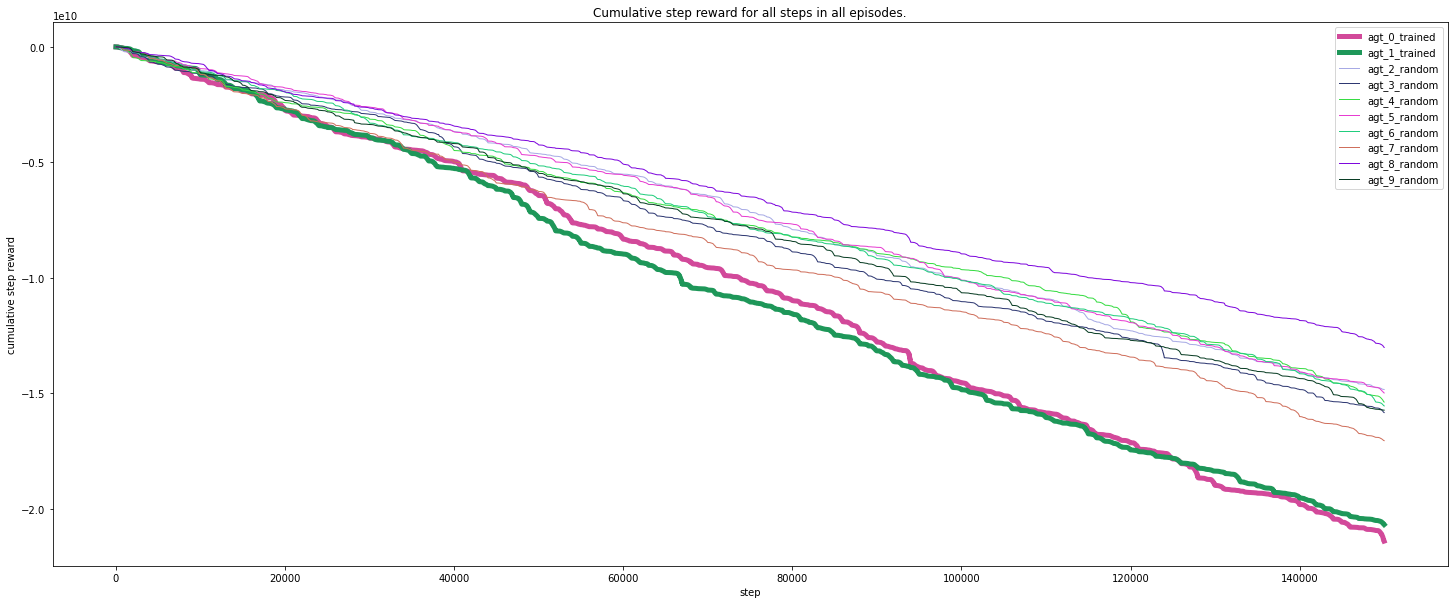

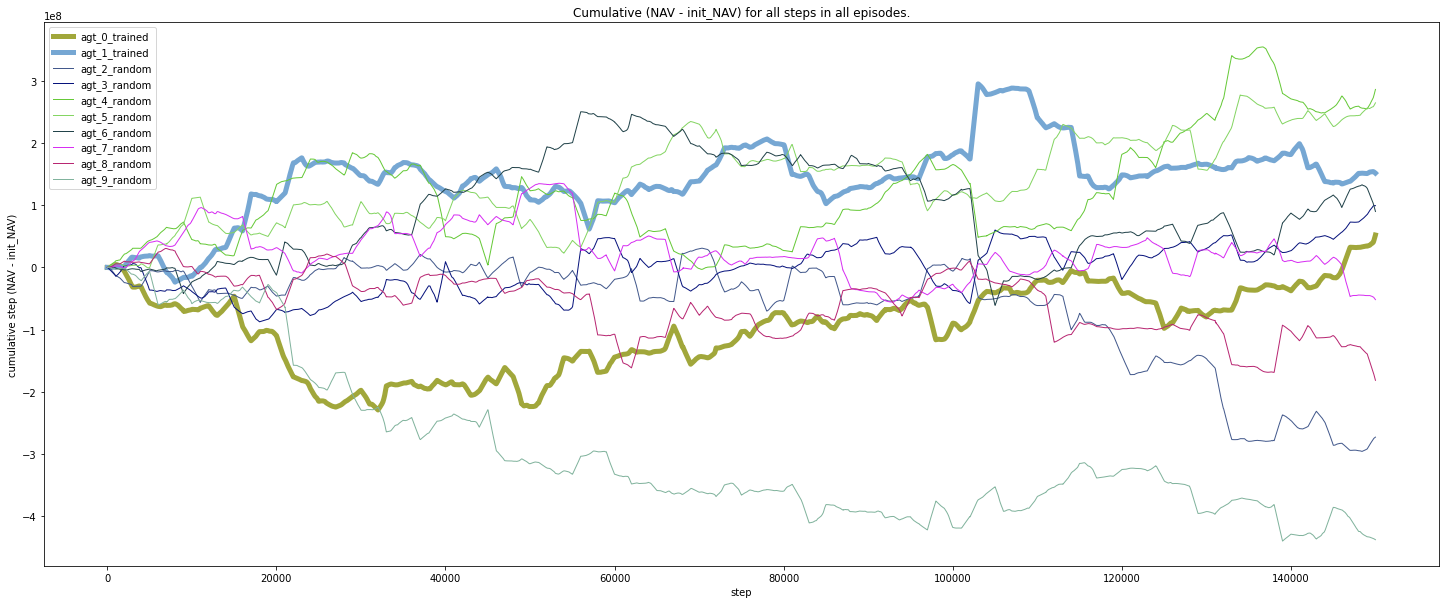

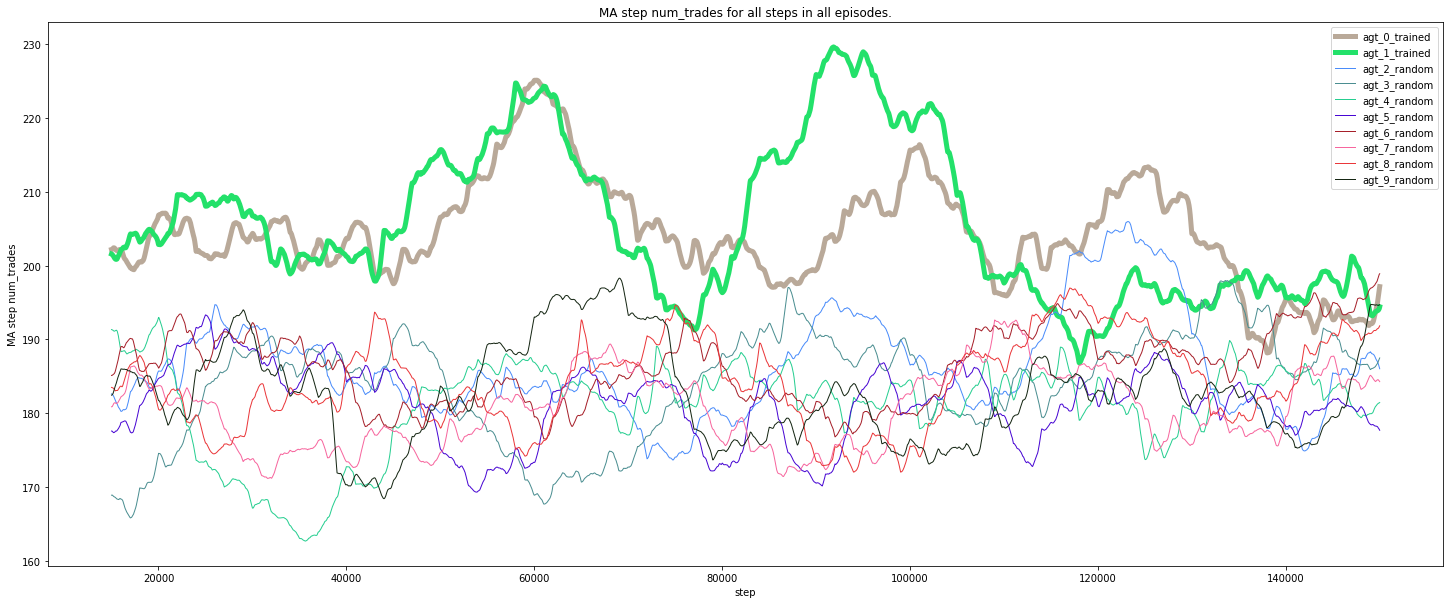

In [13]:
# Plot step results
plot_steps(init_cash, num_agents, num_trained_agent, "reward", reward_step_store, 'agt_', '_reward_step_list', '_trained', 'step', 'cumulative step reward', 'Cumulative step reward for all steps in all episodes.')
plot_steps(init_cash, num_agents, num_trained_agent, "NAV", NAV_step_store, 'agt_', '_NAV_step_list', '_trained', 'step', 'cumulative step (NAV - init_NAV)', 'Cumulative (NAV - init_NAV) for all steps in all episodes.')
plot_steps(init_cash, num_agents, num_trained_agent, "num_trades", num_trades_step_store, 'agt_', '_num_trades_step_list', '_trained', 'step', 'MA step num_trades', 'MA step num_trades for all steps in all episodes.') 

# Episodes

In [0]:
# Log episodes data to json files.
log_eps(write_eps_dir, "policy_reward", policy_reward_store)
log_eps(write_eps_dir, "reward", reward_store)
log_eps(write_eps_dir, "NAV", NAV_store)
log_eps(write_eps_dir, "num_trades", num_trades_store)

In [0]:
# Load episodes data from json files to dictionaries.
policy_reward_store = load_eps(write_eps_dir, 'policy_reward.dat', policy_reward_store)
reward_store = load_eps(write_eps_dir, 'reward.dat', reward_store)
NAV_store = load_eps(write_eps_dir, 'NAV.dat', NAV_store)
num_trades_store = load_eps(write_eps_dir, 'num_trades.dat', num_trades_store)

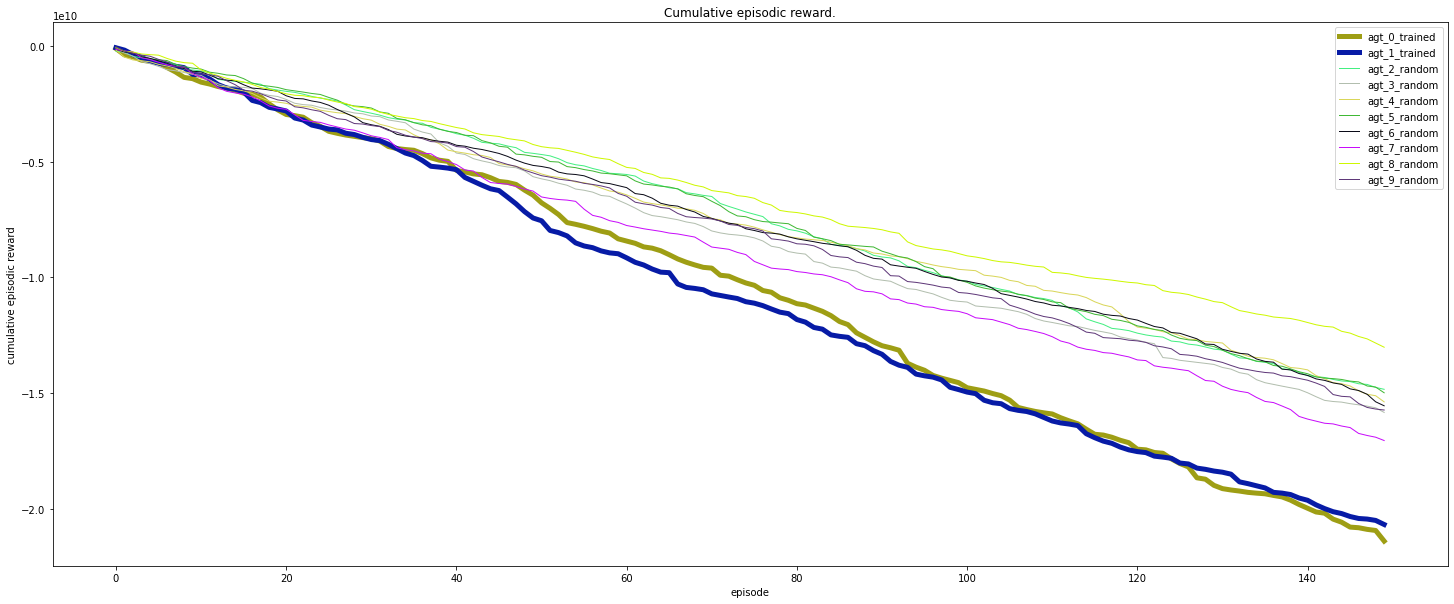

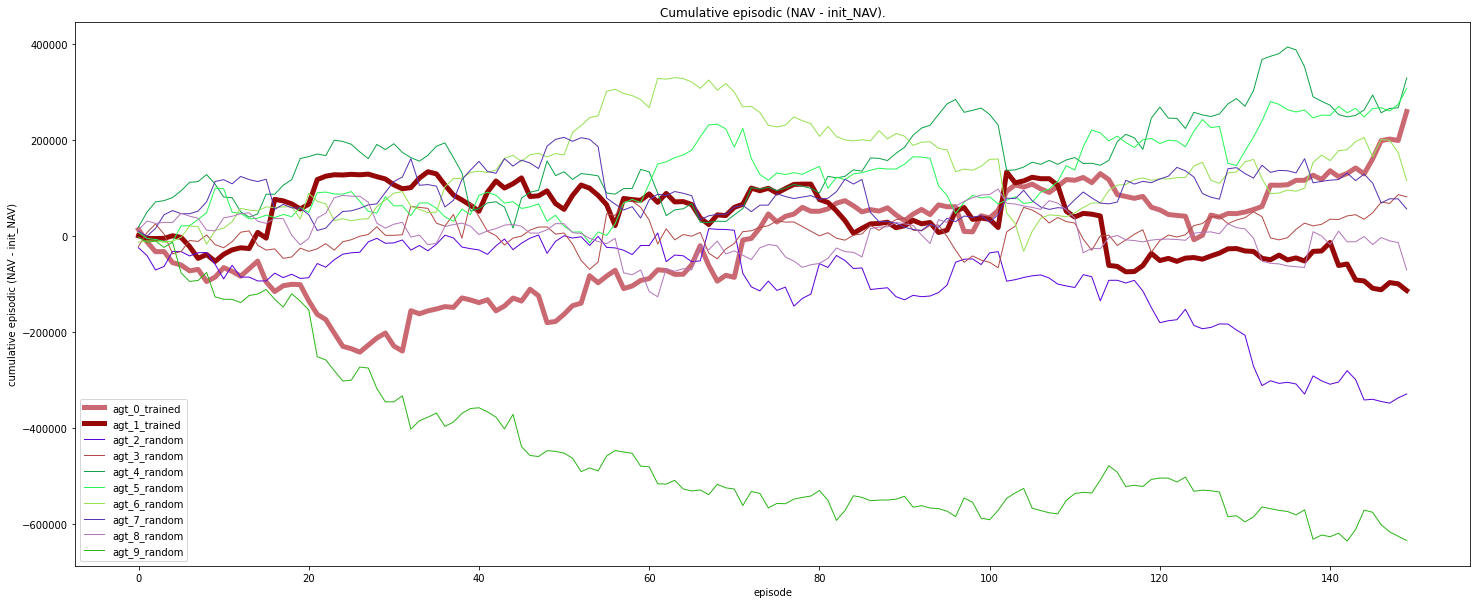

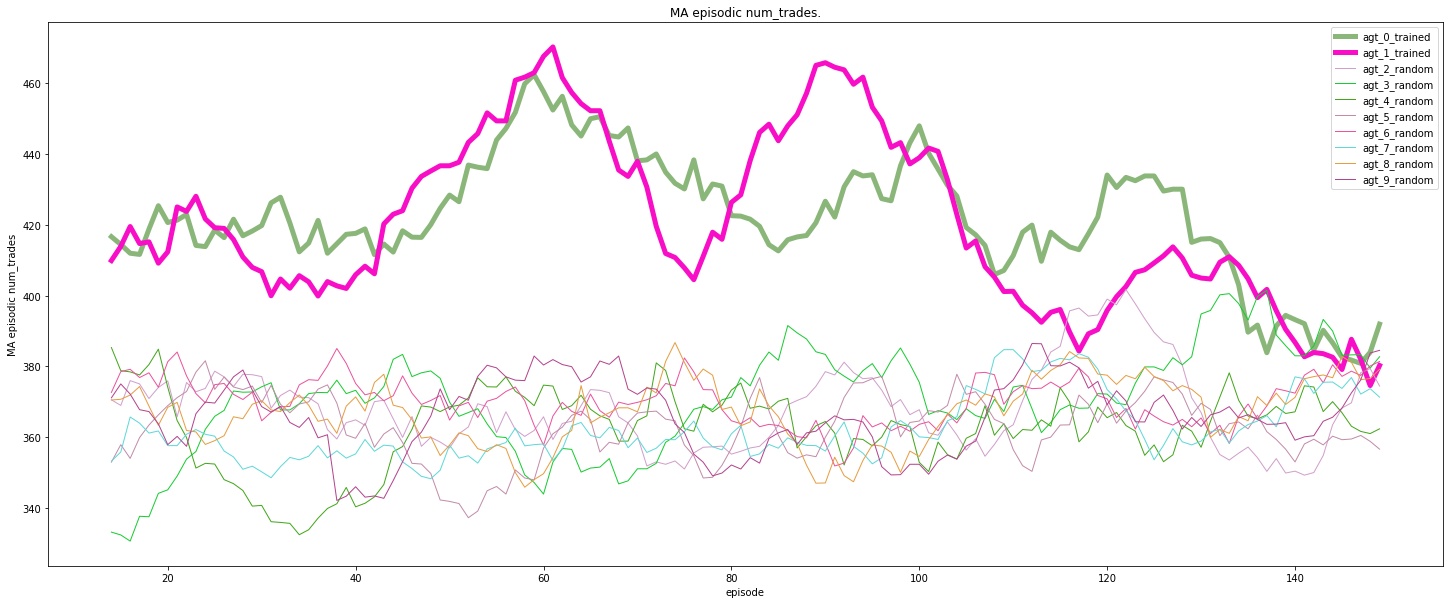

In [16]:
# Plot episodic results
plot_eps(init_cash, num_agents, num_trained_agent, "reward", policy_reward_store, 'agt_', '_policy_reward_list', '_trained', 'episode','cumulative episodic reward', 'Cumulative episodic reward.')
#plot_eps(init_cash, num_agents, num_trained_agent, "reward", reward_store, 'agt_', '_reward_list', '_trained', 'episode','cumulative episodic raw reward', 'Last step raw reward, unlike policy_reward_store which is total reward/eps.') # last step raw reward, unlike policy_reward_store which is total reward/eps.
plot_eps(init_cash, num_agents, num_trained_agent, "NAV", NAV_store, 'agt_', '_NAV_list', '_trained', 'episode','cumulative episodic (NAV - init_NAV)', 'Cumulative episodic (NAV - init_NAV).')
plot_eps(init_cash, num_agents, num_trained_agent, "num_trades", num_trades_store, 'agt_', '_num_trades_list', '_trained', 'episode','MA episodic num_trades', 'MA episodic num_trades.')   

# Steps from last episode.

In [17]:
"""
obs_store = create_storage(num_agents, "agt_", "_obs_list")
act_store = create_storage(num_agents, "agt_", "_act_list")
infos_store = create_storage(num_agents, "agt_", "_infos_list")
"""

# load last episode for all agents
#load_json(write_last_eps_steps_dir, max_step, obs_store, act_store, infos_store)
load_json_gzip(write_last_eps_steps_dir, max_step, obs_store, act_store, infos_store)

0_0_11406319.gzip
1_1_11406319.gzip
2_2_11406319.gzip
3_3_11406319.gzip
4_4_11406319.gzip
5_5_11406319.gzip
6_6_11406319.gzip
7_7_11406319.gzip
8_8_11406319.gzip
9_9_11406319.gzip


In [0]:
reward_dict = get_last_eps_steps(num_agents, 'reward', infos_store, 'agt_', '_infos_list')
NAV_dict = get_last_eps_steps(num_agents, 'NAV', infos_store, 'agt_', '_infos_list')
num_trades_dict = get_last_eps_steps(num_agents, 'num_trades', infos_store, 'agt_', '_infos_list')

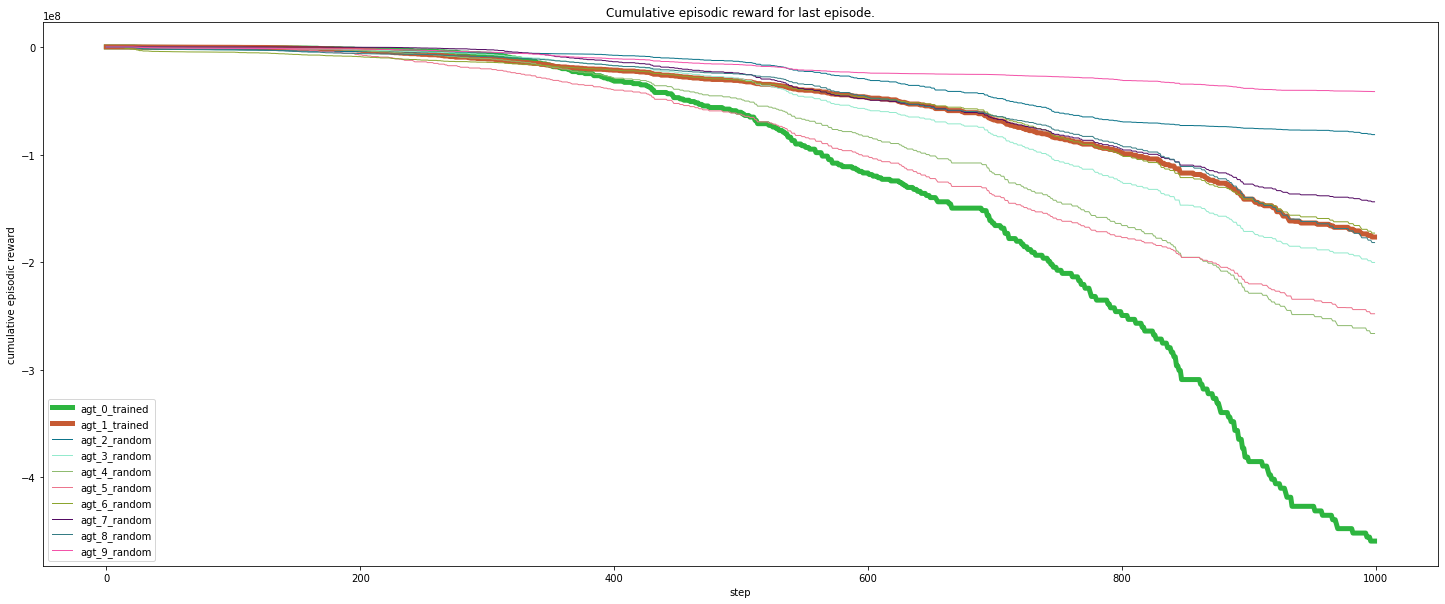

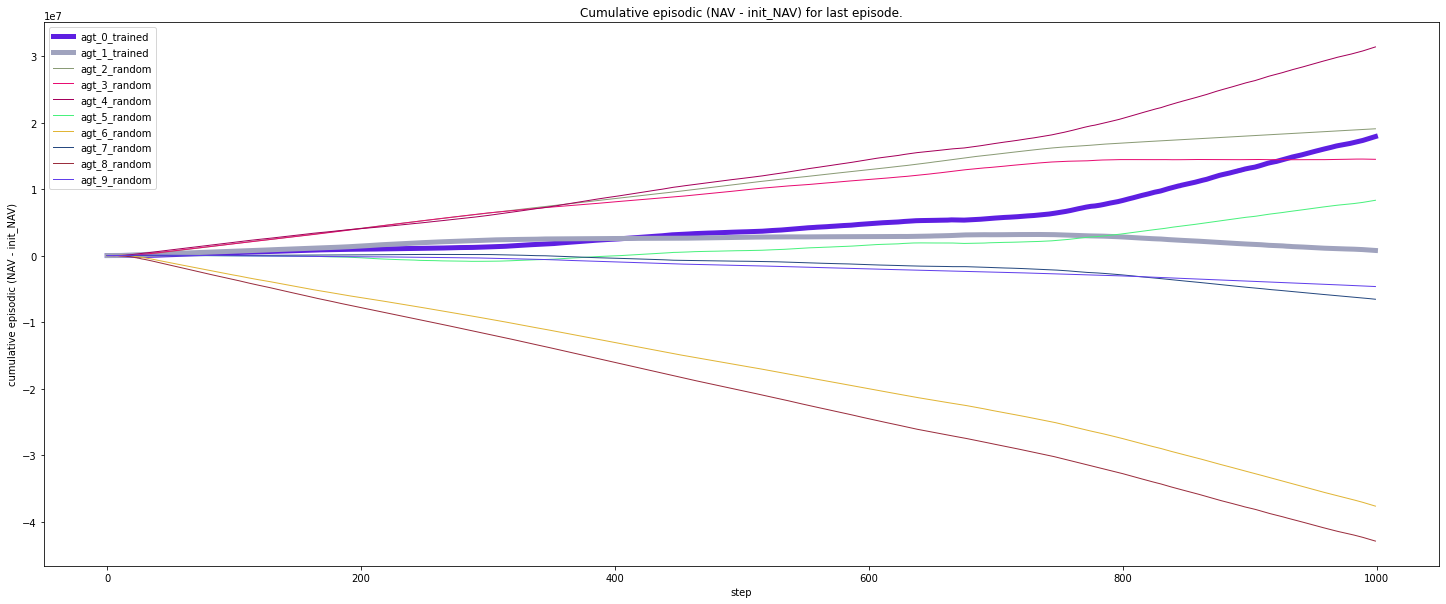

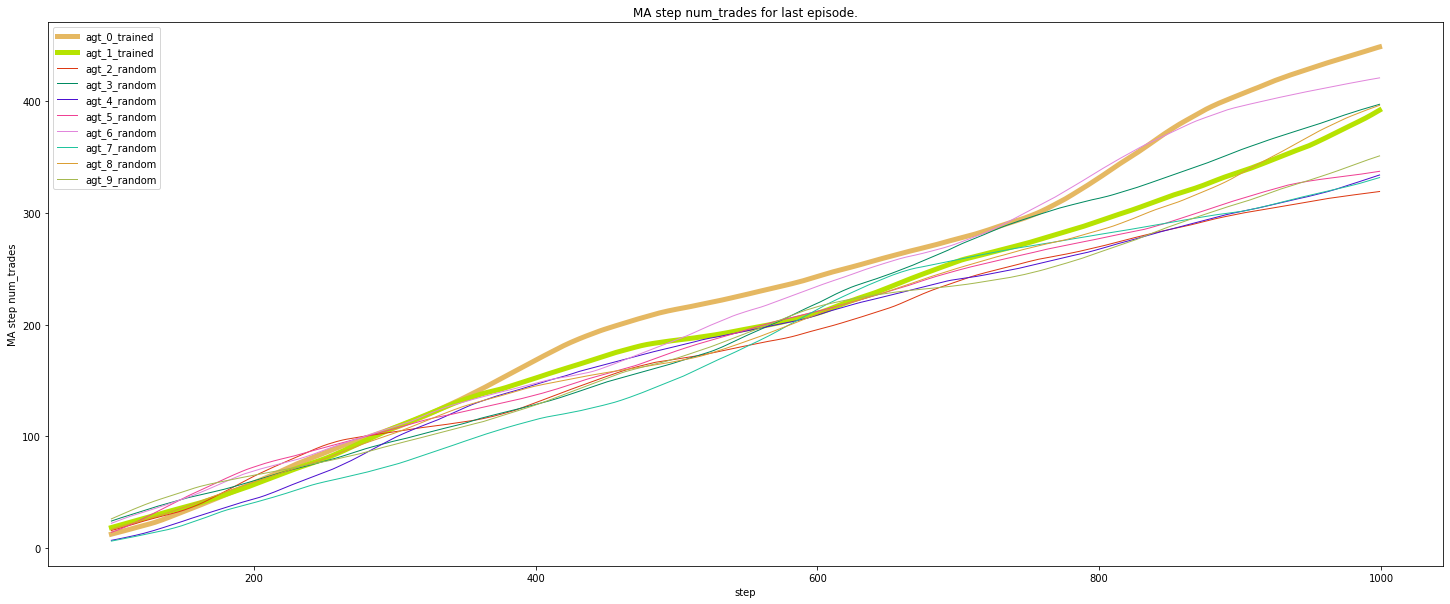

In [19]:
plot_last_eps_steps(reward_dict, num_trained_agent, 'reward', init_cash, "agt_", "reward_dict", "_trained", 'cumulative episodic reward', 'Cumulative episodic reward for last episode.')    
plot_last_eps_steps(NAV_dict, num_trained_agent, 'NAV', init_cash, "agt_", "NAV_dict", "_trained", 'cumulative episodic (NAV - init_NAV)', 'Cumulative episodic (NAV - init_NAV) for last episode.')  
plot_last_eps_steps(num_trades_dict, num_trained_agent, 'num_trades', init_cash, "agt_", "num_trades_dict", "_trained", 'MA step num_trades', 'MA step num_trades for last episode.')      

#LOB

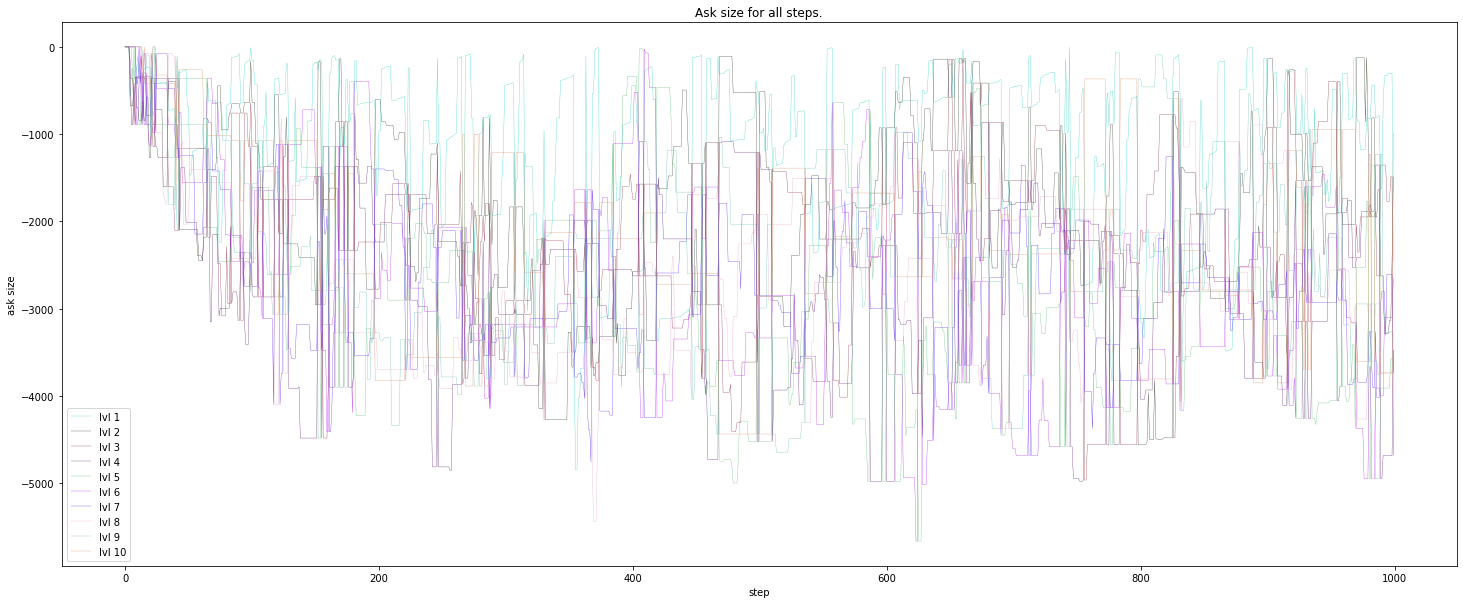

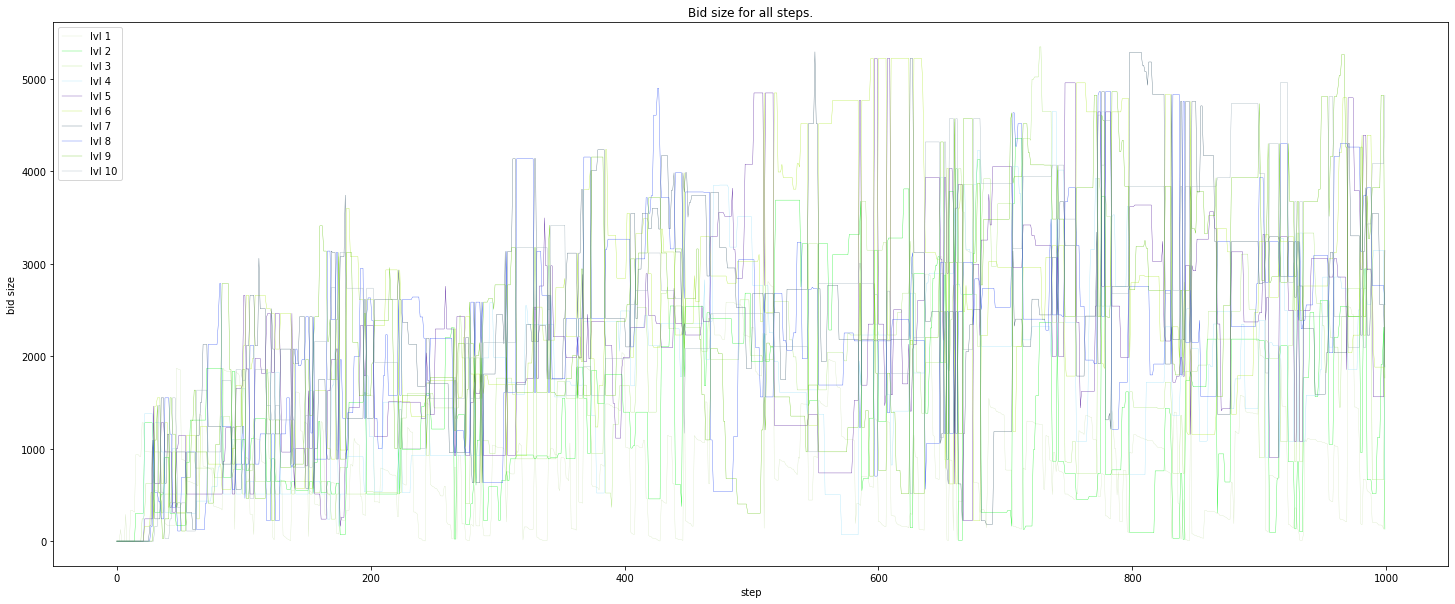

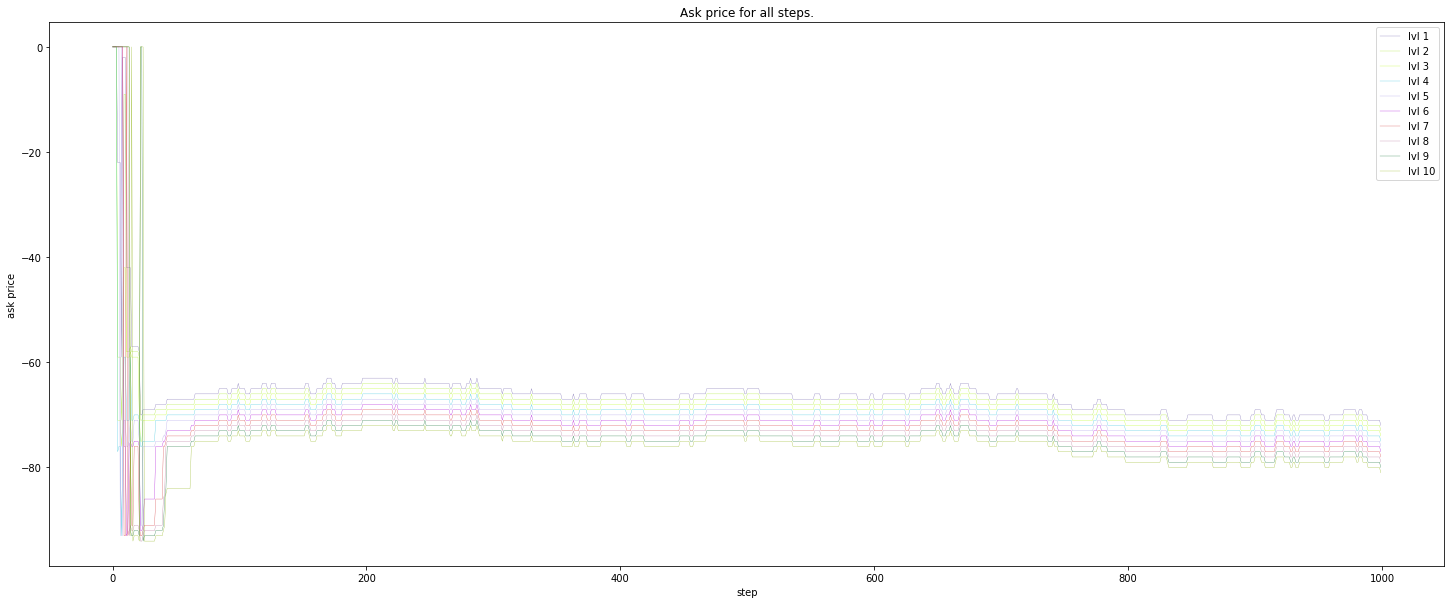

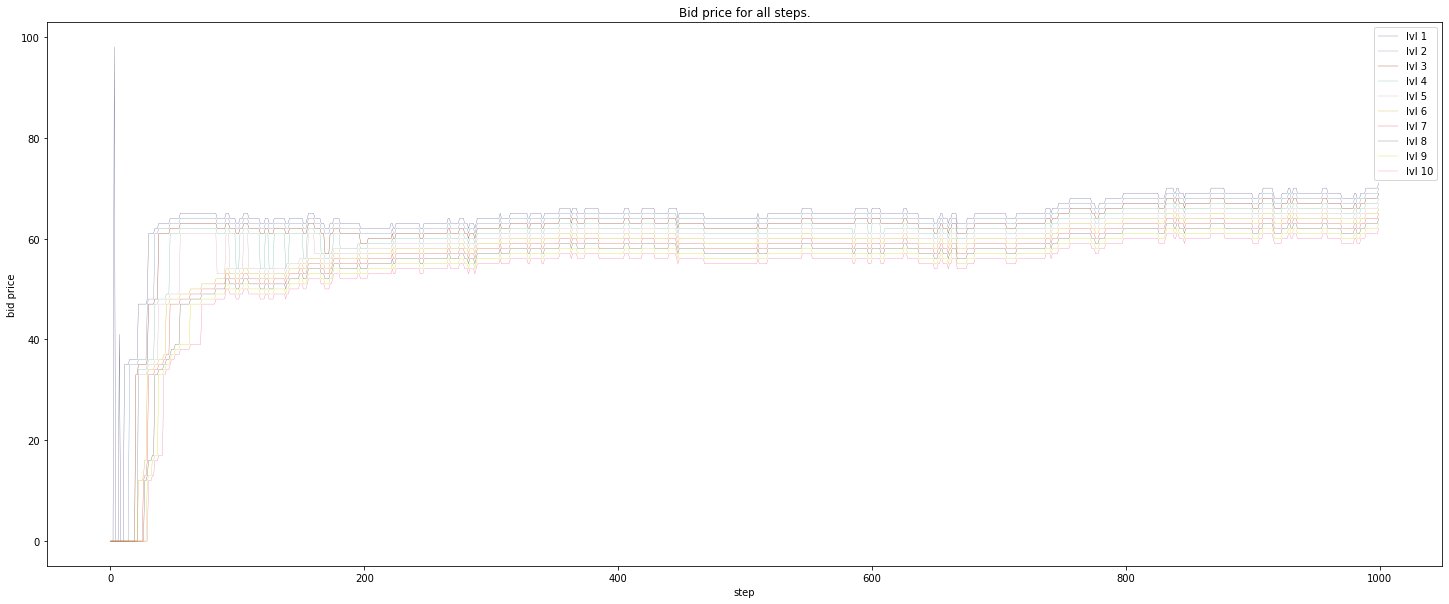

In [20]:
# Plot obs for all steps in last episode
show_obs(obs_store)

#Order Imbalance & midpoint price.

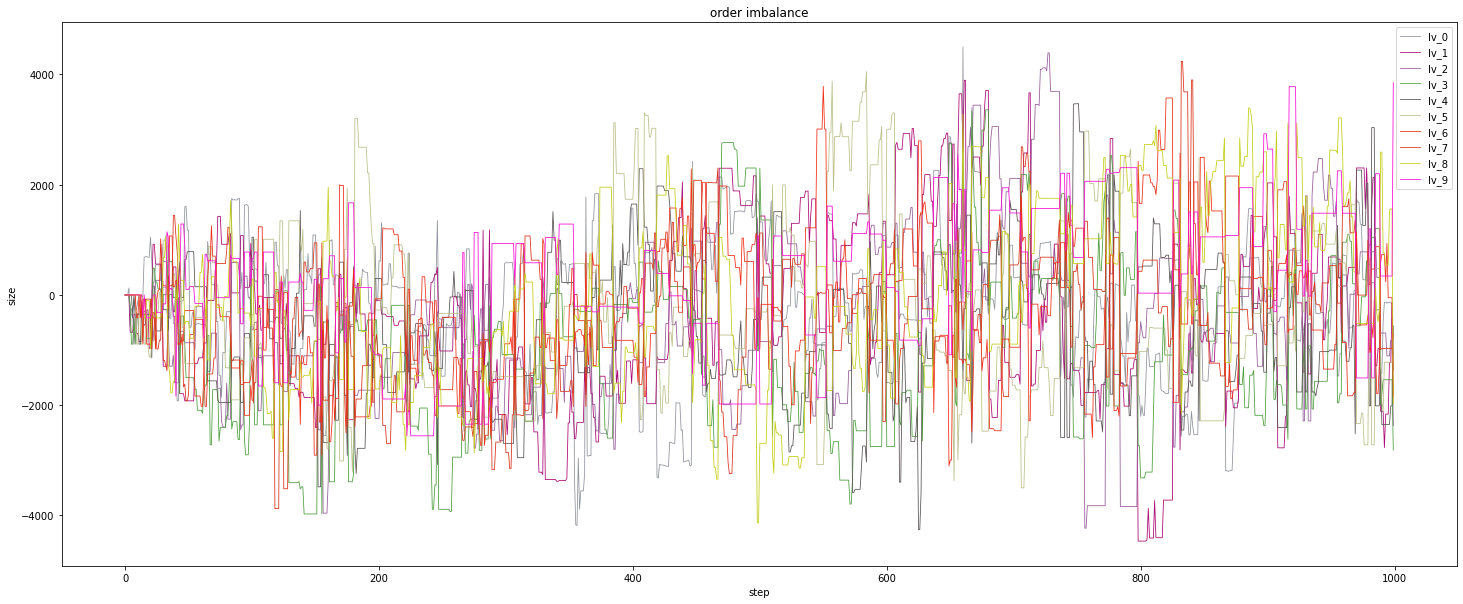

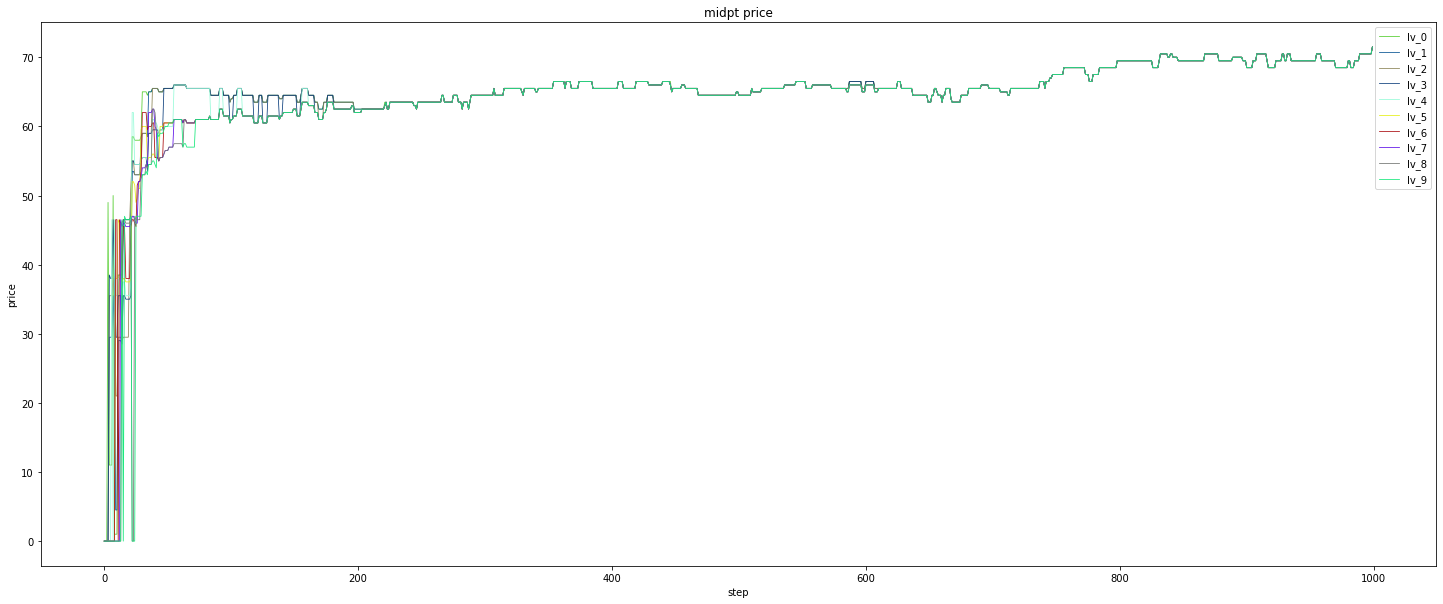

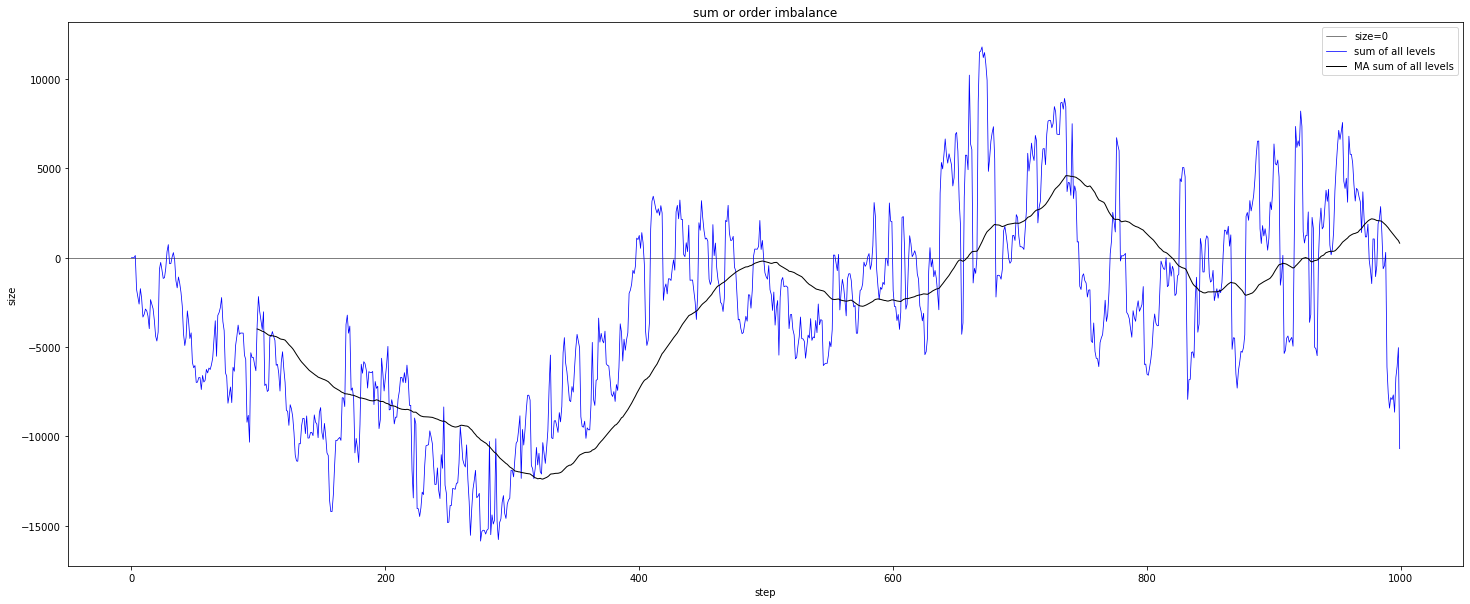

In [21]:
bid_size_start = 0
bid_price_start = 10
ask_size_start = 20
ask_price_start = 30
offset = 10    
key = "agt_0_obs_list"

bid_size_lv_dict = get_lv_dict(bid_size_start, bid_size_start + offset, obs_store, key)
ask_size_lv_dict = get_lv_dict(ask_size_start, ask_size_start + offset, obs_store, key)
bid_price_lv_dict = get_lv_dict(bid_price_start, bid_price_start + offset, obs_store, key)
ask_price_lv_dict = get_lv_dict(ask_price_start, ask_price_start + offset, obs_store, key)

size_imb = size_imb(bid_size_lv_dict, ask_size_lv_dict)
midpt_price = midpt_price(bid_price_lv_dict, ask_price_lv_dict)

plot_imb(size_imb, "order imbalance", "size")
plot_imb(midpt_price, "midpt price", "price")  

res = sum_all_lv(size_imb)      
plot_sum_imb(res, "sum or order imbalance", "size")